In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import json
import random
from pathlib import Path

import matplotlib.pyplot as plt
import nltk
import numpy as np
import torch
from PIL import Image
from torch.utils.data import DataLoader
from torchvision import transforms
from tqdm import tqdm

from transformers import BlipProcessor, BlipForQuestionAnswering

nltk.download("punkt")
nltk.download("punkt_tab")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\jherng\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\jherng\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [3]:
from woa7015_medvqa.v1.dataset.collate_fn import collate_fn
from woa7015_medvqa.v1.dataset.slake_dataset import SlakeDataset
from woa7015_medvqa.v1.dataset.tokenizer import tokenize
from woa7015_medvqa.v1.dataset.vocab import Vocab
from woa7015_medvqa.v1.models.resnet_lstm import ResNetLSTM


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\jherng\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\jherng\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [4]:
PROJECT_ROOT = Path.cwd().parent
DATASET_DIR = PROJECT_ROOT / "data"
SLAKE_DIR = DATASET_DIR / "SLAKE"


In [5]:
train_json = SLAKE_DIR / "train.json"
val_json = SLAKE_DIR / "validation.json"
imgs = SLAKE_DIR / "imgs"
raw_train = json.loads(Path(train_json).read_text(encoding="utf-8"))
answers = [item["answer"] for item in raw_train if item["q_lang"] == "en"]
vocab = Vocab(answers)

transform = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor()])
train_ds = SlakeDataset(train_json, imgs, tokenize, vocab, transform)
val_ds = SlakeDataset(val_json, imgs, tokenize, vocab, transform)
test_ds = SlakeDataset(val_json, imgs, tokenize, vocab, transform)
train_dl = DataLoader(train_ds, batch_size=16, shuffle=True, collate_fn=collate_fn)
val_dl = DataLoader(val_ds, batch_size=16, collate_fn=collate_fn)
test_dl = DataLoader(test_ds, batch_size=16, collate_fn=collate_fn)


Number of training examples: 9835
Number of training examples (English only): 4919


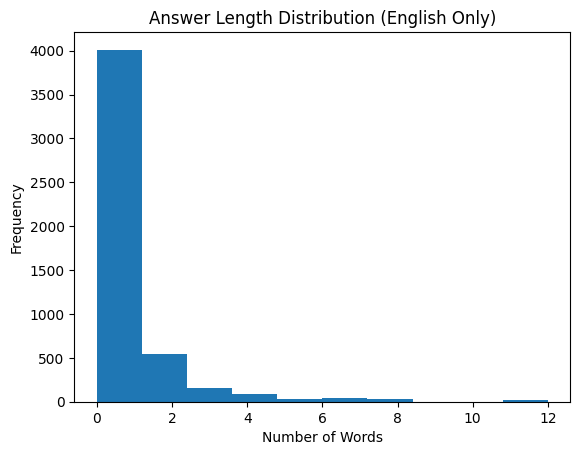

In [6]:
print(f"Number of training examples: {len(raw_train)}")
print(
    f"Number of training examples (English only): {len([x for x in raw_train if x['q_lang'] == 'en'])}"
)
plt.hist([len(x["answer"].split()) for x in raw_train if x["q_lang"] == "en"], bins=10)
plt.title("Answer Length Distribution (English Only)")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.show()

In [7]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = ResNetLSTM(vocab_size=len(vocab.itos)).to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = torch.nn.CrossEntropyLoss()
epochs = 5

# Check number of parameters
print(
    f"Number of parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}"
)
model


Number of parameters: 13418622


ResNetLSTM(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_r

In [8]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = ResNetLSTM(vocab_size=len(vocab.itos)).to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = torch.nn.CrossEntropyLoss()
epochs = 5


def train_one_epoch(model, dataloader, optimizer, criterion, device, epoch=0, epochs=5):
    model.train()
    epoch_loss = 0.0
    pbar = tqdm(dataloader, desc=f"Train Epoch {epoch + 1}/{epochs}", unit="batch")
    for imgs, questions, answers, _ in pbar:
        imgs, questions, answers = (
            imgs.to(device),
            questions.to(device),
            answers.to(device),
        )
        print(imgs.shape, questions.shape)

        optimizer.zero_grad()

        outputs = model(imgs, questions)
        loss = criterion(outputs, answers)

        loss.backward()
        optimizer.step()

        batch_loss = loss.detach().cpu().numpy()
        epoch_loss += batch_loss
        pbar.set_postfix(loss=f"{batch_loss:.4f}")
    avg_epoch_loss = epoch_loss / len(dataloader)
    print(f"Epoch {epoch + 1}/{epochs} Training Loss: {avg_epoch_loss:.4f}")
    return avg_epoch_loss


def validate_one_epoch(model, dataloader, criterion, device, epoch=0, epochs=5):
    model.eval()
    epoch_loss = 0.0
    correct = 0
    total = 0
    pbar = tqdm(dataloader, desc=f"Valid Epoch {epoch + 1}/{epochs}", unit="batch")
    with torch.no_grad():
        for imgs, questions, answers, _ in pbar:
            imgs, questions, answers = (
                imgs.to(device),
                questions.to(device),
                answers.to(device),
            )
            outputs = model(imgs, questions)
            loss = criterion(outputs, answers)
            batch_loss = loss.detach().cpu().numpy()
            epoch_loss += batch_loss
            _, predicted = torch.max(outputs.data, 1)
            total += answers.size(0)
            correct += (predicted == answers).sum().item()
            pbar.set_postfix(loss=f"{batch_loss:.4f}")
    avg_epoch_loss = epoch_loss / len(dataloader)
    accuracy = 100 * correct / total
    print(
        f"Epoch {epoch + 1}/{epochs} Validation Loss: {avg_epoch_loss:.4f}, Accuracy: {accuracy:.2f}%"
    )
    return avg_epoch_loss


def train(model, train_dl, val_dl, opt, criterion, device, epochs=5):
    train_losses = []
    val_losses = []
    for epoch in range(epochs):
        train_loss = train_one_epoch(
            model,
            train_dl,
            opt,
            criterion,
            device,
            epoch,
            epochs,
        )
        val_loss = validate_one_epoch(
            model,
            val_dl,
            criterion,
            device,
            epoch,
            epochs,
        )
        train_losses.append(train_loss)
        val_losses.append(val_loss)
    return train_losses, val_losses


train_losses, val_losses = train(
    model, train_dl, val_dl, opt, criterion, device, epochs
)

Train Epoch 1/5:   0%|          | 0/308 [00:00<?, ?batch/s]

torch.Size([16, 3, 224, 224]) torch.Size([16, 12])


Train Epoch 1/5:   1%|          | 2/308 [00:00<02:03,  2.48batch/s, loss=5.5225]

torch.Size([16, 3, 224, 224]) torch.Size([16, 16])
torch.Size([16, 3, 224, 224]) torch.Size([16, 17])


Train Epoch 1/5:   1%|▏         | 4/308 [00:01<01:17,  3.92batch/s, loss=5.2641]

torch.Size([16, 3, 224, 224]) torch.Size([16, 14])
torch.Size([16, 3, 224, 224]) torch.Size([16, 17])


Train Epoch 1/5:   2%|▏         | 6/308 [00:01<01:06,  4.57batch/s, loss=5.2234]

torch.Size([16, 3, 224, 224]) torch.Size([16, 19])
torch.Size([16, 3, 224, 224]) torch.Size([16, 18])


Train Epoch 1/5:   3%|▎         | 8/308 [00:01<00:58,  5.16batch/s, loss=4.8322]

torch.Size([16, 3, 224, 224]) torch.Size([16, 14])
torch.Size([16, 3, 224, 224]) torch.Size([16, 18])


Train Epoch 1/5:   4%|▎         | 11/308 [00:02<00:49,  5.99batch/s, loss=5.0650]

torch.Size([16, 3, 224, 224]) torch.Size([16, 14])
torch.Size([16, 3, 224, 224]) torch.Size([16, 18])


Train Epoch 1/5:   4%|▍         | 12/308 [00:02<00:49,  5.99batch/s, loss=4.8933]

torch.Size([16, 3, 224, 224]) torch.Size([16, 10])
torch.Size([16, 3, 224, 224]) torch.Size([16, 13])


Train Epoch 1/5:   5%|▍         | 15/308 [00:03<00:41,  7.11batch/s, loss=4.7338]

torch.Size([16, 3, 224, 224]) torch.Size([16, 16])
torch.Size([16, 3, 224, 224]) torch.Size([16, 14])


Train Epoch 1/5:   6%|▌         | 17/308 [00:03<00:40,  7.24batch/s, loss=5.0091]

torch.Size([16, 3, 224, 224]) torch.Size([16, 19])
torch.Size([16, 3, 224, 224]) torch.Size([16, 22])


Train Epoch 1/5:   6%|▌         | 18/308 [00:03<00:41,  7.00batch/s, loss=4.6905]

torch.Size([16, 3, 224, 224]) torch.Size([16, 14])
torch.Size([16, 3, 224, 224]) torch.Size([16, 15])


Train Epoch 1/5:   7%|▋         | 21/308 [00:03<00:38,  7.43batch/s, loss=4.4668]

torch.Size([16, 3, 224, 224]) torch.Size([16, 13])
torch.Size([16, 3, 224, 224]) torch.Size([16, 14])


Train Epoch 1/5:   7%|▋         | 22/308 [00:03<00:36,  7.74batch/s, loss=3.8236]

torch.Size([16, 3, 224, 224]) torch.Size([16, 12])
torch.Size([16, 3, 224, 224]) torch.Size([16, 16])


Train Epoch 1/5:   8%|▊         | 25/308 [00:04<00:42,  6.69batch/s, loss=4.4878]

torch.Size([16, 3, 224, 224]) torch.Size([16, 13])
torch.Size([16, 3, 224, 224]) torch.Size([16, 12])


Train Epoch 1/5:   8%|▊         | 26/308 [00:04<00:43,  6.45batch/s, loss=4.1063]

torch.Size([16, 3, 224, 224]) torch.Size([16, 18])
torch.Size([16, 3, 224, 224]) torch.Size([16, 12])


Train Epoch 1/5:   9%|▉         | 28/308 [00:04<00:41,  6.73batch/s, loss=4.3791]

torch.Size([16, 3, 224, 224]) torch.Size([16, 14])
torch.Size([16, 3, 224, 224]) torch.Size([16, 19])


Train Epoch 1/5:  10%|█         | 31/308 [00:05<00:40,  6.84batch/s, loss=3.3491]

torch.Size([16, 3, 224, 224]) torch.Size([16, 15])
torch.Size([16, 3, 224, 224]) torch.Size([16, 14])


Train Epoch 1/5:  11%|█         | 33/308 [00:05<00:40,  6.87batch/s, loss=4.3421]

torch.Size([16, 3, 224, 224]) torch.Size([16, 19])
torch.Size([16, 3, 224, 224]) torch.Size([16, 12])


Train Epoch 1/5:  11%|█▏        | 35/308 [00:05<00:38,  7.09batch/s, loss=3.5090]

torch.Size([16, 3, 224, 224]) torch.Size([16, 16])
torch.Size([16, 3, 224, 224]) torch.Size([16, 17])


Train Epoch 1/5:  12%|█▏        | 37/308 [00:06<00:37,  7.17batch/s, loss=3.6441]

torch.Size([16, 3, 224, 224]) torch.Size([16, 13])
torch.Size([16, 3, 224, 224]) torch.Size([16, 19])


Train Epoch 1/5:  13%|█▎        | 39/308 [00:06<00:37,  7.09batch/s, loss=3.9455]

torch.Size([16, 3, 224, 224]) torch.Size([16, 17])
torch.Size([16, 3, 224, 224]) torch.Size([16, 15])


Train Epoch 1/5:  13%|█▎        | 41/308 [00:06<00:34,  7.78batch/s, loss=4.0078]

torch.Size([16, 3, 224, 224]) torch.Size([16, 19])
torch.Size([16, 3, 224, 224]) torch.Size([16, 14])


Train Epoch 1/5:  14%|█▍        | 43/308 [00:06<00:32,  8.08batch/s, loss=3.6894]

torch.Size([16, 3, 224, 224]) torch.Size([16, 14])
torch.Size([16, 3, 224, 224]) torch.Size([16, 19])


Train Epoch 1/5:  15%|█▍        | 45/308 [00:07<00:33,  7.81batch/s, loss=3.4967]

torch.Size([16, 3, 224, 224]) torch.Size([16, 15])
torch.Size([16, 3, 224, 224]) torch.Size([16, 13])


Train Epoch 1/5:  15%|█▌        | 47/308 [00:07<00:33,  7.86batch/s, loss=3.6689]

torch.Size([16, 3, 224, 224]) torch.Size([16, 19])
torch.Size([16, 3, 224, 224]) torch.Size([16, 14])


Train Epoch 1/5:  16%|█▌        | 49/308 [00:07<00:31,  8.11batch/s, loss=4.3882]

torch.Size([16, 3, 224, 224]) torch.Size([16, 15])
torch.Size([16, 3, 224, 224]) torch.Size([16, 12])


Train Epoch 1/5:  17%|█▋        | 51/308 [00:07<00:30,  8.53batch/s, loss=3.2778]

torch.Size([16, 3, 224, 224]) torch.Size([16, 12])
torch.Size([16, 3, 224, 224]) torch.Size([16, 12])


Train Epoch 1/5:  17%|█▋        | 53/308 [00:08<00:30,  8.50batch/s, loss=2.9676]

torch.Size([16, 3, 224, 224]) torch.Size([16, 14])
torch.Size([16, 3, 224, 224]) torch.Size([16, 15])


Train Epoch 1/5:  18%|█▊        | 55/308 [00:08<00:29,  8.64batch/s, loss=3.6167]

torch.Size([16, 3, 224, 224]) torch.Size([16, 16])
torch.Size([16, 3, 224, 224]) torch.Size([16, 19])


Train Epoch 1/5:  18%|█▊        | 56/308 [00:08<00:31,  8.09batch/s, loss=2.6961]

torch.Size([16, 3, 224, 224]) torch.Size([16, 13])
torch.Size([16, 3, 224, 224]) torch.Size([16, 11])


Train Epoch 1/5:  19%|█▉        | 59/308 [00:08<00:29,  8.34batch/s, loss=3.5929]

torch.Size([16, 3, 224, 224]) torch.Size([16, 14])
torch.Size([16, 3, 224, 224]) torch.Size([16, 21])


Train Epoch 1/5:  20%|█▉        | 61/308 [00:09<00:30,  8.16batch/s, loss=3.3756]

torch.Size([16, 3, 224, 224]) torch.Size([16, 15])
torch.Size([16, 3, 224, 224]) torch.Size([16, 15])


Train Epoch 1/5:  20%|██        | 63/308 [00:09<00:28,  8.63batch/s, loss=2.8930]

torch.Size([16, 3, 224, 224]) torch.Size([16, 15])
torch.Size([16, 3, 224, 224]) torch.Size([16, 14])


Train Epoch 1/5:  21%|██        | 64/308 [00:09<00:27,  8.93batch/s, loss=3.6928]

torch.Size([16, 3, 224, 224]) torch.Size([16, 14])
torch.Size([16, 3, 224, 224]) torch.Size([16, 16])


Train Epoch 1/5:  21%|██▏       | 66/308 [00:09<00:26,  9.11batch/s, loss=4.0953]

torch.Size([16, 3, 224, 224]) torch.Size([16, 17])
torch.Size([16, 3, 224, 224]) torch.Size([16, 15])
torch.Size([16, 3, 224, 224]) torch.Size([16, 14])


Train Epoch 1/5:  22%|██▏       | 69/308 [00:10<00:25,  9.26batch/s, loss=3.4630]

torch.Size([16, 3, 224, 224]) torch.Size([16, 13])
torch.Size([16, 3, 224, 224]) torch.Size([16, 14])


Train Epoch 1/5:  23%|██▎       | 71/308 [00:10<00:25,  9.29batch/s, loss=2.5574]

torch.Size([16, 3, 224, 224]) torch.Size([16, 21])
torch.Size([16, 3, 224, 224]) torch.Size([16, 12])


Train Epoch 1/5:  24%|██▍       | 74/308 [00:10<00:25,  9.06batch/s, loss=3.8748]

torch.Size([16, 3, 224, 224]) torch.Size([16, 14])
torch.Size([16, 3, 224, 224]) torch.Size([16, 15])


Train Epoch 1/5:  25%|██▍       | 76/308 [00:10<00:25,  9.14batch/s, loss=3.4530]

torch.Size([16, 3, 224, 224]) torch.Size([16, 18])
torch.Size([16, 3, 224, 224]) torch.Size([16, 14])


Train Epoch 1/5:  25%|██▌       | 77/308 [00:10<00:25,  9.24batch/s, loss=2.7805]

torch.Size([16, 3, 224, 224]) torch.Size([16, 12])
torch.Size([16, 3, 224, 224]) torch.Size([16, 17])


Train Epoch 1/5:  26%|██▌       | 80/308 [00:11<00:26,  8.76batch/s, loss=3.3115]

torch.Size([16, 3, 224, 224]) torch.Size([16, 12])
torch.Size([16, 3, 224, 224]) torch.Size([16, 14])


Train Epoch 1/5:  27%|██▋       | 82/308 [00:11<00:25,  8.97batch/s, loss=3.1167]

torch.Size([16, 3, 224, 224]) torch.Size([16, 18])
torch.Size([16, 3, 224, 224]) torch.Size([16, 14])


Train Epoch 1/5:  27%|██▋       | 83/308 [00:11<00:24,  9.07batch/s, loss=3.3628]

torch.Size([16, 3, 224, 224]) torch.Size([16, 14])
torch.Size([16, 3, 224, 224]) torch.Size([16, 13])


Train Epoch 1/5:  28%|██▊       | 86/308 [00:11<00:25,  8.72batch/s, loss=4.2995]

torch.Size([16, 3, 224, 224]) torch.Size([16, 18])
torch.Size([16, 3, 224, 224]) torch.Size([16, 17])


Train Epoch 1/5:  29%|██▊       | 88/308 [00:12<00:26,  8.40batch/s, loss=4.4578]

torch.Size([16, 3, 224, 224]) torch.Size([16, 19])
torch.Size([16, 3, 224, 224]) torch.Size([16, 19])
torch.Size([16, 3, 224, 224]) torch.Size([16, 14])


Train Epoch 1/5:  30%|██▉       | 91/308 [00:12<00:23,  9.06batch/s, loss=3.3351]

torch.Size([16, 3, 224, 224]) torch.Size([16, 16])
torch.Size([16, 3, 224, 224]) torch.Size([16, 12])


Train Epoch 1/5:  30%|██▉       | 92/308 [00:12<00:23,  9.04batch/s, loss=3.7866]

torch.Size([16, 3, 224, 224]) torch.Size([16, 14])
torch.Size([16, 3, 224, 224]) torch.Size([16, 14])
torch.Size([16, 3, 224, 224]) torch.Size([16, 16])


Train Epoch 1/5:  31%|███       | 95/308 [00:12<00:23,  9.10batch/s, loss=3.9564]

torch.Size([16, 3, 224, 224]) torch.Size([16, 19])
torch.Size([16, 3, 224, 224]) torch.Size([16, 18])
torch.Size([16, 3, 224, 224]) torch.Size([16, 13])


Train Epoch 1/5:  32%|███▏      | 99/308 [00:13<00:20, 10.34batch/s, loss=3.0496]

torch.Size([16, 3, 224, 224]) torch.Size([16, 17])
torch.Size([16, 3, 224, 224]) torch.Size([16, 14])


Train Epoch 1/5:  33%|███▎      | 101/308 [00:13<00:20, 10.06batch/s, loss=3.6962]

torch.Size([16, 3, 224, 224]) torch.Size([16, 15])
torch.Size([16, 3, 224, 224]) torch.Size([16, 17])
torch.Size([16, 3, 224, 224]) torch.Size([16, 14])


Train Epoch 1/5:  33%|███▎      | 103/308 [00:13<00:21,  9.71batch/s, loss=3.6018]

torch.Size([16, 3, 224, 224]) torch.Size([16, 19])
torch.Size([16, 3, 224, 224]) torch.Size([16, 12])
torch.Size([16, 3, 224, 224]) torch.Size([16, 14])


Train Epoch 1/5:  35%|███▍      | 107/308 [00:14<00:20,  9.92batch/s, loss=2.1745]

torch.Size([16, 3, 224, 224]) torch.Size([16, 14])
torch.Size([16, 3, 224, 224]) torch.Size([16, 13])
torch.Size([16, 3, 224, 224]) torch.Size([16, 11])


Train Epoch 1/5:  35%|███▌      | 109/308 [00:14<00:19, 10.45batch/s, loss=3.3716]

torch.Size([16, 3, 224, 224]) torch.Size([16, 14])
torch.Size([16, 3, 224, 224]) torch.Size([16, 14])
torch.Size([16, 3, 224, 224]) torch.Size([16, 14])


Train Epoch 1/5:  37%|███▋      | 113/308 [00:14<00:18, 10.70batch/s, loss=2.6499]

torch.Size([16, 3, 224, 224]) torch.Size([16, 14])
torch.Size([16, 3, 224, 224]) torch.Size([16, 14])
torch.Size([16, 3, 224, 224]) torch.Size([16, 22])


Train Epoch 1/5:  37%|███▋      | 115/308 [00:14<00:18, 10.38batch/s, loss=3.1784]

torch.Size([16, 3, 224, 224]) torch.Size([16, 19])
torch.Size([16, 3, 224, 224]) torch.Size([16, 14])
torch.Size([16, 3, 224, 224]) torch.Size([16, 12])


Train Epoch 1/5:  39%|███▊      | 119/308 [00:15<00:18, 10.06batch/s, loss=3.9635]

torch.Size([16, 3, 224, 224]) torch.Size([16, 14])
torch.Size([16, 3, 224, 224]) torch.Size([16, 18])
torch.Size([16, 3, 224, 224]) torch.Size([16, 22])


Train Epoch 1/5:  39%|███▉      | 121/308 [00:15<00:17, 10.45batch/s, loss=3.5003]

torch.Size([16, 3, 224, 224]) torch.Size([16, 18])
torch.Size([16, 3, 224, 224]) torch.Size([16, 15])
torch.Size([16, 3, 224, 224]) torch.Size([16, 16])


Train Epoch 1/5:  41%|████      | 125/308 [00:15<00:17, 10.72batch/s, loss=3.1641]

torch.Size([16, 3, 224, 224]) torch.Size([16, 12])
torch.Size([16, 3, 224, 224]) torch.Size([16, 14])
torch.Size([16, 3, 224, 224]) torch.Size([16, 14])


Train Epoch 1/5:  41%|████      | 127/308 [00:16<00:17, 10.26batch/s, loss=2.6320]

torch.Size([16, 3, 224, 224]) torch.Size([16, 12])
torch.Size([16, 3, 224, 224]) torch.Size([16, 14])
torch.Size([16, 3, 224, 224]) torch.Size([16, 21])


Train Epoch 1/5:  43%|████▎     | 131/308 [00:16<00:17, 10.14batch/s, loss=3.7058]

torch.Size([16, 3, 224, 224]) torch.Size([16, 14])
torch.Size([16, 3, 224, 224]) torch.Size([16, 18])


Train Epoch 1/5:  43%|████▎     | 133/308 [00:16<00:17,  9.87batch/s, loss=3.0301]

torch.Size([16, 3, 224, 224]) torch.Size([16, 19])
torch.Size([16, 3, 224, 224]) torch.Size([16, 17])


Train Epoch 1/5:  44%|████▍     | 135/308 [00:16<00:17, 10.00batch/s, loss=2.8508]

torch.Size([16, 3, 224, 224]) torch.Size([16, 13])
torch.Size([16, 3, 224, 224]) torch.Size([16, 12])
torch.Size([16, 3, 224, 224]) torch.Size([16, 17])


Train Epoch 1/5:  44%|████▍     | 137/308 [00:17<00:16, 10.14batch/s, loss=3.5420]

torch.Size([16, 3, 224, 224]) torch.Size([16, 15])
torch.Size([16, 3, 224, 224]) torch.Size([16, 16])
torch.Size([16, 3, 224, 224]) torch.Size([16, 19])


Train Epoch 1/5:  46%|████▌     | 141/308 [00:17<00:15, 10.98batch/s, loss=2.9938]

torch.Size([16, 3, 224, 224]) torch.Size([16, 14])
torch.Size([16, 3, 224, 224]) torch.Size([16, 18])
torch.Size([16, 3, 224, 224]) torch.Size([16, 14])


Train Epoch 1/5:  46%|████▋     | 143/308 [00:17<00:14, 11.01batch/s, loss=3.2274]

torch.Size([16, 3, 224, 224]) torch.Size([16, 19])
torch.Size([16, 3, 224, 224]) torch.Size([16, 17])
torch.Size([16, 3, 224, 224]) torch.Size([16, 11])


Train Epoch 1/5:  48%|████▊     | 147/308 [00:17<00:14, 10.75batch/s, loss=4.3173]

torch.Size([16, 3, 224, 224]) torch.Size([16, 14])
torch.Size([16, 3, 224, 224]) torch.Size([16, 18])


Train Epoch 1/5:  48%|████▊     | 149/308 [00:18<00:15, 10.35batch/s, loss=3.5981]

torch.Size([16, 3, 224, 224]) torch.Size([16, 17])
torch.Size([16, 3, 224, 224]) torch.Size([16, 15])


Train Epoch 1/5:  49%|████▉     | 151/308 [00:18<00:15, 10.29batch/s, loss=3.0904]

torch.Size([16, 3, 224, 224]) torch.Size([16, 14])
torch.Size([16, 3, 224, 224]) torch.Size([16, 17])
torch.Size([16, 3, 224, 224]) torch.Size([16, 14])


Train Epoch 1/5:  50%|████▉     | 153/308 [00:18<00:13, 11.09batch/s, loss=3.0695]

torch.Size([16, 3, 224, 224]) torch.Size([16, 14])
torch.Size([16, 3, 224, 224]) torch.Size([16, 14])
torch.Size([16, 3, 224, 224]) torch.Size([16, 14])


Train Epoch 1/5:  51%|█████     | 157/308 [00:18<00:13, 11.03batch/s, loss=3.6853]

torch.Size([16, 3, 224, 224]) torch.Size([16, 15])
torch.Size([16, 3, 224, 224]) torch.Size([16, 14])
torch.Size([16, 3, 224, 224]) torch.Size([16, 14])


Train Epoch 1/5:  52%|█████▏    | 159/308 [00:19<00:13, 11.09batch/s, loss=3.9954]

torch.Size([16, 3, 224, 224]) torch.Size([16, 14])
torch.Size([16, 3, 224, 224]) torch.Size([16, 18])
torch.Size([16, 3, 224, 224]) torch.Size([16, 13])


Train Epoch 1/5:  53%|█████▎    | 163/308 [00:19<00:13, 10.39batch/s, loss=3.4243]

torch.Size([16, 3, 224, 224]) torch.Size([16, 11])
torch.Size([16, 3, 224, 224]) torch.Size([16, 14])


Train Epoch 1/5:  54%|█████▎    | 165/308 [00:19<00:13, 10.58batch/s, loss=2.7834]

torch.Size([16, 3, 224, 224]) torch.Size([16, 14])
torch.Size([16, 3, 224, 224]) torch.Size([16, 14])
torch.Size([16, 3, 224, 224]) torch.Size([16, 19])


Train Epoch 1/5:  54%|█████▍    | 167/308 [00:19<00:13, 10.33batch/s, loss=3.9923]

torch.Size([16, 3, 224, 224]) torch.Size([16, 14])
torch.Size([16, 3, 224, 224]) torch.Size([16, 13])
torch.Size([16, 3, 224, 224]) torch.Size([16, 16])


Train Epoch 1/5:  56%|█████▌    | 171/308 [00:20<00:13, 10.14batch/s, loss=2.3015]

torch.Size([16, 3, 224, 224]) torch.Size([16, 14])
torch.Size([16, 3, 224, 224]) torch.Size([16, 14])


Train Epoch 1/5:  56%|█████▌    | 173/308 [00:20<00:13,  9.88batch/s, loss=3.1148]

torch.Size([16, 3, 224, 224]) torch.Size([16, 16])
torch.Size([16, 3, 224, 224]) torch.Size([16, 19])


Train Epoch 1/5:  57%|█████▋    | 175/308 [00:20<00:13, 10.20batch/s, loss=2.8933]

torch.Size([16, 3, 224, 224]) torch.Size([16, 15])
torch.Size([16, 3, 224, 224]) torch.Size([16, 14])
torch.Size([16, 3, 224, 224]) torch.Size([16, 14])


Train Epoch 1/5:  57%|█████▋    | 177/308 [00:20<00:13, 10.05batch/s, loss=3.0199]

torch.Size([16, 3, 224, 224]) torch.Size([16, 14])
torch.Size([16, 3, 224, 224]) torch.Size([16, 15])
torch.Size([16, 3, 224, 224]) torch.Size([16, 14])


Train Epoch 1/5:  59%|█████▉    | 181/308 [00:21<00:12, 10.35batch/s, loss=2.7529]

torch.Size([16, 3, 224, 224]) torch.Size([16, 14])
torch.Size([16, 3, 224, 224]) torch.Size([16, 14])
torch.Size([16, 3, 224, 224]) torch.Size([16, 12])


Train Epoch 1/5:  59%|█████▉    | 183/308 [00:21<00:12, 10.05batch/s, loss=3.2045]

torch.Size([16, 3, 224, 224]) torch.Size([16, 18])
torch.Size([16, 3, 224, 224]) torch.Size([16, 14])
torch.Size([16, 3, 224, 224]) torch.Size([16, 17])


Train Epoch 1/5:  61%|██████    | 187/308 [00:21<00:11, 10.58batch/s, loss=3.3286]

torch.Size([16, 3, 224, 224]) torch.Size([16, 14])
torch.Size([16, 3, 224, 224]) torch.Size([16, 18])
torch.Size([16, 3, 224, 224]) torch.Size([16, 13])


Train Epoch 1/5:  61%|██████▏   | 189/308 [00:22<00:11,  9.94batch/s, loss=2.9242]

torch.Size([16, 3, 224, 224]) torch.Size([16, 13])
torch.Size([16, 3, 224, 224]) torch.Size([16, 14])


Train Epoch 1/5:  62%|██████▏   | 191/308 [00:22<00:11,  9.82batch/s, loss=2.8971]

torch.Size([16, 3, 224, 224]) torch.Size([16, 19])
torch.Size([16, 3, 224, 224]) torch.Size([16, 17])


Train Epoch 1/5:  63%|██████▎   | 193/308 [00:22<00:11,  9.69batch/s, loss=2.9219]

torch.Size([16, 3, 224, 224]) torch.Size([16, 14])
torch.Size([16, 3, 224, 224]) torch.Size([16, 22])
torch.Size([16, 3, 224, 224]) torch.Size([16, 19])


Train Epoch 1/5:  64%|██████▍   | 197/308 [00:22<00:10, 10.14batch/s, loss=2.9742]

torch.Size([16, 3, 224, 224]) torch.Size([16, 21])
torch.Size([16, 3, 224, 224]) torch.Size([16, 15])


Train Epoch 1/5:  65%|██████▍   | 199/308 [00:22<00:10, 10.00batch/s, loss=3.1705]

torch.Size([16, 3, 224, 224]) torch.Size([16, 13])
torch.Size([16, 3, 224, 224]) torch.Size([16, 13])
torch.Size([16, 3, 224, 224]) torch.Size([16, 19])


Train Epoch 1/5:  65%|██████▌   | 201/308 [00:23<00:10, 10.23batch/s, loss=2.7322]

torch.Size([16, 3, 224, 224]) torch.Size([16, 14])
torch.Size([16, 3, 224, 224]) torch.Size([16, 14])
torch.Size([16, 3, 224, 224]) torch.Size([16, 15])


Train Epoch 1/5:  67%|██████▋   | 205/308 [00:23<00:09, 10.53batch/s, loss=3.5196]

torch.Size([16, 3, 224, 224]) torch.Size([16, 14])
torch.Size([16, 3, 224, 224]) torch.Size([16, 16])
torch.Size([16, 3, 224, 224]) torch.Size([16, 12])


Train Epoch 1/5:  67%|██████▋   | 207/308 [00:23<00:09, 10.46batch/s, loss=3.6242]

torch.Size([16, 3, 224, 224]) torch.Size([16, 21])
torch.Size([16, 3, 224, 224]) torch.Size([16, 14])
torch.Size([16, 3, 224, 224]) torch.Size([16, 14])


Train Epoch 1/5:  69%|██████▊   | 211/308 [00:24<00:09, 10.58batch/s, loss=2.9818]

torch.Size([16, 3, 224, 224]) torch.Size([16, 14])
torch.Size([16, 3, 224, 224]) torch.Size([16, 14])
torch.Size([16, 3, 224, 224]) torch.Size([16, 12])


Train Epoch 1/5:  69%|██████▉   | 213/308 [00:24<00:08, 10.58batch/s, loss=4.6572]

torch.Size([16, 3, 224, 224]) torch.Size([16, 13])
torch.Size([16, 3, 224, 224]) torch.Size([16, 22])
torch.Size([16, 3, 224, 224]) torch.Size([16, 14])


Train Epoch 1/5:  70%|███████   | 217/308 [00:24<00:08, 10.57batch/s, loss=2.9951]

torch.Size([16, 3, 224, 224]) torch.Size([16, 14])
torch.Size([16, 3, 224, 224]) torch.Size([16, 14])


Train Epoch 1/5:  71%|███████   | 219/308 [00:24<00:08, 10.30batch/s, loss=2.9907]

torch.Size([16, 3, 224, 224]) torch.Size([16, 15])
torch.Size([16, 3, 224, 224]) torch.Size([16, 12])


Train Epoch 1/5:  72%|███████▏  | 221/308 [00:25<00:08,  9.74batch/s, loss=2.7863]

torch.Size([16, 3, 224, 224]) torch.Size([16, 15])
torch.Size([16, 3, 224, 224]) torch.Size([16, 13])


Train Epoch 1/5:  72%|███████▏  | 223/308 [00:25<00:08,  9.96batch/s, loss=3.2140]

torch.Size([16, 3, 224, 224]) torch.Size([16, 16])
torch.Size([16, 3, 224, 224]) torch.Size([16, 14])


Train Epoch 1/5:  73%|███████▎  | 225/308 [00:25<00:08,  9.81batch/s, loss=3.1634]

torch.Size([16, 3, 224, 224]) torch.Size([16, 17])
torch.Size([16, 3, 224, 224]) torch.Size([16, 15])
torch.Size([16, 3, 224, 224]) torch.Size([16, 15])


Train Epoch 1/5:  74%|███████▍  | 228/308 [00:25<00:07, 10.02batch/s, loss=2.9024]

torch.Size([16, 3, 224, 224]) torch.Size([16, 14])
torch.Size([16, 3, 224, 224]) torch.Size([16, 14])
torch.Size([16, 3, 224, 224]) torch.Size([16, 14])


Train Epoch 1/5:  75%|███████▍  | 230/308 [00:26<00:07, 10.07batch/s, loss=2.4311]

torch.Size([16, 3, 224, 224]) torch.Size([16, 16])
torch.Size([16, 3, 224, 224]) torch.Size([16, 14])
torch.Size([16, 3, 224, 224]) torch.Size([16, 14])


Train Epoch 1/5:  76%|███████▌  | 234/308 [00:26<00:07, 10.41batch/s, loss=2.5777]

torch.Size([16, 3, 224, 224]) torch.Size([16, 11])
torch.Size([16, 3, 224, 224]) torch.Size([16, 17])


Train Epoch 1/5:  77%|███████▋  | 236/308 [00:26<00:07, 10.28batch/s, loss=2.9110]

torch.Size([16, 3, 224, 224]) torch.Size([16, 15])
torch.Size([16, 3, 224, 224]) torch.Size([16, 14])
torch.Size([16, 3, 224, 224]) torch.Size([16, 19])


Train Epoch 1/5:  77%|███████▋  | 238/308 [00:26<00:06, 10.02batch/s, loss=3.1557]

torch.Size([16, 3, 224, 224]) torch.Size([16, 14])
torch.Size([16, 3, 224, 224]) torch.Size([16, 14])


Train Epoch 1/5:  78%|███████▊  | 240/308 [00:27<00:06,  9.76batch/s, loss=2.6950]

torch.Size([16, 3, 224, 224]) torch.Size([16, 19])
torch.Size([16, 3, 224, 224]) torch.Size([16, 17])
torch.Size([16, 3, 224, 224]) torch.Size([16, 16])


Train Epoch 1/5:  79%|███████▉  | 244/308 [00:27<00:06,  9.90batch/s, loss=4.1123]

torch.Size([16, 3, 224, 224]) torch.Size([16, 14])
torch.Size([16, 3, 224, 224]) torch.Size([16, 12])
torch.Size([16, 3, 224, 224]) torch.Size([16, 18])


Train Epoch 1/5:  80%|████████  | 247/308 [00:27<00:06,  9.84batch/s, loss=2.9861]

torch.Size([16, 3, 224, 224]) torch.Size([16, 18])
torch.Size([16, 3, 224, 224]) torch.Size([16, 12])


Train Epoch 1/5:  81%|████████  | 249/308 [00:27<00:06,  9.50batch/s, loss=3.4820]

torch.Size([16, 3, 224, 224]) torch.Size([16, 14])
torch.Size([16, 3, 224, 224]) torch.Size([16, 18])


Train Epoch 1/5:  81%|████████▏ | 251/308 [00:28<00:05,  9.50batch/s, loss=3.4096]

torch.Size([16, 3, 224, 224]) torch.Size([16, 16])
torch.Size([16, 3, 224, 224]) torch.Size([16, 12])
torch.Size([16, 3, 224, 224]) torch.Size([16, 14])


Train Epoch 1/5:  82%|████████▏ | 254/308 [00:28<00:05,  9.75batch/s, loss=2.4539]

torch.Size([16, 3, 224, 224]) torch.Size([16, 17])
torch.Size([16, 3, 224, 224]) torch.Size([16, 15])


Train Epoch 1/5:  83%|████████▎ | 255/308 [00:28<00:05,  9.64batch/s, loss=2.9190]

torch.Size([16, 3, 224, 224]) torch.Size([16, 17])
torch.Size([16, 3, 224, 224]) torch.Size([16, 18])
torch.Size([16, 3, 224, 224]) torch.Size([16, 14])


Train Epoch 1/5:  84%|████████▍ | 258/308 [00:28<00:05,  9.78batch/s, loss=3.1213]

torch.Size([16, 3, 224, 224]) torch.Size([16, 11])
torch.Size([16, 3, 224, 224]) torch.Size([16, 14])
torch.Size([16, 3, 224, 224]) torch.Size([16, 21])


Train Epoch 1/5:  85%|████████▌ | 262/308 [00:29<00:04, 10.71batch/s, loss=2.2950]

torch.Size([16, 3, 224, 224]) torch.Size([16, 21])
torch.Size([16, 3, 224, 224]) torch.Size([16, 19])
torch.Size([16, 3, 224, 224]) torch.Size([16, 17])


Train Epoch 1/5:  86%|████████▌ | 264/308 [00:29<00:03, 11.36batch/s, loss=3.2160]

torch.Size([16, 3, 224, 224]) torch.Size([16, 14])
torch.Size([16, 3, 224, 224]) torch.Size([16, 14])
torch.Size([16, 3, 224, 224]) torch.Size([16, 17])


Train Epoch 1/5:  87%|████████▋ | 268/308 [00:29<00:03, 10.81batch/s, loss=2.7919]

torch.Size([16, 3, 224, 224]) torch.Size([16, 15])
torch.Size([16, 3, 224, 224]) torch.Size([16, 17])
torch.Size([16, 3, 224, 224]) torch.Size([16, 14])


Train Epoch 1/5:  88%|████████▊ | 270/308 [00:29<00:03, 10.18batch/s, loss=2.5949]

torch.Size([16, 3, 224, 224]) torch.Size([16, 18])
torch.Size([16, 3, 224, 224]) torch.Size([16, 15])
torch.Size([16, 3, 224, 224]) torch.Size([16, 16])


Train Epoch 1/5:  89%|████████▉ | 274/308 [00:30<00:03, 10.43batch/s, loss=2.8651]

torch.Size([16, 3, 224, 224]) torch.Size([16, 17])
torch.Size([16, 3, 224, 224]) torch.Size([16, 14])
torch.Size([16, 3, 224, 224]) torch.Size([16, 14])


Train Epoch 1/5:  90%|████████▉ | 276/308 [00:30<00:03, 10.15batch/s, loss=2.2929]

torch.Size([16, 3, 224, 224]) torch.Size([16, 18])
torch.Size([16, 3, 224, 224]) torch.Size([16, 18])
torch.Size([16, 3, 224, 224]) torch.Size([16, 12])


Train Epoch 1/5:  91%|█████████ | 280/308 [00:30<00:02, 10.78batch/s, loss=2.7598]

torch.Size([16, 3, 224, 224]) torch.Size([16, 19])
torch.Size([16, 3, 224, 224]) torch.Size([16, 19])
torch.Size([16, 3, 224, 224]) torch.Size([16, 17])


Train Epoch 1/5:  92%|█████████▏| 282/308 [00:31<00:02, 10.91batch/s, loss=2.1775]

torch.Size([16, 3, 224, 224]) torch.Size([16, 11])
torch.Size([16, 3, 224, 224]) torch.Size([16, 19])
torch.Size([16, 3, 224, 224]) torch.Size([16, 14])


Train Epoch 1/5:  93%|█████████▎| 286/308 [00:31<00:01, 11.23batch/s, loss=2.0696]

torch.Size([16, 3, 224, 224]) torch.Size([16, 17])
torch.Size([16, 3, 224, 224]) torch.Size([16, 19])
torch.Size([16, 3, 224, 224]) torch.Size([16, 13])


Train Epoch 1/5:  94%|█████████▎| 288/308 [00:31<00:01, 10.86batch/s, loss=2.3161]

torch.Size([16, 3, 224, 224]) torch.Size([16, 14])
torch.Size([16, 3, 224, 224]) torch.Size([16, 19])
torch.Size([16, 3, 224, 224]) torch.Size([16, 14])


Train Epoch 1/5:  95%|█████████▍| 292/308 [00:31<00:01,  9.99batch/s, loss=3.6694]

torch.Size([16, 3, 224, 224]) torch.Size([16, 15])
torch.Size([16, 3, 224, 224]) torch.Size([16, 19])


Train Epoch 1/5:  95%|█████████▌| 294/308 [00:32<00:01,  9.65batch/s, loss=2.5095]

torch.Size([16, 3, 224, 224]) torch.Size([16, 18])
torch.Size([16, 3, 224, 224]) torch.Size([16, 12])
torch.Size([16, 3, 224, 224]) torch.Size([16, 14])


Train Epoch 1/5:  96%|█████████▋| 297/308 [00:32<00:01,  9.61batch/s, loss=2.1825]

torch.Size([16, 3, 224, 224]) torch.Size([16, 21])
torch.Size([16, 3, 224, 224]) torch.Size([16, 13])
torch.Size([16, 3, 224, 224]) torch.Size([16, 14])


Train Epoch 1/5:  97%|█████████▋| 300/308 [00:32<00:00,  9.87batch/s, loss=2.7247]

torch.Size([16, 3, 224, 224]) torch.Size([16, 14])
torch.Size([16, 3, 224, 224]) torch.Size([16, 14])
torch.Size([16, 3, 224, 224]) torch.Size([16, 14])


Train Epoch 1/5:  98%|█████████▊| 303/308 [00:33<00:00,  9.05batch/s, loss=3.0335]

torch.Size([16, 3, 224, 224]) torch.Size([16, 14])
torch.Size([16, 3, 224, 224]) torch.Size([16, 17])


Train Epoch 1/5:  99%|█████████▉| 305/308 [00:33<00:00,  9.72batch/s, loss=2.4411]

torch.Size([16, 3, 224, 224]) torch.Size([16, 15])
torch.Size([16, 3, 224, 224]) torch.Size([16, 14])
torch.Size([16, 3, 224, 224]) torch.Size([16, 14])


Train Epoch 1/5: 100%|██████████| 308/308 [00:33<00:00,  9.16batch/s, loss=2.0237]


torch.Size([16, 3, 224, 224]) torch.Size([16, 14])
torch.Size([7, 3, 224, 224]) torch.Size([7, 13])
Epoch 1/5 Training Loss: 3.3429


Valid Epoch 1/5: 100%|██████████| 66/66 [00:06<00:00, 10.06batch/s, loss=1.3239]


Epoch 1/5 Validation Loss: 2.6842, Accuracy: 28.21%


Train Epoch 2/5:   0%|          | 1/308 [00:00<00:34,  8.97batch/s, loss=3.0948]

torch.Size([16, 3, 224, 224]) torch.Size([16, 16])
torch.Size([16, 3, 224, 224]) torch.Size([16, 14])


Train Epoch 2/5:   0%|          | 1/308 [00:00<00:34,  8.97batch/s, loss=2.6223]

torch.Size([16, 3, 224, 224]) torch.Size([16, 18])


Train Epoch 2/5:   1%|          | 3/308 [00:00<00:27, 10.93batch/s, loss=2.6459]

torch.Size([16, 3, 224, 224]) torch.Size([16, 14])


Train Epoch 2/5:   2%|▏         | 5/308 [00:00<00:31,  9.75batch/s, loss=2.4209]

torch.Size([16, 3, 224, 224]) torch.Size([16, 14])


Train Epoch 2/5:   2%|▏         | 6/308 [00:00<00:31,  9.73batch/s, loss=2.7477]

torch.Size([16, 3, 224, 224]) torch.Size([16, 13])
torch.Size([16, 3, 224, 224]) torch.Size([16, 14])


Train Epoch 2/5:   2%|▏         | 6/308 [00:00<00:31,  9.73batch/s, loss=2.4654]

torch.Size([16, 3, 224, 224]) torch.Size([16, 15])


Train Epoch 2/5:   3%|▎         | 8/308 [00:00<00:27, 10.83batch/s, loss=2.7565]

torch.Size([16, 3, 224, 224]) torch.Size([16, 15])


Train Epoch 2/5:   3%|▎         | 10/308 [00:00<00:28, 10.54batch/s, loss=2.3285]

torch.Size([16, 3, 224, 224]) torch.Size([16, 15])
torch.Size([16, 3, 224, 224]) torch.Size([16, 12])


Train Epoch 2/5:   3%|▎         | 10/308 [00:01<00:28, 10.54batch/s, loss=2.6228]

torch.Size([16, 3, 224, 224]) torch.Size([16, 18])


Train Epoch 2/5:   4%|▍         | 12/308 [00:01<00:28, 10.44batch/s, loss=2.6852]

torch.Size([16, 3, 224, 224]) torch.Size([16, 15])


Train Epoch 2/5:   5%|▍         | 14/308 [00:01<00:29, 10.00batch/s, loss=3.0950]

torch.Size([16, 3, 224, 224]) torch.Size([16, 17])


Train Epoch 2/5:   5%|▍         | 14/308 [00:01<00:29, 10.00batch/s, loss=2.7499]

torch.Size([16, 3, 224, 224]) torch.Size([16, 17])


Train Epoch 2/5:   5%|▌         | 16/308 [00:01<00:30,  9.49batch/s, loss=2.9061]

torch.Size([16, 3, 224, 224]) torch.Size([16, 18])
torch.Size([16, 3, 224, 224]) torch.Size([16, 14])


Train Epoch 2/5:   5%|▌         | 16/308 [00:01<00:30,  9.49batch/s, loss=3.2330]

torch.Size([16, 3, 224, 224])

Train Epoch 2/5:   6%|▌         | 18/308 [00:01<00:29,  9.79batch/s, loss=2.0382]

 torch.Size([16, 19])
torch.Size([16, 3, 224, 224]) torch.Size([16, 14])
torch.Size([16, 3, 224, 224]) torch.Size([16, 11])


Train Epoch 2/5:   7%|▋         | 22/308 [00:02<00:28,  9.98batch/s, loss=2.6076]

torch.Size([16, 3, 224, 224]) torch.Size([16, 19])
torch.Size([16, 3, 224, 224]) torch.Size([16, 17])
torch.Size([16, 3, 224, 224]) torch.Size([16, 19])


Train Epoch 2/5:   8%|▊         | 24/308 [00:02<00:28, 10.07batch/s, loss=2.1258]

torch.Size([16, 3, 224, 224]) torch.Size([16, 19])
torch.Size([16, 3, 224, 224]) torch.Size([16, 13])
torch.Size([16, 3, 224, 224]) torch.Size([16, 14])


Train Epoch 2/5:   9%|▉         | 28/308 [00:02<00:29,  9.62batch/s, loss=2.6278]

torch.Size([16, 3, 224, 224]) torch.Size([16, 15])
torch.Size([16, 3, 224, 224]) torch.Size([16, 21])
torch.Size([16, 3, 224, 224]) torch.Size([16, 17])


Train Epoch 2/5:  10%|█         | 31/308 [00:03<00:28,  9.65batch/s, loss=1.6262]

torch.Size([16, 3, 224, 224]) torch.Size([16, 12])
torch.Size([16, 3, 224, 224]) torch.Size([16, 13])


Train Epoch 2/5:  11%|█         | 33/308 [00:03<00:28,  9.56batch/s, loss=2.9488]

torch.Size([16, 3, 224, 224]) torch.Size([16, 19])
torch.Size([16, 3, 224, 224]) torch.Size([16, 13])


Train Epoch 2/5:  11%|█         | 34/308 [00:03<00:29,  9.38batch/s, loss=1.6172]

torch.Size([16, 3, 224, 224]) torch.Size([16, 14])
torch.Size([16, 3, 224, 224]) torch.Size([16, 11])
torch.Size([16, 3, 224, 224]) torch.Size([16, 13])


Train Epoch 2/5:  12%|█▏        | 38/308 [00:03<00:24, 11.10batch/s, loss=2.9699]

torch.Size([16, 3, 224, 224]) torch.Size([16, 14])
torch.Size([16, 3, 224, 224]) torch.Size([16, 14])
torch.Size([16, 3, 224, 224]) torch.Size([16, 14])


Train Epoch 2/5:  13%|█▎        | 40/308 [00:04<00:23, 11.30batch/s, loss=2.4693]

torch.Size([16, 3, 224, 224]) torch.Size([16, 11])
torch.Size([16, 3, 224, 224]) torch.Size([16, 13])
torch.Size([16, 3, 224, 224]) torch.Size([16, 14])


Train Epoch 2/5:  14%|█▍        | 44/308 [00:04<00:25, 10.38batch/s, loss=2.1288]

torch.Size([16, 3, 224, 224]) torch.Size([16, 14])
torch.Size([16, 3, 224, 224]) torch.Size([16, 14])
torch.Size([16, 3, 224, 224]) torch.Size([16, 14])


Train Epoch 2/5:  15%|█▍        | 46/308 [00:04<00:26, 10.01batch/s, loss=2.0735]

torch.Size([16, 3, 224, 224]) torch.Size([16, 18])
torch.Size([16, 3, 224, 224]) torch.Size([16, 14])


Train Epoch 2/5:  16%|█▌        | 49/308 [00:04<00:27,  9.33batch/s, loss=3.0394]

torch.Size([16, 3, 224, 224]) torch.Size([16, 14])
torch.Size([16, 3, 224, 224]) torch.Size([16, 18])
torch.Size([16, 3, 224, 224]) torch.Size([16, 14])


Train Epoch 2/5:  17%|█▋        | 51/308 [00:05<00:27,  9.30batch/s, loss=3.2557]

torch.Size([16, 3, 224, 224]) torch.Size([16, 21])
torch.Size([16, 3, 224, 224]) torch.Size([16, 12])
torch.Size([16, 3, 224, 224]) torch.Size([16, 11])


Train Epoch 2/5:  18%|█▊        | 55/308 [00:05<00:27,  9.31batch/s, loss=2.4820]

torch.Size([16, 3, 224, 224]) torch.Size([16, 14])
torch.Size([16, 3, 224, 224]) torch.Size([16, 18])


Train Epoch 2/5:  19%|█▊        | 57/308 [00:05<00:26,  9.47batch/s, loss=2.4022]

torch.Size([16, 3, 224, 224]) torch.Size([16, 13])
torch.Size([16, 3, 224, 224]) torch.Size([16, 17])


Train Epoch 2/5:  19%|█▉        | 59/308 [00:05<00:27,  9.20batch/s, loss=2.0327]

torch.Size([16, 3, 224, 224]) torch.Size([16, 11])
torch.Size([16, 3, 224, 224]) torch.Size([16, 19])


Train Epoch 2/5:  19%|█▉        | 60/308 [00:06<00:27,  8.92batch/s, loss=2.3743]

torch.Size([16, 3, 224, 224]) torch.Size([16, 14])
torch.Size([16, 3, 224, 224]) torch.Size([16, 14])
torch.Size([16, 3, 224, 224]) torch.Size([16, 14])


Train Epoch 2/5:  20%|██        | 63/308 [00:06<00:26,  9.30batch/s, loss=2.5315]

torch.Size([16, 3, 224, 224]) torch.Size([16, 14])
torch.Size([16, 3, 224, 224]) torch.Size([16, 14])
torch.Size([16, 3, 224, 224]) torch.Size([16, 18])


Train Epoch 2/5:  22%|██▏       | 67/308 [00:06<00:24, 10.00batch/s, loss=2.2645]

torch.Size([16, 3, 224, 224]) torch.Size([16, 14])
torch.Size([16, 3, 224, 224]) torch.Size([16, 14])
torch.Size([16, 3, 224, 224]) torch.Size([16, 14])


Train Epoch 2/5:  22%|██▏       | 69/308 [00:07<00:24,  9.61batch/s, loss=2.2862]

torch.Size([16, 3, 224, 224]) torch.Size([16, 19])
torch.Size([16, 3, 224, 224]) torch.Size([16, 14])
torch.Size([16, 3, 224, 224]) torch.Size([16, 17])


Train Epoch 2/5:  24%|██▎       | 73/308 [00:07<00:24,  9.59batch/s, loss=2.3295]

torch.Size([16, 3, 224, 224]) torch.Size([16, 14])
torch.Size([16, 3, 224, 224]) torch.Size([16, 15])


Train Epoch 2/5:  24%|██▍       | 75/308 [00:07<00:24,  9.56batch/s, loss=1.7288]

torch.Size([16, 3, 224, 224]) torch.Size([16, 17])
torch.Size([16, 3, 224, 224]) torch.Size([16, 17])
torch.Size([16, 3, 224, 224]) torch.Size([16, 12])


Train Epoch 2/5:  25%|██▌       | 78/308 [00:07<00:24,  9.57batch/s, loss=1.5305]

torch.Size([16, 3, 224, 224]) torch.Size([16, 14])
torch.Size([16, 3, 224, 224]) torch.Size([16, 17])
torch.Size([16, 3, 224, 224]) torch.Size([16, 13])


Train Epoch 2/5:  26%|██▋       | 81/308 [00:08<00:23,  9.74batch/s, loss=2.1415]

torch.Size([16, 3, 224, 224]) torch.Size([16, 21])
torch.Size([16, 3, 224, 224]) torch.Size([16, 14])


Train Epoch 2/5:  27%|██▋       | 83/308 [00:08<00:23,  9.44batch/s, loss=1.8848]

torch.Size([16, 3, 224, 224]) torch.Size([16, 17])
torch.Size([16, 3, 224, 224]) torch.Size([16, 11])


Train Epoch 2/5:  27%|██▋       | 84/308 [00:08<00:23,  9.36batch/s, loss=3.5106]

torch.Size([16, 3, 224, 224]) torch.Size([16, 14])
torch.Size([16, 3, 224, 224]) torch.Size([16, 22])


Train Epoch 2/5:  28%|██▊       | 87/308 [00:08<00:23,  9.30batch/s, loss=3.4269]

torch.Size([16, 3, 224, 224]) torch.Size([16, 14])
torch.Size([16, 3, 224, 224]) torch.Size([16, 18])
torch.Size([16, 3, 224, 224]) torch.Size([16, 17])


Train Epoch 2/5:  29%|██▉       | 89/308 [00:09<00:23,  9.51batch/s, loss=1.9877]

torch.Size([16, 3, 224, 224]) torch.Size([16, 14])
torch.Size([16, 3, 224, 224]) torch.Size([16, 14])
torch.Size([16, 3, 224, 224]) torch.Size([16, 17])


Train Epoch 2/5:  30%|███       | 93/308 [00:09<00:20, 10.32batch/s, loss=2.2904]

torch.Size([16, 3, 224, 224]) torch.Size([16, 15])
torch.Size([16, 3, 224, 224]) torch.Size([16, 14])
torch.Size([16, 3, 224, 224]) torch.Size([16, 16])


Train Epoch 2/5:  31%|███       | 95/308 [00:09<00:20, 10.28batch/s, loss=2.1439]

torch.Size([16, 3, 224, 224]) torch.Size([16, 14])
torch.Size([16, 3, 224, 224]) torch.Size([16, 14])
torch.Size([16, 3, 224, 224]) torch.Size([16, 12])


Train Epoch 2/5:  32%|███▏      | 99/308 [00:10<00:20, 10.25batch/s, loss=2.3579]

torch.Size([16, 3, 224, 224]) torch.Size([16, 14])
torch.Size([16, 3, 224, 224]) torch.Size([16, 12])


Train Epoch 2/5:  33%|███▎      | 101/308 [00:10<00:20, 10.20batch/s, loss=2.4103]

torch.Size([16, 3, 224, 224]) torch.Size([16, 14])
torch.Size([16, 3, 224, 224]) torch.Size([16, 19])
torch.Size([16, 3, 224, 224]) torch.Size([16, 13])


Train Epoch 2/5:  33%|███▎      | 103/308 [00:10<00:20, 10.22batch/s, loss=2.3990]

torch.Size([16, 3, 224, 224]) torch.Size([16, 19])
torch.Size([16, 3, 224, 224]) torch.Size([16, 18])
torch.Size([16, 3, 224, 224]) torch.Size([16, 13])


Train Epoch 2/5:  35%|███▍      | 107/308 [00:10<00:19, 10.25batch/s, loss=2.7336]

torch.Size([16, 3, 224, 224]) torch.Size([16, 14])
torch.Size([16, 3, 224, 224]) torch.Size([16, 19])


Train Epoch 2/5:  35%|███▌      | 109/308 [00:11<00:19, 10.11batch/s, loss=2.4238]

torch.Size([16, 3, 224, 224]) torch.Size([16, 19])
torch.Size([16, 3, 224, 224]) torch.Size([16, 19])


Train Epoch 2/5:  36%|███▌      | 111/308 [00:11<00:20,  9.49batch/s, loss=1.6700]

torch.Size([16, 3, 224, 224]) torch.Size([16, 12])
torch.Size([16, 3, 224, 224]) torch.Size([16, 18])


Train Epoch 2/5:  37%|███▋      | 113/308 [00:11<00:20,  9.52batch/s, loss=1.8882]

torch.Size([16, 3, 224, 224]) torch.Size([16, 14])
torch.Size([16, 3, 224, 224]) torch.Size([16, 14])
torch.Size([16, 3, 224, 224]) torch.Size([16, 17])


Train Epoch 2/5:  38%|███▊      | 116/308 [00:11<00:20,  9.52batch/s, loss=2.6673]

torch.Size([16, 3, 224, 224]) torch.Size([16, 13])
torch.Size([16, 3, 224, 224]) torch.Size([16, 19])


Train Epoch 2/5:  38%|███▊      | 118/308 [00:12<00:21,  8.87batch/s, loss=2.9728]

torch.Size([16, 3, 224, 224]) torch.Size([16, 12])
torch.Size([16, 3, 224, 224]) torch.Size([16, 14])


Train Epoch 2/5:  39%|███▊      | 119/308 [00:12<00:20,  9.03batch/s, loss=1.5419]

torch.Size([16, 3, 224, 224]) torch.Size([16, 19])
torch.Size([16, 3, 224, 224]) torch.Size([16, 14])
torch.Size([16, 3, 224, 224]) torch.Size([16, 16])


Train Epoch 2/5:  40%|███▉      | 123/308 [00:12<00:20,  9.11batch/s, loss=1.7536]

torch.Size([16, 3, 224, 224]) torch.Size([16, 13])
torch.Size([16, 3, 224, 224]) torch.Size([16, 19])


Train Epoch 2/5:  41%|████      | 125/308 [00:12<00:19,  9.56batch/s, loss=2.5002]

torch.Size([16, 3, 224, 224]) torch.Size([16, 14])
torch.Size([16, 3, 224, 224]) torch.Size([16, 14])


Train Epoch 2/5:  41%|████      | 127/308 [00:12<00:18,  9.78batch/s, loss=2.1522]

torch.Size([16, 3, 224, 224]) torch.Size([16, 14])
torch.Size([16, 3, 224, 224]) torch.Size([16, 13])


Train Epoch 2/5:  42%|████▏     | 128/308 [00:13<00:19,  9.18batch/s, loss=2.1105]

torch.Size([16, 3, 224, 224]) torch.Size([16, 11])
torch.Size([16, 3, 224, 224]) torch.Size([16, 14])
torch.Size([16, 3, 224, 224]) torch.Size([16, 16])


Train Epoch 2/5:  43%|████▎     | 131/308 [00:13<00:18,  9.59batch/s, loss=2.8362]

torch.Size([16, 3, 224, 224]) torch.Size([16, 14])
torch.Size([16, 3, 224, 224]) torch.Size([16, 14])


Train Epoch 2/5:  44%|████▎     | 134/308 [00:13<00:18,  9.53batch/s, loss=1.9525]

torch.Size([16, 3, 224, 224]) torch.Size([16, 15])
torch.Size([16, 3, 224, 224]) torch.Size([16, 14])


Train Epoch 2/5:  44%|████▍     | 136/308 [00:13<00:18,  9.07batch/s, loss=2.3439]

torch.Size([16, 3, 224, 224]) torch.Size([16, 16])
torch.Size([16, 3, 224, 224]) torch.Size([16, 17])


Train Epoch 2/5:  45%|████▍     | 138/308 [00:14<00:18,  9.09batch/s, loss=2.2703]

torch.Size([16, 3, 224, 224]) torch.Size([16, 12])
torch.Size([16, 3, 224, 224]) torch.Size([16, 21])


Train Epoch 2/5:  45%|████▌     | 140/308 [00:14<00:18,  9.25batch/s, loss=2.1788]

torch.Size([16, 3, 224, 224]) torch.Size([16, 19])
torch.Size([16, 3, 224, 224]) torch.Size([16, 13])


Train Epoch 2/5:  46%|████▌     | 142/308 [00:14<00:18,  9.21batch/s, loss=2.2346]

torch.Size([16, 3, 224, 224]) torch.Size([16, 21])
torch.Size([16, 3, 224, 224]) torch.Size([16, 18])
torch.Size([16, 3, 224, 224]) torch.Size([16, 19])


Train Epoch 2/5:  47%|████▋     | 145/308 [00:14<00:17,  9.52batch/s, loss=1.2019]

torch.Size([16, 3, 224, 224]) torch.Size([16, 12])
torch.Size([16, 3, 224, 224]) torch.Size([16, 11])
torch.Size([16, 3, 224, 224]) torch.Size([16, 14])


Train Epoch 2/5:  48%|████▊     | 147/308 [00:15<00:16, 10.03batch/s, loss=1.5950]

torch.Size([16, 3, 224, 224]) torch.Size([16, 18])
torch.Size([16, 3, 224, 224]) torch.Size([16, 19])
torch.Size([16, 3, 224, 224]) torch.Size([16, 16])


Train Epoch 2/5:  49%|████▉     | 151/308 [00:15<00:16,  9.25batch/s, loss=3.0347]

torch.Size([16, 3, 224, 224]) torch.Size([16, 13])
torch.Size([16, 3, 224, 224]) torch.Size([16, 19])


Train Epoch 2/5:  50%|████▉     | 153/308 [00:15<00:17,  9.09batch/s, loss=1.4539]

torch.Size([16, 3, 224, 224]) torch.Size([16, 15])
torch.Size([16, 3, 224, 224]) torch.Size([16, 15])


Train Epoch 2/5:  50%|█████     | 155/308 [00:15<00:16,  9.23batch/s, loss=1.5796]

torch.Size([16, 3, 224, 224]) torch.Size([16, 22])
torch.Size([16, 3, 224, 224]) torch.Size([16, 16])


Train Epoch 2/5:  51%|█████     | 157/308 [00:16<00:16,  9.37batch/s, loss=2.0967]

torch.Size([16, 3, 224, 224]) torch.Size([16, 13])
torch.Size([16, 3, 224, 224]) torch.Size([16, 14])


Train Epoch 2/5:  51%|█████▏    | 158/308 [00:16<00:15,  9.38batch/s, loss=2.1343]

torch.Size([16, 3, 224, 224]) torch.Size([16, 15])
torch.Size([16, 3, 224, 224]) torch.Size([16, 13])
torch.Size([16, 3, 224, 224]) torch.Size([16, 15])


Train Epoch 2/5:  53%|█████▎    | 162/308 [00:16<00:15,  9.60batch/s, loss=2.0418]

torch.Size([16, 3, 224, 224]) torch.Size([16, 14])
torch.Size([16, 3, 224, 224]) torch.Size([16, 14])


Train Epoch 2/5:  53%|█████▎    | 164/308 [00:16<00:15,  9.26batch/s, loss=2.1953]

torch.Size([16, 3, 224, 224]) torch.Size([16, 14])
torch.Size([16, 3, 224, 224]) torch.Size([16, 18])
torch.Size([16, 3, 224, 224]) torch.Size([16, 14])


Train Epoch 2/5:  54%|█████▍    | 166/308 [00:17<00:14,  9.50batch/s, loss=1.6123]

torch.Size([16, 3, 224, 224]) torch.Size([16, 14])
torch.Size([16, 3, 224, 224]) torch.Size([16, 13])
torch.Size([16, 3, 224, 224]) torch.Size([16, 14])


Train Epoch 2/5:  55%|█████▌    | 170/308 [00:17<00:14,  9.62batch/s, loss=2.0877]

torch.Size([16, 3, 224, 224]) torch.Size([16, 21])
torch.Size([16, 3, 224, 224]) torch.Size([16, 12])
torch.Size([16, 3, 224, 224]) torch.Size([16, 15])


Train Epoch 2/5:  56%|█████▌    | 173/308 [00:17<00:13,  9.86batch/s, loss=2.0911]

torch.Size([16, 3, 224, 224]) torch.Size([16, 22])
torch.Size([16, 3, 224, 224]) torch.Size([16, 15])


Train Epoch 2/5:  56%|█████▋    | 174/308 [00:18<00:13,  9.68batch/s, loss=2.1022]

torch.Size([16, 3, 224, 224]) torch.Size([16, 15])
torch.Size([16, 3, 224, 224]) torch.Size([16, 15])
torch.Size([16, 3, 224, 224]) torch.Size([16, 14])


Train Epoch 2/5:  58%|█████▊    | 178/308 [00:18<00:12, 10.23batch/s, loss=2.3913]

torch.Size([16, 3, 224, 224]) torch.Size([16, 15])
torch.Size([16, 3, 224, 224]) torch.Size([16, 18])
torch.Size([16, 3, 224, 224]) torch.Size([16, 15])


Train Epoch 2/5:  58%|█████▊    | 180/308 [00:18<00:12,  9.97batch/s, loss=1.9876]

torch.Size([16, 3, 224, 224]) torch.Size([16, 17])
torch.Size([16, 3, 224, 224]) torch.Size([16, 13])
torch.Size([16, 3, 224, 224]) torch.Size([16, 15])


Train Epoch 2/5:  60%|█████▉    | 184/308 [00:18<00:12,  9.74batch/s, loss=1.9645]

torch.Size([16, 3, 224, 224]) torch.Size([16, 18])
torch.Size([16, 3, 224, 224]) torch.Size([16, 18])
torch.Size([16, 3, 224, 224]) torch.Size([16, 14])


Train Epoch 2/5:  60%|██████    | 186/308 [00:19<00:12, 10.16batch/s, loss=1.7093]

torch.Size([16, 3, 224, 224]) torch.Size([16, 11])
torch.Size([16, 3, 224, 224]) torch.Size([16, 14])


Train Epoch 2/5:  61%|██████▏   | 189/308 [00:19<00:12,  9.71batch/s, loss=1.4415]

torch.Size([16, 3, 224, 224]) torch.Size([16, 13])
torch.Size([16, 3, 224, 224]) torch.Size([16, 14])
torch.Size([16, 3, 224, 224]) torch.Size([16, 18])


Train Epoch 2/5:  62%|██████▏   | 192/308 [00:19<00:11,  9.78batch/s, loss=3.0243]

torch.Size([16, 3, 224, 224]) torch.Size([16, 14])
torch.Size([16, 3, 224, 224]) torch.Size([16, 19])
torch.Size([16, 3, 224, 224]) torch.Size([16, 11])


Train Epoch 2/5:  63%|██████▎   | 195/308 [00:20<00:11,  9.95batch/s, loss=2.1411]

torch.Size([16, 3, 224, 224]) torch.Size([16, 15])
torch.Size([16, 3, 224, 224]) torch.Size([16, 16])
torch.Size([16, 3, 224, 224]) torch.Size([16, 14])


Train Epoch 2/5:  64%|██████▍   | 197/308 [00:20<00:11, 10.01batch/s, loss=2.3614]

torch.Size([16, 3, 224, 224]) torch.Size([16, 14])
torch.Size([16, 3, 224, 224]) torch.Size([16, 12])
torch.Size([16, 3, 224, 224]) torch.Size([16, 15])


Train Epoch 2/5:  65%|██████▌   | 201/308 [00:20<00:10, 10.20batch/s, loss=2.9856]

torch.Size([16, 3, 224, 224]) torch.Size([16, 15])
torch.Size([16, 3, 224, 224]) torch.Size([16, 14])


Train Epoch 2/5:  66%|██████▌   | 203/308 [00:20<00:10, 10.45batch/s, loss=1.8234]

torch.Size([16, 3, 224, 224]) torch.Size([16, 11])
torch.Size([16, 3, 224, 224]) torch.Size([16, 14])
torch.Size([16, 3, 224, 224]) torch.Size([16, 19])


Train Epoch 2/5:  67%|██████▋   | 205/308 [00:21<00:09, 10.43batch/s, loss=2.1956]

torch.Size([16, 3, 224, 224]) torch.Size([16, 14])
torch.Size([16, 3, 224, 224]) torch.Size([16, 15])
torch.Size([16, 3, 224, 224]) torch.Size([16, 21])


Train Epoch 2/5:  68%|██████▊   | 209/308 [00:21<00:09, 10.35batch/s, loss=1.8196]

torch.Size([16, 3, 224, 224]) torch.Size([16, 17])
torch.Size([16, 3, 224, 224]) torch.Size([16, 14])
torch.Size([16, 3, 224, 224]) torch.Size([16, 14])


Train Epoch 2/5:  69%|██████▊   | 211/308 [00:21<00:09, 10.24batch/s, loss=2.5658]

torch.Size([16, 3, 224, 224]) torch.Size([16, 15])
torch.Size([16, 3, 224, 224]) torch.Size([16, 14])


Train Epoch 2/5:  69%|██████▉   | 213/308 [00:21<00:09,  9.72batch/s, loss=1.6505]

torch.Size([16, 3, 224, 224]) torch.Size([16, 19])
torch.Size([16, 3, 224, 224]) torch.Size([16, 14])
torch.Size([16, 3, 224, 224]) torch.Size([16, 16])


Train Epoch 2/5:  70%|███████   | 217/308 [00:22<00:09,  9.74batch/s, loss=1.7395]

torch.Size([16, 3, 224, 224]) torch.Size([16, 16])
torch.Size([16, 3, 224, 224]) torch.Size([16, 12])
torch.Size([16, 3, 224, 224]) torch.Size([16, 14])


Train Epoch 2/5:  71%|███████▏  | 220/308 [00:22<00:08,  9.80batch/s, loss=1.4776]

torch.Size([16, 3, 224, 224]) torch.Size([16, 17])
torch.Size([16, 3, 224, 224]) torch.Size([16, 13])
torch.Size([16, 3, 224, 224]) torch.Size([16, 14])


Train Epoch 2/5:  72%|███████▏  | 223/308 [00:22<00:08, 10.20batch/s, loss=1.0631]

torch.Size([16, 3, 224, 224]) torch.Size([16, 18])
torch.Size([16, 3, 224, 224]) torch.Size([16, 14])
torch.Size([16, 3, 224, 224]) torch.Size([16, 14])


Train Epoch 2/5:  73%|███████▎  | 225/308 [00:23<00:08, 10.27batch/s, loss=2.3818]

torch.Size([16, 3, 224, 224]) torch.Size([16, 14])
torch.Size([16, 3, 224, 224]) torch.Size([16, 14])
torch.Size([16, 3, 224, 224]) torch.Size([16, 14])


Train Epoch 2/5:  74%|███████▍  | 229/308 [00:23<00:08,  9.55batch/s, loss=2.2015]

torch.Size([16, 3, 224, 224]) torch.Size([16, 18])
torch.Size([16, 3, 224, 224]) torch.Size([16, 18])


Train Epoch 2/5:  75%|███████▌  | 231/308 [00:23<00:08,  9.60batch/s, loss=1.8123]

torch.Size([16, 3, 224, 224]) torch.Size([16, 14])
torch.Size([16, 3, 224, 224]) torch.Size([16, 19])


Train Epoch 2/5:  75%|███████▌  | 232/308 [00:23<00:07,  9.51batch/s, loss=1.9006]

torch.Size([16, 3, 224, 224]) torch.Size([16, 14])
torch.Size([16, 3, 224, 224]) torch.Size([16, 11])
torch.Size([16, 3, 224, 224]) torch.Size([16, 14])


Train Epoch 2/5:  77%|███████▋  | 236/308 [00:24<00:06, 10.83batch/s, loss=1.6589]

torch.Size([16, 3, 224, 224]) torch.Size([16, 14])
torch.Size([16, 3, 224, 224]) torch.Size([16, 14])
torch.Size([16, 3, 224, 224]) torch.Size([16, 14])


Train Epoch 2/5:  77%|███████▋  | 238/308 [00:24<00:06, 10.43batch/s, loss=1.6532]

torch.Size([16, 3, 224, 224]) torch.Size([16, 17])
torch.Size([16, 3, 224, 224]) torch.Size([16, 17])
torch.Size([16, 3, 224, 224]) torch.Size([16, 22])


Train Epoch 2/5:  79%|███████▊  | 242/308 [00:24<00:06, 10.48batch/s, loss=1.7012]

torch.Size([16, 3, 224, 224]) torch.Size([16, 13])
torch.Size([16, 3, 224, 224]) torch.Size([16, 20])
torch.Size([16, 3, 224, 224]) torch.Size([16, 12])


Train Epoch 2/5:  79%|███████▉  | 244/308 [00:24<00:06, 10.58batch/s, loss=1.3775]

torch.Size([16, 3, 224, 224]) torch.Size([16, 13])
torch.Size([16, 3, 224, 224]) torch.Size([16, 13])
torch.Size([16, 3, 224, 224]) torch.Size([16, 17])


Train Epoch 2/5:  81%|████████  | 248/308 [00:25<00:05, 10.84batch/s, loss=1.4826]

torch.Size([16, 3, 224, 224]) torch.Size([16, 17])
torch.Size([16, 3, 224, 224]) torch.Size([16, 14])
torch.Size([16, 3, 224, 224]) torch.Size([16, 18])


Train Epoch 2/5:  81%|████████  | 250/308 [00:25<00:05, 10.71batch/s, loss=2.3267]

torch.Size([16, 3, 224, 224]) torch.Size([16, 14])
torch.Size([16, 3, 224, 224]) torch.Size([16, 14])
torch.Size([16, 3, 224, 224]) torch.Size([16, 16])


Train Epoch 2/5:  82%|████████▏ | 254/308 [00:25<00:05, 10.58batch/s, loss=1.5323]

torch.Size([16, 3, 224, 224]) torch.Size([16, 14])
torch.Size([16, 3, 224, 224]) torch.Size([16, 15])
torch.Size([16, 3, 224, 224]) torch.Size([16, 12])


Train Epoch 2/5:  83%|████████▎ | 256/308 [00:26<00:04, 10.89batch/s, loss=1.6336]

torch.Size([16, 3, 224, 224]) torch.Size([16, 15])
torch.Size([16, 3, 224, 224]) torch.Size([16, 19])
torch.Size([16, 3, 224, 224]) torch.Size([16, 17])


Train Epoch 2/5:  84%|████████▍ | 260/308 [00:26<00:04, 10.80batch/s, loss=2.5304]

torch.Size([16, 3, 224, 224]) torch.Size([16, 14])
torch.Size([16, 3, 224, 224]) torch.Size([16, 15])
torch.Size([16, 3, 224, 224]) torch.Size([16, 14])


Train Epoch 2/5:  85%|████████▌ | 262/308 [00:26<00:04, 10.57batch/s, loss=2.2385]

torch.Size([16, 3, 224, 224]) torch.Size([16, 19])
torch.Size([16, 3, 224, 224]) torch.Size([16, 12])
torch.Size([16, 3, 224, 224]) torch.Size([16, 14])


Train Epoch 2/5:  86%|████████▋ | 266/308 [00:26<00:04, 10.40batch/s, loss=1.5152]

torch.Size([16, 3, 224, 224]) torch.Size([16, 11])
torch.Size([16, 3, 224, 224]) torch.Size([16, 16])
torch.Size([16, 3, 224, 224]) torch.Size([16, 17])


Train Epoch 2/5:  87%|████████▋ | 268/308 [00:27<00:03, 10.50batch/s, loss=2.0281]

torch.Size([16, 3, 224, 224]) torch.Size([16, 17])
torch.Size([16, 3, 224, 224]) torch.Size([16, 21])
torch.Size([16, 3, 224, 224]) torch.Size([16, 17])


Train Epoch 2/5:  88%|████████▊ | 272/308 [00:27<00:03, 10.25batch/s, loss=2.1788]

torch.Size([16, 3, 224, 224]) torch.Size([16, 14])
torch.Size([16, 3, 224, 224]) torch.Size([16, 14])
torch.Size([16, 3, 224, 224]) torch.Size([16, 14])


Train Epoch 2/5:  89%|████████▉ | 274/308 [00:27<00:03, 10.54batch/s, loss=2.4546]

torch.Size([16, 3, 224, 224]) torch.Size([16, 14])
torch.Size([16, 3, 224, 224]) torch.Size([16, 14])
torch.Size([16, 3, 224, 224]) torch.Size([16, 16])


Train Epoch 2/5:  90%|█████████ | 278/308 [00:28<00:02, 10.15batch/s, loss=2.5176]

torch.Size([16, 3, 224, 224]) torch.Size([16, 16])
torch.Size([16, 3, 224, 224]) torch.Size([16, 14])
torch.Size([16, 3, 224, 224]) torch.Size([16, 14])


Train Epoch 2/5:  91%|█████████ | 280/308 [00:28<00:02, 10.41batch/s, loss=2.4048]

torch.Size([16, 3, 224, 224]) torch.Size([16, 16])
torch.Size([16, 3, 224, 224]) torch.Size([16, 22])
torch.Size([16, 3, 224, 224]) torch.Size([16, 11])


Train Epoch 2/5:  92%|█████████▏| 284/308 [00:28<00:02, 11.20batch/s, loss=2.0714]

torch.Size([16, 3, 224, 224]) torch.Size([16, 16])
torch.Size([16, 3, 224, 224]) torch.Size([16, 17])
torch.Size([16, 3, 224, 224]) torch.Size([16, 15])


Train Epoch 2/5:  93%|█████████▎| 286/308 [00:28<00:02, 10.97batch/s, loss=2.5029]

torch.Size([16, 3, 224, 224]) torch.Size([16, 16])
torch.Size([16, 3, 224, 224]) torch.Size([16, 17])
torch.Size([16, 3, 224, 224]) torch.Size([16, 16])


Train Epoch 2/5:  94%|█████████▍| 290/308 [00:29<00:01, 10.94batch/s, loss=2.4372]

torch.Size([16, 3, 224, 224]) torch.Size([16, 18])
torch.Size([16, 3, 224, 224]) torch.Size([16, 18])
torch.Size([16, 3, 224, 224]) torch.Size([16, 19])


Train Epoch 2/5:  95%|█████████▍| 292/308 [00:29<00:01, 10.62batch/s, loss=1.4965]

torch.Size([16, 3, 224, 224]) torch.Size([16, 16])
torch.Size([16, 3, 224, 224]) torch.Size([16, 12])
torch.Size([16, 3, 224, 224]) torch.Size([16, 14])


Train Epoch 2/5:  96%|█████████▌| 296/308 [00:29<00:01, 10.64batch/s, loss=1.7245]

torch.Size([16, 3, 224, 224]) torch.Size([16, 17])
torch.Size([16, 3, 224, 224]) torch.Size([16, 18])
torch.Size([16, 3, 224, 224]) torch.Size([16, 11])


Train Epoch 2/5:  97%|█████████▋| 298/308 [00:30<00:00, 10.46batch/s, loss=2.2480]

torch.Size([16, 3, 224, 224]) torch.Size([16, 14])
torch.Size([16, 3, 224, 224]) torch.Size([16, 19])
torch.Size([16, 3, 224, 224]) torch.Size([16, 18])


Train Epoch 2/5:  98%|█████████▊| 302/308 [00:30<00:00, 10.18batch/s, loss=1.4194]

torch.Size([16, 3, 224, 224]) torch.Size([16, 14])
torch.Size([16, 3, 224, 224]) torch.Size([16, 14])


Train Epoch 2/5:  99%|█████████▊| 304/308 [00:30<00:00, 10.35batch/s, loss=1.5791]

torch.Size([16, 3, 224, 224]) torch.Size([16, 12])
torch.Size([16, 3, 224, 224]) torch.Size([16, 16])
torch.Size([16, 3, 224, 224]) torch.Size([16, 17])


Train Epoch 2/5: 100%|██████████| 308/308 [00:30<00:00,  9.98batch/s, loss=1.6266]


torch.Size([16, 3, 224, 224]) torch.Size([16, 13])
torch.Size([16, 3, 224, 224]) torch.Size([16, 14])
torch.Size([7, 3, 224, 224]) torch.Size([7, 19])
Epoch 2/5 Training Loss: 2.1362


Valid Epoch 2/5: 100%|██████████| 66/66 [00:04<00:00, 13.93batch/s, loss=0.9323]


Epoch 2/5 Validation Loss: 1.8477, Accuracy: 46.34%


Train Epoch 3/5:   1%|          | 2/308 [00:00<00:26, 11.65batch/s, loss=1.4296]

torch.Size([16, 3, 224, 224]) torch.Size([16, 17])
torch.Size([16, 3, 224, 224]) torch.Size([16, 17])
torch.Size([16, 3, 224, 224]) torch.Size([16, 15])


Train Epoch 3/5:   1%|▏         | 4/308 [00:00<00:27, 11.05batch/s, loss=1.9368]

torch.Size([16, 3, 224, 224]) torch.Size([16, 12])
torch.Size([16, 3, 224, 224]) torch.Size([16, 19])


Train Epoch 3/5:   1%|▏         | 4/308 [00:00<00:27, 11.05batch/s, loss=1.4742]

torch.Size([16, 3, 224, 224]) torch.Size([16, 16])


Train Epoch 3/5:   2%|▏         | 6/308 [00:00<00:25, 11.64batch/s, loss=1.5812]

torch.Size([16, 3, 224, 224]) torch.Size([16, 13])
torch.Size([16, 3, 224, 224]) torch.Size([16, 16])


Train Epoch 3/5:   3%|▎         | 8/308 [00:00<00:26, 11.13batch/s, loss=1.3820]

torch.Size([16, 3, 224, 224]) torch.Size([16, 14])


Train Epoch 3/5:   3%|▎         | 10/308 [00:00<00:25, 11.49batch/s, loss=1.7216]

torch.Size([16, 3, 224, 224]) torch.Size([16, 14])
torch.Size([16, 3, 224, 224]) torch.Size([16, 16])


Train Epoch 3/5:   3%|▎         | 10/308 [00:00<00:25, 11.49batch/s, loss=1.2604]

torch.Size([16, 3, 224, 224]) torch.Size([16, 14])


Train Epoch 3/5:   4%|▍         | 12/308 [00:01<00:25, 11.52batch/s, loss=1.2636]

torch.Size([16, 3, 224, 224]) torch.Size([16, 17])
torch.Size([16, 3, 224, 224]) torch.Size([16, 18])


Train Epoch 3/5:   5%|▍         | 14/308 [00:01<00:25, 11.43batch/s, loss=1.1427]

torch.Size([16, 3, 224, 224])

Train Epoch 3/5:   5%|▌         | 16/308 [00:01<00:26, 10.86batch/s, loss=2.0878]

 torch.Size([16, 17])
torch.Size([16, 3, 224, 224]) torch.Size([16, 17])
torch.Size([16, 3, 224, 224]) torch.Size([16, 12])


Train Epoch 3/5:   6%|▌         | 18/308 [00:01<00:27, 10.62batch/s, loss=1.6065]

torch.Size([16, 3, 224, 224]) torch.Size([16, 19])
torch.Size([16, 3, 224, 224]) torch.Size([16, 18])
torch.Size([16, 3, 224, 224]) torch.Size([16, 13])


Train Epoch 3/5:   7%|▋         | 22/308 [00:02<00:27, 10.35batch/s, loss=1.7275]

torch.Size([16, 3, 224, 224]) torch.Size([16, 11])
torch.Size([16, 3, 224, 224]) torch.Size([16, 13])
torch.Size([16, 3, 224, 224]) torch.Size([16, 14])


Train Epoch 3/5:   8%|▊         | 24/308 [00:02<00:27, 10.19batch/s, loss=1.5218]

torch.Size([16, 3, 224, 224]) torch.Size([16, 16])
torch.Size([16, 3, 224, 224]) torch.Size([16, 14])
torch.Size([16, 3, 224, 224]) torch.Size([16, 14])


Train Epoch 3/5:   9%|▉         | 28/308 [00:02<00:26, 10.73batch/s, loss=1.6472]

torch.Size([16, 3, 224, 224]) torch.Size([16, 13])
torch.Size([16, 3, 224, 224]) torch.Size([16, 14])
torch.Size([16, 3, 224, 224]) torch.Size([16, 14])


Train Epoch 3/5:  10%|▉         | 30/308 [00:02<00:25, 10.90batch/s, loss=1.5822]

torch.Size([16, 3, 224, 224]) torch.Size([16, 12])
torch.Size([16, 3, 224, 224]) torch.Size([16, 19])


Train Epoch 3/5:  10%|█         | 32/308 [00:03<00:26, 10.33batch/s, loss=1.2687]

torch.Size([16, 3, 224, 224]) torch.Size([16, 14])
torch.Size([16, 3, 224, 224]) torch.Size([16, 14])
torch.Size([16, 3, 224, 224]) torch.Size([16, 14])


Train Epoch 3/5:  12%|█▏        | 36/308 [00:03<00:26, 10.31batch/s, loss=2.3767]

torch.Size([16, 3, 224, 224]) torch.Size([16, 19])
torch.Size([16, 3, 224, 224]) torch.Size([16, 15])
torch.Size([16, 3, 224, 224]) torch.Size([16, 14])


Train Epoch 3/5:  12%|█▏        | 38/308 [00:03<00:25, 10.42batch/s, loss=1.1844]

torch.Size([16, 3, 224, 224]) torch.Size([16, 14])
torch.Size([16, 3, 224, 224]) torch.Size([16, 16])
torch.Size([16, 3, 224, 224]) torch.Size([16, 14])


Train Epoch 3/5:  14%|█▎        | 42/308 [00:03<00:25, 10.45batch/s, loss=1.6060]

torch.Size([16, 3, 224, 224]) torch.Size([16, 17])
torch.Size([16, 3, 224, 224]) torch.Size([16, 15])
torch.Size([16, 3, 224, 224]) torch.Size([16, 19])


Train Epoch 3/5:  14%|█▍        | 44/308 [00:04<00:24, 10.85batch/s, loss=1.7918]

torch.Size([16, 3, 224, 224]) torch.Size([16, 20])
torch.Size([16, 3, 224, 224]) torch.Size([16, 13])
torch.Size([16, 3, 224, 224]) torch.Size([16, 14])


Train Epoch 3/5:  16%|█▌        | 48/308 [00:04<00:24, 10.45batch/s, loss=1.4355]

torch.Size([16, 3, 224, 224]) torch.Size([16, 14])
torch.Size([16, 3, 224, 224]) torch.Size([16, 14])
torch.Size([16, 3, 224, 224]) torch.Size([16, 14])


Train Epoch 3/5:  16%|█▌        | 50/308 [00:04<00:24, 10.69batch/s, loss=1.8377]

torch.Size([16, 3, 224, 224]) torch.Size([16, 14])
torch.Size([16, 3, 224, 224]) torch.Size([16, 17])


Train Epoch 3/5:  17%|█▋        | 52/308 [00:04<00:25, 10.18batch/s, loss=1.5695]

torch.Size([16, 3, 224, 224]) torch.Size([16, 14])
torch.Size([16, 3, 224, 224]) torch.Size([16, 14])
torch.Size([16, 3, 224, 224]) torch.Size([16, 13])


Train Epoch 3/5:  18%|█▊        | 56/308 [00:05<00:24, 10.33batch/s, loss=1.8795]

torch.Size([16, 3, 224, 224]) torch.Size([16, 14])
torch.Size([16, 3, 224, 224]) torch.Size([16, 14])


Train Epoch 3/5:  19%|█▉        | 58/308 [00:05<00:24, 10.20batch/s, loss=1.5343]

torch.Size([16, 3, 224, 224]) torch.Size([16, 17])
torch.Size([16, 3, 224, 224]) torch.Size([16, 11])


Train Epoch 3/5:  19%|█▉        | 60/308 [00:05<00:24, 10.21batch/s, loss=1.0994]

torch.Size([16, 3, 224, 224]) torch.Size([16, 14])
torch.Size([16, 3, 224, 224]) torch.Size([16, 13])
torch.Size([16, 3, 224, 224]) torch.Size([16, 16])


Train Epoch 3/5:  20%|██        | 62/308 [00:05<00:24, 10.11batch/s, loss=1.1805]

torch.Size([16, 3, 224, 224]) torch.Size([16, 18])
torch.Size([16, 3, 224, 224]) torch.Size([16, 21])
torch.Size([16, 3, 224, 224]) torch.Size([16, 15])


Train Epoch 3/5:  21%|██▏       | 66/308 [00:06<00:23, 10.25batch/s, loss=1.0863]

torch.Size([16, 3, 224, 224]) torch.Size([16, 14])
torch.Size([16, 3, 224, 224]) torch.Size([16, 15])
torch.Size([16, 3, 224, 224]) torch.Size([16, 14])


Train Epoch 3/5:  22%|██▏       | 69/308 [00:06<00:24,  9.87batch/s, loss=1.3716]

torch.Size([16, 3, 224, 224]) torch.Size([16, 18])
torch.Size([16, 3, 224, 224]) torch.Size([16, 17])
torch.Size([16, 3, 224, 224]) torch.Size([16, 22])


Train Epoch 3/5:  23%|██▎       | 72/308 [00:06<00:24,  9.70batch/s, loss=1.6305]

torch.Size([16, 3, 224, 224]) torch.Size([16, 14])
torch.Size([16, 3, 224, 224]) torch.Size([16, 19])


Train Epoch 3/5:  24%|██▍       | 74/308 [00:07<00:24,  9.41batch/s, loss=1.7157]

torch.Size([16, 3, 224, 224]) torch.Size([16, 19])
torch.Size([16, 3, 224, 224]) torch.Size([16, 18])
torch.Size([16, 3, 224, 224]) torch.Size([16, 14])


Train Epoch 3/5:  25%|██▌       | 77/308 [00:07<00:24,  9.51batch/s, loss=1.8476]

torch.Size([16, 3, 224, 224]) torch.Size([16, 22])
torch.Size([16, 3, 224, 224]) torch.Size([16, 11])
torch.Size([16, 3, 224, 224]) torch.Size([16, 14])


Train Epoch 3/5:  26%|██▌       | 79/308 [00:07<00:23,  9.93batch/s, loss=1.4068]

torch.Size([16, 3, 224, 224]) torch.Size([16, 16])
torch.Size([16, 3, 224, 224]) torch.Size([16, 17])
torch.Size([16, 3, 224, 224]) torch.Size([16, 15])


Train Epoch 3/5:  27%|██▋       | 83/308 [00:08<00:22, 10.11batch/s, loss=1.7418]

torch.Size([16, 3, 224, 224]) torch.Size([16, 14])
torch.Size([16, 3, 224, 224]) torch.Size([16, 18])
torch.Size([16, 3, 224, 224]) torch.Size([16, 21])


Train Epoch 3/5:  28%|██▊       | 85/308 [00:08<00:22, 10.02batch/s, loss=1.7258]

torch.Size([16, 3, 224, 224]) torch.Size([16, 14])
torch.Size([16, 3, 224, 224]) torch.Size([16, 15])
torch.Size([16, 3, 224, 224]) torch.Size([16, 14])


Train Epoch 3/5:  29%|██▉       | 89/308 [00:08<00:22,  9.59batch/s, loss=1.4732]

torch.Size([16, 3, 224, 224]) torch.Size([16, 18])
torch.Size([16, 3, 224, 224]) torch.Size([16, 21])


Train Epoch 3/5:  29%|██▉       | 90/308 [00:08<00:22,  9.55batch/s, loss=1.6495]

torch.Size([16, 3, 224, 224]) torch.Size([16, 14])
torch.Size([16, 3, 224, 224]) torch.Size([16, 14])


Train Epoch 3/5:  30%|██▉       | 92/308 [00:09<00:22,  9.59batch/s, loss=1.8503]

torch.Size([16, 3, 224, 224]) torch.Size([16, 14])
torch.Size([16, 3, 224, 224]) torch.Size([16, 13])
torch.Size([16, 3, 224, 224]) torch.Size([16, 13])


Train Epoch 3/5:  31%|███       | 95/308 [00:09<00:21,  9.71batch/s, loss=1.8685]

torch.Size([16, 3, 224, 224]) torch.Size([16, 13])
torch.Size([16, 3, 224, 224]) torch.Size([16, 21])
torch.Size([16, 3, 224, 224]) torch.Size([16, 15])


Train Epoch 3/5:  32%|███▏      | 99/308 [00:09<00:20, 10.31batch/s, loss=1.0105]

torch.Size([16, 3, 224, 224]) torch.Size([16, 15])
torch.Size([16, 3, 224, 224]) torch.Size([16, 14])
torch.Size([16, 3, 224, 224]) torch.Size([16, 19])


Train Epoch 3/5:  33%|███▎      | 101/308 [00:09<00:20, 10.29batch/s, loss=1.2081]

torch.Size([16, 3, 224, 224]) torch.Size([16, 14])
torch.Size([16, 3, 224, 224]) torch.Size([16, 14])
torch.Size([16, 3, 224, 224]) torch.Size([16, 14])


Train Epoch 3/5:  34%|███▍      | 105/308 [00:10<00:20, 10.00batch/s, loss=1.0928]

torch.Size([16, 3, 224, 224]) torch.Size([16, 14])
torch.Size([16, 3, 224, 224]) torch.Size([16, 19])


Train Epoch 3/5:  35%|███▍      | 107/308 [00:10<00:19, 10.08batch/s, loss=1.1815]

torch.Size([16, 3, 224, 224]) torch.Size([16, 15])
torch.Size([16, 3, 224, 224]) torch.Size([16, 19])
torch.Size([16, 3, 224, 224]) torch.Size([16, 17])


Train Epoch 3/5:  36%|███▌      | 110/308 [00:10<00:20,  9.58batch/s, loss=1.5894]

torch.Size([16, 3, 224, 224]) torch.Size([16, 16])
torch.Size([16, 3, 224, 224]) torch.Size([16, 18])
torch.Size([16, 3, 224, 224]) torch.Size([16, 11])


Train Epoch 3/5:  37%|███▋      | 113/308 [00:11<00:19,  9.83batch/s, loss=1.8768]

torch.Size([16, 3, 224, 224]) torch.Size([16, 18])
torch.Size([16, 3, 224, 224]) torch.Size([16, 12])
torch.Size([16, 3, 224, 224]) torch.Size([16, 11])


Train Epoch 3/5:  37%|███▋      | 115/308 [00:11<00:19, 10.08batch/s, loss=1.4642]

torch.Size([16, 3, 224, 224]) torch.Size([16, 14])
torch.Size([16, 3, 224, 224]) torch.Size([16, 14])
torch.Size([16, 3, 224, 224]) torch.Size([16, 13])


Train Epoch 3/5:  39%|███▊      | 119/308 [00:11<00:18, 10.10batch/s, loss=2.2352]

torch.Size([16, 3, 224, 224]) torch.Size([16, 19])
torch.Size([16, 3, 224, 224]) torch.Size([16, 15])
torch.Size([16, 3, 224, 224]) torch.Size([16, 18])


Train Epoch 3/5:  39%|███▉      | 121/308 [00:11<00:18, 10.21batch/s, loss=1.0899]

torch.Size([16, 3, 224, 224]) torch.Size([16, 14])
torch.Size([16, 3, 224, 224]) torch.Size([16, 13])
torch.Size([16, 3, 224, 224]) torch.Size([16, 14])


Train Epoch 3/5:  41%|████      | 125/308 [00:12<00:16, 11.41batch/s, loss=0.9198]

torch.Size([16, 3, 224, 224]) torch.Size([16, 16])
torch.Size([16, 3, 224, 224]) torch.Size([16, 14])
torch.Size([16, 3, 224, 224]) torch.Size([16, 19])


Train Epoch 3/5:  41%|████      | 127/308 [00:12<00:15, 11.37batch/s, loss=1.4421]

torch.Size([16, 3, 224, 224]) torch.Size([16, 14])
torch.Size([16, 3, 224, 224]) torch.Size([16, 13])
torch.Size([16, 3, 224, 224]) torch.Size([16, 19])


Train Epoch 3/5:  43%|████▎     | 131/308 [00:12<00:16, 10.44batch/s, loss=1.6478]

torch.Size([16, 3, 224, 224]) torch.Size([16, 18])
torch.Size([16, 3, 224, 224]) torch.Size([16, 15])


Train Epoch 3/5:  43%|████▎     | 133/308 [00:12<00:16, 10.65batch/s, loss=1.6529]

torch.Size([16, 3, 224, 224]) torch.Size([16, 14])
torch.Size([16, 3, 224, 224]) torch.Size([16, 14])
torch.Size([16, 3, 224, 224]) torch.Size([16, 14])


Train Epoch 3/5:  44%|████▍     | 135/308 [00:13<00:16, 10.79batch/s, loss=2.0371]

torch.Size([16, 3, 224, 224]) torch.Size([16, 19])
torch.Size([16, 3, 224, 224]) torch.Size([16, 12])
torch.Size([16, 3, 224, 224]) torch.Size([16, 14])


Train Epoch 3/5:  45%|████▌     | 139/308 [00:13<00:16, 10.31batch/s, loss=1.1540]

torch.Size([16, 3, 224, 224]) torch.Size([16, 14])
torch.Size([16, 3, 224, 224]) torch.Size([16, 14])
torch.Size([16, 3, 224, 224]) torch.Size([16, 16])


Train Epoch 3/5:  46%|████▌     | 141/308 [00:13<00:16,  9.93batch/s, loss=0.9164]

torch.Size([16, 3, 224, 224]) torch.Size([16, 17])
torch.Size([16, 3, 224, 224]) torch.Size([16, 11])
torch.Size([16, 3, 224, 224]) torch.Size([16, 13])


Train Epoch 3/5:  47%|████▋     | 145/308 [00:14<00:15, 10.25batch/s, loss=1.1794]

torch.Size([16, 3, 224, 224]) torch.Size([16, 14])
torch.Size([16, 3, 224, 224]) torch.Size([16, 15])


Train Epoch 3/5:  48%|████▊     | 147/308 [00:14<00:16,  9.60batch/s, loss=1.4720]

torch.Size([16, 3, 224, 224]) torch.Size([16, 12])
torch.Size([16, 3, 224, 224]) torch.Size([16, 14])


Train Epoch 3/5:  48%|████▊     | 149/308 [00:14<00:16,  9.88batch/s, loss=1.5417]

torch.Size([16, 3, 224, 224]) torch.Size([16, 16])
torch.Size([16, 3, 224, 224]) torch.Size([16, 15])
torch.Size([16, 3, 224, 224]) torch.Size([16, 14])


Train Epoch 3/5:  49%|████▉     | 152/308 [00:14<00:15,  9.77batch/s, loss=1.4854]

torch.Size([16, 3, 224, 224]) torch.Size([16, 21])
torch.Size([16, 3, 224, 224]) torch.Size([16, 17])
torch.Size([16, 3, 224, 224]) torch.Size([16, 19])


Train Epoch 3/5:  50%|█████     | 155/308 [00:15<00:15, 10.07batch/s, loss=1.6868]

torch.Size([16, 3, 224, 224]) torch.Size([16, 11])
torch.Size([16, 3, 224, 224]) torch.Size([16, 14])
torch.Size([16, 3, 224, 224]) torch.Size([16, 14])


Train Epoch 3/5:  51%|█████     | 157/308 [00:15<00:13, 10.79batch/s, loss=1.9678]

torch.Size([16, 3, 224, 224]) torch.Size([16, 16])
torch.Size([16, 3, 224, 224]) torch.Size([16, 17])


Train Epoch 3/5:  52%|█████▏    | 159/308 [00:15<00:14, 10.28batch/s, loss=1.6393]

torch.Size([16, 3, 224, 224]) torch.Size([16, 14])
torch.Size([16, 3, 224, 224]) torch.Size([16, 11])
torch.Size([16, 3, 224, 224]) torch.Size([16, 17])


Train Epoch 3/5:  53%|█████▎    | 163/308 [00:15<00:13, 10.42batch/s, loss=1.5857]

torch.Size([16, 3, 224, 224]) torch.Size([16, 18])
torch.Size([16, 3, 224, 224]) torch.Size([16, 18])
torch.Size([16, 3, 224, 224]) torch.Size([16, 17])


Train Epoch 3/5:  54%|█████▎    | 165/308 [00:16<00:13, 10.69batch/s, loss=0.9126]

torch.Size([16, 3, 224, 224]) torch.Size([16, 12])
torch.Size([16, 3, 224, 224]) torch.Size([16, 14])


Train Epoch 3/5:  54%|█████▍    | 167/308 [00:16<00:14,  9.91batch/s, loss=1.2780]

torch.Size([16, 3, 224, 224]) torch.Size([16, 14])
torch.Size([16, 3, 224, 224]) torch.Size([16, 14])


Train Epoch 3/5:  55%|█████▍    | 169/308 [00:16<00:14,  9.51batch/s, loss=1.6567]

torch.Size([16, 3, 224, 224]) torch.Size([16, 14])
torch.Size([16, 3, 224, 224]) torch.Size([16, 13])
torch.Size([16, 3, 224, 224]) torch.Size([16, 13])


Train Epoch 3/5:  56%|█████▌    | 173/308 [00:16<00:13, 10.32batch/s, loss=1.6711]

torch.Size([16, 3, 224, 224]) torch.Size([16, 15])
torch.Size([16, 3, 224, 224]) torch.Size([16, 19])
torch.Size([16, 3, 224, 224]) torch.Size([16, 14])


Train Epoch 3/5:  57%|█████▋    | 175/308 [00:17<00:12, 10.52batch/s, loss=1.2995]

torch.Size([16, 3, 224, 224]) torch.Size([16, 22])
torch.Size([16, 3, 224, 224]) torch.Size([16, 12])
torch.Size([16, 3, 224, 224]) torch.Size([16, 16])


Train Epoch 3/5:  58%|█████▊    | 179/308 [00:17<00:11, 11.06batch/s, loss=1.7876]

torch.Size([16, 3, 224, 224]) torch.Size([16, 13])
torch.Size([16, 3, 224, 224]) torch.Size([16, 17])
torch.Size([16, 3, 224, 224]) torch.Size([16, 14])


Train Epoch 3/5:  59%|█████▉    | 181/308 [00:17<00:11, 10.97batch/s, loss=1.9376]

torch.Size([16, 3, 224, 224]) torch.Size([16, 14])
torch.Size([16, 3, 224, 224]) torch.Size([16, 17])


Train Epoch 3/5:  59%|█████▉    | 183/308 [00:17<00:11, 10.51batch/s, loss=1.9981]

torch.Size([16, 3, 224, 224]) torch.Size([16, 12])
torch.Size([16, 3, 224, 224]) torch.Size([16, 15])
torch.Size([16, 3, 224, 224]) torch.Size([16, 13])


Train Epoch 3/5:  61%|██████    | 187/308 [00:18<00:11, 10.33batch/s, loss=1.5782]

torch.Size([16, 3, 224, 224]) torch.Size([16, 19])
torch.Size([16, 3, 224, 224]) torch.Size([16, 14])
torch.Size([16, 3, 224, 224]) torch.Size([16, 14])


Train Epoch 3/5:  61%|██████▏   | 189/308 [00:18<00:11, 10.80batch/s, loss=1.9001]

torch.Size([16, 3, 224, 224]) torch.Size([16, 12])
torch.Size([16, 3, 224, 224]) torch.Size([16, 19])
torch.Size([16, 3, 224, 224]) torch.Size([16, 17])


Train Epoch 3/5:  63%|██████▎   | 193/308 [00:18<00:09, 11.61batch/s, loss=1.7121]

torch.Size([16, 3, 224, 224]) torch.Size([16, 18])
torch.Size([16, 3, 224, 224]) torch.Size([16, 19])
torch.Size([16, 3, 224, 224]) torch.Size([16, 17])


Train Epoch 3/5:  63%|██████▎   | 195/308 [00:18<00:09, 11.79batch/s, loss=1.9141]

torch.Size([16, 3, 224, 224]) torch.Size([16, 16])
torch.Size([16, 3, 224, 224]) torch.Size([16, 11])
torch.Size([16, 3, 224, 224]) torch.Size([16, 14])


Train Epoch 3/5:  65%|██████▍   | 199/308 [00:19<00:09, 11.52batch/s, loss=0.7506]

torch.Size([16, 3, 224, 224]) torch.Size([16, 15])
torch.Size([16, 3, 224, 224]) torch.Size([16, 13])
torch.Size([16, 3, 224, 224]) torch.Size([16, 14])


Train Epoch 3/5:  65%|██████▌   | 201/308 [00:19<00:09, 11.07batch/s, loss=1.2134]

torch.Size([16, 3, 224, 224]) torch.Size([16, 12])
torch.Size([16, 3, 224, 224]) torch.Size([16, 14])
torch.Size([16, 3, 224, 224]) torch.Size([16, 18])


Train Epoch 3/5:  67%|██████▋   | 205/308 [00:19<00:09, 11.34batch/s, loss=1.4947]

torch.Size([16, 3, 224, 224]) torch.Size([16, 16])
torch.Size([16, 3, 224, 224]) torch.Size([16, 13])
torch.Size([16, 3, 224, 224]) torch.Size([16, 17])


Train Epoch 3/5:  67%|██████▋   | 207/308 [00:19<00:09, 11.09batch/s, loss=2.0712]

torch.Size([16, 3, 224, 224]) torch.Size([16, 14])
torch.Size([16, 3, 224, 224]) torch.Size([16, 14])
torch.Size([16, 3, 224, 224]) torch.Size([16, 17])


Train Epoch 3/5:  69%|██████▊   | 211/308 [00:20<00:08, 11.05batch/s, loss=1.3893]

torch.Size([16, 3, 224, 224]) torch.Size([16, 19])
torch.Size([16, 3, 224, 224]) torch.Size([16, 12])
torch.Size([16, 3, 224, 224]) torch.Size([16, 14])


Train Epoch 3/5:  69%|██████▉   | 213/308 [00:20<00:08, 11.29batch/s, loss=1.8644]

torch.Size([16, 3, 224, 224]) torch.Size([16, 14])
torch.Size([16, 3, 224, 224]) torch.Size([16, 19])
torch.Size([16, 3, 224, 224]) torch.Size([16, 15])


Train Epoch 3/5:  70%|███████   | 217/308 [00:20<00:08, 11.05batch/s, loss=2.0295]

torch.Size([16, 3, 224, 224]) torch.Size([16, 12])
torch.Size([16, 3, 224, 224]) torch.Size([16, 13])


Train Epoch 3/5:  71%|███████   | 219/308 [00:20<00:07, 11.34batch/s, loss=1.6447]

torch.Size([16, 3, 224, 224]) torch.Size([16, 12])
torch.Size([16, 3, 224, 224]) torch.Size([16, 14])
torch.Size([16, 3, 224, 224]) torch.Size([16, 14])


Train Epoch 3/5:  72%|███████▏  | 221/308 [00:21<00:07, 11.22batch/s, loss=1.4722]

torch.Size([16, 3, 224, 224]) torch.Size([16, 22])
torch.Size([16, 3, 224, 224]) torch.Size([16, 14])
torch.Size([16, 3, 224, 224]) torch.Size([16, 22])


Train Epoch 3/5:  73%|███████▎  | 225/308 [00:21<00:07, 11.19batch/s, loss=1.4748]

torch.Size([16, 3, 224, 224]) torch.Size([16, 14])
torch.Size([16, 3, 224, 224]) torch.Size([16, 14])
torch.Size([16, 3, 224, 224]) torch.Size([16, 15])


Train Epoch 3/5:  74%|███████▎  | 227/308 [00:21<00:07, 11.04batch/s, loss=1.8839]

torch.Size([16, 3, 224, 224]) torch.Size([16, 17])
torch.Size([16, 3, 224, 224]) torch.Size([16, 16])
torch.Size([16, 3, 224, 224]) torch.Size([16, 12])


Train Epoch 3/5:  75%|███████▌  | 231/308 [00:22<00:07, 10.93batch/s, loss=1.1848]

torch.Size([16, 3, 224, 224]) torch.Size([16, 21])
torch.Size([16, 3, 224, 224]) torch.Size([16, 17])
torch.Size([16, 3, 224, 224]) torch.Size([16, 14])


Train Epoch 3/5:  76%|███████▌  | 233/308 [00:22<00:06, 11.13batch/s, loss=1.4444]

torch.Size([16, 3, 224, 224]) torch.Size([16, 12])
torch.Size([16, 3, 224, 224]) torch.Size([16, 14])
torch.Size([16, 3, 224, 224]) torch.Size([16, 13])


Train Epoch 3/5:  77%|███████▋  | 237/308 [00:22<00:06, 11.10batch/s, loss=1.3747]

torch.Size([16, 3, 224, 224]) torch.Size([16, 16])
torch.Size([16, 3, 224, 224]) torch.Size([16, 19])
torch.Size([16, 3, 224, 224]) torch.Size([16, 13])


Train Epoch 3/5:  78%|███████▊  | 239/308 [00:22<00:06, 10.73batch/s, loss=1.7012]

torch.Size([16, 3, 224, 224]) torch.Size([16, 14])
torch.Size([16, 3, 224, 224]) torch.Size([16, 19])
torch.Size([16, 3, 224, 224]) torch.Size([16, 18])


Train Epoch 3/5:  79%|███████▉  | 243/308 [00:23<00:06, 10.74batch/s, loss=1.5827]

torch.Size([16, 3, 224, 224]) torch.Size([16, 15])
torch.Size([16, 3, 224, 224]) torch.Size([16, 14])
torch.Size([16, 3, 224, 224]) torch.Size([16, 11])


Train Epoch 3/5:  80%|███████▉  | 245/308 [00:23<00:05, 10.63batch/s, loss=1.7564]

torch.Size([16, 3, 224, 224]) torch.Size([16, 14])
torch.Size([16, 3, 224, 224]) torch.Size([16, 14])
torch.Size([16, 3, 224, 224]) torch.Size([16, 19])


Train Epoch 3/5:  81%|████████  | 249/308 [00:23<00:05, 10.72batch/s, loss=1.3761]

torch.Size([16, 3, 224, 224]) torch.Size([16, 15])
torch.Size([16, 3, 224, 224]) torch.Size([16, 13])
torch.Size([16, 3, 224, 224]) torch.Size([16, 14])


Train Epoch 3/5:  81%|████████▏ | 251/308 [00:23<00:05, 11.17batch/s, loss=1.1371]

torch.Size([16, 3, 224, 224]) torch.Size([16, 13])
torch.Size([16, 3, 224, 224]) torch.Size([16, 13])
torch.Size([16, 3, 224, 224]) torch.Size([16, 14])


Train Epoch 3/5:  83%|████████▎ | 255/308 [00:24<00:05, 10.52batch/s, loss=1.8036]

torch.Size([16, 3, 224, 224]) torch.Size([16, 13])
torch.Size([16, 3, 224, 224]) torch.Size([16, 15])
torch.Size([16, 3, 224, 224]) torch.Size([16, 18])


Train Epoch 3/5:  83%|████████▎ | 257/308 [00:24<00:04, 10.69batch/s, loss=1.5556]

torch.Size([16, 3, 224, 224]) torch.Size([16, 19])
torch.Size([16, 3, 224, 224]) torch.Size([16, 19])
torch.Size([16, 3, 224, 224]) torch.Size([16, 21])


Train Epoch 3/5:  85%|████████▍ | 261/308 [00:24<00:04, 10.86batch/s, loss=1.7471]

torch.Size([16, 3, 224, 224]) torch.Size([16, 18])
torch.Size([16, 3, 224, 224]) torch.Size([16, 18])
torch.Size([16, 3, 224, 224]) torch.Size([16, 14])


Train Epoch 3/5:  85%|████████▌ | 263/308 [00:25<00:04, 10.70batch/s, loss=1.3073]

torch.Size([16, 3, 224, 224]) torch.Size([16, 16])
torch.Size([16, 3, 224, 224]) torch.Size([16, 13])
torch.Size([16, 3, 224, 224]) torch.Size([16, 12])


Train Epoch 3/5:  87%|████████▋ | 267/308 [00:25<00:03, 10.26batch/s, loss=1.2059]

torch.Size([16, 3, 224, 224]) torch.Size([16, 16])
torch.Size([16, 3, 224, 224]) torch.Size([16, 15])


Train Epoch 3/5:  87%|████████▋ | 269/308 [00:25<00:03, 10.24batch/s, loss=1.0214]

torch.Size([16, 3, 224, 224]) torch.Size([16, 14])
torch.Size([16, 3, 224, 224]) torch.Size([16, 16])
torch.Size([16, 3, 224, 224]) torch.Size([16, 14])


Train Epoch 3/5:  88%|████████▊ | 271/308 [00:25<00:03, 10.39batch/s, loss=0.9938]

torch.Size([16, 3, 224, 224]) torch.Size([16, 14])
torch.Size([16, 3, 224, 224]) torch.Size([16, 14])


Train Epoch 3/5:  89%|████████▉ | 274/308 [00:26<00:03,  9.66batch/s, loss=0.8891]

torch.Size([16, 3, 224, 224]) torch.Size([16, 14])
torch.Size([16, 3, 224, 224]) torch.Size([16, 13])
torch.Size([16, 3, 224, 224]) torch.Size([16, 17])


Train Epoch 3/5:  90%|████████▉ | 277/308 [00:26<00:03, 10.07batch/s, loss=1.1041]

torch.Size([16, 3, 224, 224]) torch.Size([16, 18])
torch.Size([16, 3, 224, 224]) torch.Size([16, 12])
torch.Size([16, 3, 224, 224]) torch.Size([16, 15])


Train Epoch 3/5:  91%|█████████ | 279/308 [00:26<00:02, 10.52batch/s, loss=1.0912]

torch.Size([16, 3, 224, 224]) torch.Size([16, 13])
torch.Size([16, 3, 224, 224]) torch.Size([16, 14])
torch.Size([16, 3, 224, 224]) torch.Size([16, 13])


Train Epoch 3/5:  92%|█████████▏| 283/308 [00:26<00:02, 10.90batch/s, loss=1.5545]

torch.Size([16, 3, 224, 224]) torch.Size([16, 14])
torch.Size([16, 3, 224, 224]) torch.Size([16, 18])
torch.Size([16, 3, 224, 224]) torch.Size([16, 18])


Train Epoch 3/5:  93%|█████████▎| 285/308 [00:27<00:02, 10.61batch/s, loss=0.7815]

torch.Size([16, 3, 224, 224]) torch.Size([16, 15])
torch.Size([16, 3, 224, 224]) torch.Size([16, 13])
torch.Size([16, 3, 224, 224]) torch.Size([16, 19])


Train Epoch 3/5:  94%|█████████▍| 289/308 [00:27<00:01, 11.21batch/s, loss=2.4713]

torch.Size([16, 3, 224, 224]) torch.Size([16, 11])
torch.Size([16, 3, 224, 224]) torch.Size([16, 19])
torch.Size([16, 3, 224, 224]) torch.Size([16, 21])


Train Epoch 3/5:  94%|█████████▍| 291/308 [00:27<00:01, 11.02batch/s, loss=1.6546]

torch.Size([16, 3, 224, 224]) torch.Size([16, 15])
torch.Size([16, 3, 224, 224]) torch.Size([16, 18])
torch.Size([16, 3, 224, 224]) torch.Size([16, 19])


Train Epoch 3/5:  96%|█████████▌| 295/308 [00:28<00:01, 10.80batch/s, loss=2.2004]

torch.Size([16, 3, 224, 224]) torch.Size([16, 17])
torch.Size([16, 3, 224, 224]) torch.Size([16, 19])
torch.Size([16, 3, 224, 224]) torch.Size([16, 14])


Train Epoch 3/5:  96%|█████████▋| 297/308 [00:28<00:01, 10.57batch/s, loss=1.7794]

torch.Size([16, 3, 224, 224]) torch.Size([16, 17])
torch.Size([16, 3, 224, 224]) torch.Size([16, 16])
torch.Size([16, 3, 224, 224]) torch.Size([16, 14])


Train Epoch 3/5:  98%|█████████▊| 301/308 [00:28<00:00, 10.68batch/s, loss=0.9678]

torch.Size([16, 3, 224, 224]) torch.Size([16, 17])
torch.Size([16, 3, 224, 224]) torch.Size([16, 19])
torch.Size([16, 3, 224, 224]) torch.Size([16, 14])


Train Epoch 3/5:  98%|█████████▊| 303/308 [00:28<00:00, 10.28batch/s, loss=1.7698]

torch.Size([16, 3, 224, 224]) torch.Size([16, 14])
torch.Size([16, 3, 224, 224]) torch.Size([16, 16])
torch.Size([16, 3, 224, 224]) torch.Size([16, 12])


Train Epoch 3/5: 100%|██████████| 308/308 [00:29<00:00, 10.53batch/s, loss=0.8484]


torch.Size([16, 3, 224, 224]) torch.Size([16, 14])
torch.Size([16, 3, 224, 224]) torch.Size([16, 12])
torch.Size([7, 3, 224, 224]) torch.Size([7, 14])
Epoch 3/5 Training Loss: 1.5070


Valid Epoch 3/5: 100%|██████████| 66/66 [00:04<00:00, 13.62batch/s, loss=0.7749]


Epoch 3/5 Validation Loss: 1.4762, Accuracy: 54.51%


Train Epoch 4/5:   0%|          | 1/308 [00:00<00:30,  9.94batch/s, loss=0.8518]

torch.Size([16, 3, 224, 224]) torch.Size([16, 18])
torch.Size([16, 3, 224, 224]) torch.Size([16, 18])


Train Epoch 4/5:   1%|          | 3/308 [00:00<00:30, 10.14batch/s, loss=0.9209]

torch.Size([16, 3, 224, 224]) torch.Size([16, 15])
torch.Size([16, 3, 224, 224]) torch.Size([16, 13])
torch.Size([16, 3, 224, 224]) torch.Size([16, 16])


Train Epoch 4/5:   2%|▏         | 7/308 [00:00<00:29, 10.06batch/s, loss=1.5588]

torch.Size([16, 3, 224, 224]) torch.Size([16, 14])
torch.Size([16, 3, 224, 224]) torch.Size([16, 13])


Train Epoch 4/5:   3%|▎         | 9/308 [00:00<00:28, 10.61batch/s, loss=1.0943]

torch.Size([16, 3, 224, 224]) torch.Size([16, 18])
torch.Size([16, 3, 224, 224]) torch.Size([16, 14])
torch.Size([16, 3, 224, 224]) torch.Size([16, 11])


Train Epoch 4/5:   4%|▎         | 11/308 [00:01<00:27, 10.92batch/s, loss=1.2962]

torch.Size([16, 3, 224, 224]) torch.Size([16, 14])
torch.Size([16, 3, 224, 224]) torch.Size([16, 17])
torch.Size([16, 3, 224, 224]) torch.Size([16, 13])


Train Epoch 4/5:   5%|▍         | 15/308 [00:01<00:25, 11.59batch/s, loss=1.1563]

torch.Size([16, 3, 224, 224]) torch.Size([16, 16])
torch.Size([16, 3, 224, 224]) torch.Size([16, 14])
torch.Size([16, 3, 224, 224]) torch.Size([16, 18])


Train Epoch 4/5:   6%|▌         | 17/308 [00:01<00:27, 10.54batch/s, loss=1.4103]

torch.Size([16, 3, 224, 224]) torch.Size([16, 17])
torch.Size([16, 3, 224, 224]) torch.Size([16, 14])
torch.Size([16, 3, 224, 224]) torch.Size([16, 13])


Train Epoch 4/5:   7%|▋         | 21/308 [00:01<00:27, 10.48batch/s, loss=0.9102]

torch.Size([16, 3, 224, 224]) torch.Size([16, 14])
torch.Size([16, 3, 224, 224]) torch.Size([16, 19])
torch.Size([16, 3, 224, 224]) torch.Size([16, 15])


Train Epoch 4/5:   7%|▋         | 23/308 [00:02<00:26, 10.66batch/s, loss=1.0369]

torch.Size([16, 3, 224, 224]) torch.Size([16, 14])
torch.Size([16, 3, 224, 224]) torch.Size([16, 14])
torch.Size([16, 3, 224, 224]) torch.Size([16, 15])


Train Epoch 4/5:   9%|▉         | 27/308 [00:02<00:26, 10.79batch/s, loss=1.3189]

torch.Size([16, 3, 224, 224]) torch.Size([16, 17])
torch.Size([16, 3, 224, 224]) torch.Size([16, 14])
torch.Size([16, 3, 224, 224]) torch.Size([16, 17])


Train Epoch 4/5:   9%|▉         | 29/308 [00:02<00:27, 10.20batch/s, loss=1.1819]

torch.Size([16, 3, 224, 224]) torch.Size([16, 18])
torch.Size([16, 3, 224, 224]) torch.Size([16, 19])
torch.Size([16, 3, 224, 224]) torch.Size([16, 22])


Train Epoch 4/5:  11%|█         | 33/308 [00:03<00:27, 10.16batch/s, loss=1.1052]

torch.Size([16, 3, 224, 224]) torch.Size([16, 17])
torch.Size([16, 3, 224, 224]) torch.Size([16, 14])
torch.Size([16, 3, 224, 224]) torch.Size([16, 18])


Train Epoch 4/5:  11%|█▏        | 35/308 [00:03<00:27, 10.04batch/s, loss=1.0980]

torch.Size([16, 3, 224, 224]) torch.Size([16, 14])
torch.Size([16, 3, 224, 224]) torch.Size([16, 16])
torch.Size([16, 3, 224, 224]) torch.Size([16, 15])


Train Epoch 4/5:  13%|█▎        | 39/308 [00:03<00:25, 10.66batch/s, loss=1.1879]

torch.Size([16, 3, 224, 224]) torch.Size([16, 19])
torch.Size([16, 3, 224, 224]) torch.Size([16, 14])
torch.Size([16, 3, 224, 224]) torch.Size([16, 14])


Train Epoch 4/5:  13%|█▎        | 41/308 [00:04<00:25, 10.54batch/s, loss=0.8335]

torch.Size([16, 3, 224, 224]) torch.Size([16, 19])
torch.Size([16, 3, 224, 224]) torch.Size([16, 14])
torch.Size([16, 3, 224, 224]) torch.Size([16, 14])


Train Epoch 4/5:  15%|█▍        | 45/308 [00:04<00:25, 10.47batch/s, loss=1.7238]

torch.Size([16, 3, 224, 224]) torch.Size([16, 22])
torch.Size([16, 3, 224, 224]) torch.Size([16, 14])
torch.Size([16, 3, 224, 224]) torch.Size([16, 12])


Train Epoch 4/5:  15%|█▌        | 47/308 [00:04<00:23, 11.04batch/s, loss=0.6868]

torch.Size([16, 3, 224, 224]) torch.Size([16, 14])
torch.Size([16, 3, 224, 224]) torch.Size([16, 14])


Train Epoch 4/5:  16%|█▌        | 49/308 [00:04<00:24, 10.46batch/s, loss=1.1988]

torch.Size([16, 3, 224, 224]) torch.Size([16, 18])
torch.Size([16, 3, 224, 224]) torch.Size([16, 14])
torch.Size([16, 3, 224, 224]) torch.Size([16, 18])


Train Epoch 4/5:  17%|█▋        | 53/308 [00:05<00:24, 10.57batch/s, loss=0.8897]

torch.Size([16, 3, 224, 224]) torch.Size([16, 14])
torch.Size([16, 3, 224, 224]) torch.Size([16, 15])
torch.Size([16, 3, 224, 224]) torch.Size([16, 13])


Train Epoch 4/5:  18%|█▊        | 55/308 [00:05<00:23, 10.82batch/s, loss=1.2067]

torch.Size([16, 3, 224, 224]) torch.Size([16, 14])
torch.Size([16, 3, 224, 224]) torch.Size([16, 14])
torch.Size([16, 3, 224, 224]) torch.Size([16, 12])


Train Epoch 4/5:  19%|█▉        | 59/308 [00:05<00:23, 10.69batch/s, loss=1.5079]

torch.Size([16, 3, 224, 224]) torch.Size([16, 14])
torch.Size([16, 3, 224, 224]) torch.Size([16, 16])
torch.Size([16, 3, 224, 224]) torch.Size([16, 13])


Train Epoch 4/5:  20%|█▉        | 61/308 [00:05<00:23, 10.43batch/s, loss=1.2360]

torch.Size([16, 3, 224, 224]) torch.Size([16, 14])
torch.Size([16, 3, 224, 224]) torch.Size([16, 19])
torch.Size([16, 3, 224, 224]) torch.Size([16, 17])


Train Epoch 4/5:  21%|██        | 65/308 [00:06<00:22, 10.77batch/s, loss=1.4276]

torch.Size([16, 3, 224, 224]) torch.Size([16, 13])
torch.Size([16, 3, 224, 224]) torch.Size([16, 15])
torch.Size([16, 3, 224, 224]) torch.Size([16, 15])


Train Epoch 4/5:  22%|██▏       | 67/308 [00:06<00:22, 10.66batch/s, loss=1.1646]

torch.Size([16, 3, 224, 224]) torch.Size([16, 18])
torch.Size([16, 3, 224, 224]) torch.Size([16, 14])
torch.Size([16, 3, 224, 224]) torch.Size([16, 14])


Train Epoch 4/5:  23%|██▎       | 71/308 [00:06<00:22, 10.70batch/s, loss=1.0338]

torch.Size([16, 3, 224, 224]) torch.Size([16, 12])
torch.Size([16, 3, 224, 224]) torch.Size([16, 14])
torch.Size([16, 3, 224, 224]) torch.Size([16, 17])


Train Epoch 4/5:  24%|██▎       | 73/308 [00:07<00:22, 10.36batch/s, loss=1.2377]

torch.Size([16, 3, 224, 224]) torch.Size([16, 19])
torch.Size([16, 3, 224, 224]) torch.Size([16, 14])
torch.Size([16, 3, 224, 224]) torch.Size([16, 17])


Train Epoch 4/5:  25%|██▌       | 77/308 [00:07<00:20, 11.13batch/s, loss=1.5105]

torch.Size([16, 3, 224, 224]) torch.Size([16, 14])
torch.Size([16, 3, 224, 224]) torch.Size([16, 15])
torch.Size([16, 3, 224, 224]) torch.Size([16, 15])


Train Epoch 4/5:  26%|██▌       | 79/308 [00:07<00:21, 10.56batch/s, loss=1.2404]

torch.Size([16, 3, 224, 224]) torch.Size([16, 18])
torch.Size([16, 3, 224, 224]) torch.Size([16, 15])
torch.Size([16, 3, 224, 224]) torch.Size([16, 17])


Train Epoch 4/5:  27%|██▋       | 83/308 [00:07<00:21, 10.35batch/s, loss=1.3325]

torch.Size([16, 3, 224, 224]) torch.Size([16, 16])
torch.Size([16, 3, 224, 224]) torch.Size([16, 19])
torch.Size([16, 3, 224, 224]) torch.Size([16, 21])


Train Epoch 4/5:  28%|██▊       | 85/308 [00:08<00:21, 10.21batch/s, loss=0.9144]

torch.Size([16, 3, 224, 224]) torch.Size([16, 17])
torch.Size([16, 3, 224, 224]) torch.Size([16, 17])
torch.Size([16, 3, 224, 224]) torch.Size([16, 11])


Train Epoch 4/5:  29%|██▉       | 89/308 [00:08<00:21, 10.28batch/s, loss=1.3834]

torch.Size([16, 3, 224, 224]) torch.Size([16, 12])
torch.Size([16, 3, 224, 224]) torch.Size([16, 17])
torch.Size([16, 3, 224, 224]) torch.Size([16, 19])


Train Epoch 4/5:  30%|██▉       | 91/308 [00:08<00:20, 10.45batch/s, loss=0.6339]

torch.Size([16, 3, 224, 224]) torch.Size([16, 14])
torch.Size([16, 3, 224, 224]) torch.Size([16, 13])
torch.Size([16, 3, 224, 224]) torch.Size([16, 19])


Train Epoch 4/5:  31%|███       | 95/308 [00:08<00:19, 10.72batch/s, loss=0.8479]

torch.Size([16, 3, 224, 224]) torch.Size([16, 12])
torch.Size([16, 3, 224, 224]) torch.Size([16, 18])
torch.Size([16, 3, 224, 224]) torch.Size([16, 14])


Train Epoch 4/5:  31%|███▏      | 97/308 [00:09<00:19, 10.85batch/s, loss=1.1450]

torch.Size([16, 3, 224, 224]) torch.Size([16, 14])
torch.Size([16, 3, 224, 224]) torch.Size([16, 21])
torch.Size([16, 3, 224, 224]) torch.Size([16, 19])


Train Epoch 4/5:  33%|███▎      | 101/308 [00:09<00:20, 10.19batch/s, loss=0.9678]

torch.Size([16, 3, 224, 224]) torch.Size([16, 12])
torch.Size([16, 3, 224, 224]) torch.Size([16, 21])
torch.Size([16, 3, 224, 224]) torch.Size([16, 12])


Train Epoch 4/5:  33%|███▎      | 103/308 [00:09<00:19, 10.43batch/s, loss=1.3161]

torch.Size([16, 3, 224, 224]) torch.Size([16, 13])
torch.Size([16, 3, 224, 224]) torch.Size([16, 12])
torch.Size([16, 3, 224, 224]) torch.Size([16, 14])


Train Epoch 4/5:  35%|███▍      | 107/308 [00:10<00:19, 10.42batch/s, loss=0.7888]

torch.Size([16, 3, 224, 224]) torch.Size([16, 19])
torch.Size([16, 3, 224, 224]) torch.Size([16, 14])
torch.Size([16, 3, 224, 224]) torch.Size([16, 19])


Train Epoch 4/5:  35%|███▌      | 109/308 [00:10<00:19, 10.46batch/s, loss=0.9677]

torch.Size([16, 3, 224, 224]) torch.Size([16, 13])
torch.Size([16, 3, 224, 224]) torch.Size([16, 16])
torch.Size([16, 3, 224, 224]) torch.Size([16, 19])


Train Epoch 4/5:  37%|███▋      | 113/308 [00:10<00:18, 10.37batch/s, loss=1.0567]

torch.Size([16, 3, 224, 224]) torch.Size([16, 15])
torch.Size([16, 3, 224, 224]) torch.Size([16, 13])
torch.Size([16, 3, 224, 224]) torch.Size([16, 15])


Train Epoch 4/5:  37%|███▋      | 115/308 [00:11<00:18, 10.28batch/s, loss=0.8382]

torch.Size([16, 3, 224, 224]) torch.Size([16, 18])
torch.Size([16, 3, 224, 224]) torch.Size([16, 14])
torch.Size([16, 3, 224, 224]) torch.Size([16, 17])


Train Epoch 4/5:  39%|███▊      | 119/308 [00:11<00:18, 10.48batch/s, loss=1.2860]

torch.Size([16, 3, 224, 224]) torch.Size([16, 15])
torch.Size([16, 3, 224, 224]) torch.Size([16, 17])
torch.Size([16, 3, 224, 224]) torch.Size([16, 14])


Train Epoch 4/5:  39%|███▉      | 121/308 [00:11<00:17, 10.80batch/s, loss=1.0400]

torch.Size([16, 3, 224, 224]) torch.Size([16, 16])
torch.Size([16, 3, 224, 224]) torch.Size([16, 18])
torch.Size([16, 3, 224, 224]) torch.Size([16, 21])


Train Epoch 4/5:  41%|████      | 125/308 [00:11<00:17, 10.49batch/s, loss=1.2808]

torch.Size([16, 3, 224, 224]) torch.Size([16, 14])
torch.Size([16, 3, 224, 224]) torch.Size([16, 14])


Train Epoch 4/5:  41%|████      | 127/308 [00:12<00:17, 10.37batch/s, loss=1.5277]

torch.Size([16, 3, 224, 224]) torch.Size([16, 21])
torch.Size([16, 3, 224, 224]) torch.Size([16, 22])
torch.Size([16, 3, 224, 224]) torch.Size([16, 14])


Train Epoch 4/5:  42%|████▏     | 129/308 [00:12<00:17, 10.37batch/s, loss=1.3946]

torch.Size([16, 3, 224, 224]) torch.Size([16, 14])
torch.Size([16, 3, 224, 224]) torch.Size([16, 14])


Train Epoch 4/5:  43%|████▎     | 131/308 [00:12<00:17, 10.29batch/s, loss=0.9350]

torch.Size([16, 3, 224, 224]) torch.Size([16, 17])
torch.Size([16, 3, 224, 224]) torch.Size([16, 19])


Train Epoch 4/5:  43%|████▎     | 133/308 [00:12<00:17, 10.00batch/s, loss=1.4851]

torch.Size([16, 3, 224, 224]) torch.Size([16, 15])
torch.Size([16, 3, 224, 224]) torch.Size([16, 14])
torch.Size([16, 3, 224, 224]) torch.Size([16, 13])


Train Epoch 4/5:  44%|████▍     | 137/308 [00:12<00:15, 11.17batch/s, loss=1.2823]

torch.Size([16, 3, 224, 224]) torch.Size([16, 14])
torch.Size([16, 3, 224, 224]) torch.Size([16, 14])
torch.Size([16, 3, 224, 224]) torch.Size([16, 16])


Train Epoch 4/5:  45%|████▌     | 139/308 [00:13<00:15, 10.77batch/s, loss=0.8750]

torch.Size([16, 3, 224, 224]) torch.Size([16, 13])
torch.Size([16, 3, 224, 224]) torch.Size([16, 15])
torch.Size([16, 3, 224, 224]) torch.Size([16, 11])


Train Epoch 4/5:  46%|████▋     | 143/308 [00:13<00:15, 10.56batch/s, loss=1.2562]

torch.Size([16, 3, 224, 224]) torch.Size([16, 12])
torch.Size([16, 3, 224, 224]) torch.Size([16, 13])
torch.Size([16, 3, 224, 224]) torch.Size([16, 14])


Train Epoch 4/5:  47%|████▋     | 145/308 [00:13<00:15, 10.28batch/s, loss=1.1496]

torch.Size([16, 3, 224, 224]) torch.Size([16, 14])
torch.Size([16, 3, 224, 224]) torch.Size([16, 13])


Train Epoch 4/5:  48%|████▊     | 147/308 [00:14<00:15, 10.16batch/s, loss=0.8974]

torch.Size([16, 3, 224, 224]) torch.Size([16, 14])
torch.Size([16, 3, 224, 224]) torch.Size([16, 14])
torch.Size([16, 3, 224, 224]) torch.Size([16, 15])


Train Epoch 4/5:  49%|████▉     | 151/308 [00:14<00:14, 10.52batch/s, loss=1.5375]

torch.Size([16, 3, 224, 224]) torch.Size([16, 14])
torch.Size([16, 3, 224, 224]) torch.Size([16, 16])
torch.Size([16, 3, 224, 224]) torch.Size([16, 16])


Train Epoch 4/5:  50%|████▉     | 153/308 [00:14<00:14, 10.48batch/s, loss=0.7698]

torch.Size([16, 3, 224, 224]) torch.Size([16, 13])
torch.Size([16, 3, 224, 224]) torch.Size([16, 17])
torch.Size([16, 3, 224, 224]) torch.Size([16, 17])


Train Epoch 4/5:  51%|█████     | 157/308 [00:14<00:14, 10.28batch/s, loss=1.2355]

torch.Size([16, 3, 224, 224]) torch.Size([16, 13])
torch.Size([16, 3, 224, 224]) torch.Size([16, 16])
torch.Size([16, 3, 224, 224]) torch.Size([16, 14])


Train Epoch 4/5:  52%|█████▏    | 159/308 [00:15<00:14, 10.48batch/s, loss=1.1916]

torch.Size([16, 3, 224, 224]) torch.Size([16, 13])
torch.Size([16, 3, 224, 224]) torch.Size([16, 11])
torch.Size([16, 3, 224, 224]) torch.Size([16, 14])


Train Epoch 4/5:  53%|█████▎    | 163/308 [00:15<00:13, 10.68batch/s, loss=0.8320]

torch.Size([16, 3, 224, 224]) torch.Size([16, 13])
torch.Size([16, 3, 224, 224]) torch.Size([16, 14])
torch.Size([16, 3, 224, 224]) torch.Size([16, 21])


Train Epoch 4/5:  54%|█████▎    | 165/308 [00:15<00:13, 10.72batch/s, loss=1.1912]

torch.Size([16, 3, 224, 224]) torch.Size([16, 12])
torch.Size([16, 3, 224, 224]) torch.Size([16, 11])
torch.Size([16, 3, 224, 224]) torch.Size([16, 16])


Train Epoch 4/5:  55%|█████▍    | 169/308 [00:16<00:12, 10.75batch/s, loss=0.8495]

torch.Size([16, 3, 224, 224]) torch.Size([16, 14])
torch.Size([16, 3, 224, 224]) torch.Size([16, 13])
torch.Size([16, 3, 224, 224]) torch.Size([16, 13])


Train Epoch 4/5:  56%|█████▌    | 171/308 [00:16<00:12, 10.88batch/s, loss=1.0743]

torch.Size([16, 3, 224, 224]) torch.Size([16, 16])
torch.Size([16, 3, 224, 224]) torch.Size([16, 14])


Train Epoch 4/5:  56%|█████▌    | 173/308 [00:16<00:13, 10.29batch/s, loss=0.9237]

torch.Size([16, 3, 224, 224]) torch.Size([16, 14])
torch.Size([16, 3, 224, 224]) torch.Size([16, 18])
torch.Size([16, 3, 224, 224]) torch.Size([16, 15])


Train Epoch 4/5:  57%|█████▋    | 177/308 [00:16<00:11, 11.02batch/s, loss=1.3072]

torch.Size([16, 3, 224, 224]) torch.Size([16, 14])
torch.Size([16, 3, 224, 224]) torch.Size([16, 9])
torch.Size([16, 3, 224, 224]) torch.Size([16, 11])


Train Epoch 4/5:  58%|█████▊    | 179/308 [00:17<00:12, 10.48batch/s, loss=1.6449]

torch.Size([16, 3, 224, 224]) torch.Size([16, 20])
torch.Size([16, 3, 224, 224]) torch.Size([16, 17])
torch.Size([16, 3, 224, 224]) torch.Size([16, 19])


Train Epoch 4/5:  59%|█████▉    | 183/308 [00:17<00:12, 10.19batch/s, loss=1.2546]

torch.Size([16, 3, 224, 224]) torch.Size([16, 12])
torch.Size([16, 3, 224, 224]) torch.Size([16, 15])


Train Epoch 4/5:  60%|██████    | 185/308 [00:17<00:12, 10.16batch/s, loss=1.3662]

torch.Size([16, 3, 224, 224]) torch.Size([16, 12])
torch.Size([16, 3, 224, 224]) torch.Size([16, 17])
torch.Size([16, 3, 224, 224]) torch.Size([16, 17])


Train Epoch 4/5:  61%|██████    | 187/308 [00:17<00:12,  9.44batch/s, loss=0.9870]

torch.Size([16, 3, 224, 224]) torch.Size([16, 13])
torch.Size([16, 3, 224, 224]) torch.Size([16, 14])
torch.Size([16, 3, 224, 224]) torch.Size([16, 12])


Train Epoch 4/5:  62%|██████▏   | 190/308 [00:18<00:12,  9.83batch/s, loss=0.8563]

torch.Size([16, 3, 224, 224]) torch.Size([16, 13])
torch.Size([16, 3, 224, 224]) torch.Size([16, 13])
torch.Size([16, 3, 224, 224]) torch.Size([16, 18])


Train Epoch 4/5:  63%|██████▎   | 194/308 [00:18<00:11,  9.85batch/s, loss=1.0924]

torch.Size([16, 3, 224, 224]) torch.Size([16, 14])
torch.Size([16, 3, 224, 224]) torch.Size([16, 19])
torch.Size([16, 3, 224, 224]) torch.Size([16, 14])


Train Epoch 4/5:  64%|██████▎   | 196/308 [00:18<00:11,  9.75batch/s, loss=1.0451]

torch.Size([16, 3, 224, 224]) torch.Size([16, 19])
torch.Size([16, 3, 224, 224]) torch.Size([16, 12])
torch.Size([16, 3, 224, 224]) torch.Size([16, 13])


Train Epoch 4/5:  65%|██████▍   | 200/308 [00:19<00:10, 10.03batch/s, loss=1.2568]

torch.Size([16, 3, 224, 224]) torch.Size([16, 13])
torch.Size([16, 3, 224, 224]) torch.Size([16, 22])


Train Epoch 4/5:  66%|██████▌   | 202/308 [00:19<00:10,  9.81batch/s, loss=0.5944]

torch.Size([16, 3, 224, 224]) torch.Size([16, 15])
torch.Size([16, 3, 224, 224]) torch.Size([16, 11])


Train Epoch 4/5:  66%|██████▌   | 203/308 [00:19<00:10,  9.83batch/s, loss=0.9539]

torch.Size([16, 3, 224, 224]) torch.Size([16, 14])
torch.Size([16, 3, 224, 224]) torch.Size([16, 14])
torch.Size([16, 3, 224, 224]) torch.Size([16, 14])


Train Epoch 4/5:  67%|██████▋   | 207/308 [00:19<00:09, 10.47batch/s, loss=1.0388]

torch.Size([16, 3, 224, 224]) torch.Size([16, 14])
torch.Size([16, 3, 224, 224]) torch.Size([16, 14])
torch.Size([16, 3, 224, 224]) torch.Size([16, 14])


Train Epoch 4/5:  68%|██████▊   | 209/308 [00:20<00:09, 10.63batch/s, loss=0.6874]

torch.Size([16, 3, 224, 224]) torch.Size([16, 12])
torch.Size([16, 3, 224, 224]) torch.Size([16, 14])


Train Epoch 4/5:  69%|██████▊   | 211/308 [00:20<00:09, 10.11batch/s, loss=1.2862]

torch.Size([16, 3, 224, 224]) torch.Size([16, 13])
torch.Size([16, 3, 224, 224]) torch.Size([16, 18])
torch.Size([16, 3, 224, 224]) torch.Size([16, 14])


Train Epoch 4/5:  70%|██████▉   | 215/308 [00:20<00:09, 10.25batch/s, loss=1.6126]

torch.Size([16, 3, 224, 224]) torch.Size([16, 19])
torch.Size([16, 3, 224, 224]) torch.Size([16, 14])
torch.Size([16, 3, 224, 224]) torch.Size([16, 16])


Train Epoch 4/5:  70%|███████   | 217/308 [00:20<00:08, 10.45batch/s, loss=0.7375]

torch.Size([16, 3, 224, 224]) torch.Size([16, 17])
torch.Size([16, 3, 224, 224]) torch.Size([16, 12])
torch.Size([16, 3, 224, 224]) torch.Size([16, 18])


Train Epoch 4/5:  72%|███████▏  | 221/308 [00:21<00:08, 10.54batch/s, loss=0.9514]

torch.Size([16, 3, 224, 224]) torch.Size([16, 14])
torch.Size([16, 3, 224, 224]) torch.Size([16, 16])
torch.Size([16, 3, 224, 224]) torch.Size([16, 15])


Train Epoch 4/5:  72%|███████▏  | 223/308 [00:21<00:08, 10.22batch/s, loss=0.7533]

torch.Size([16, 3, 224, 224]) torch.Size([16, 14])
torch.Size([16, 3, 224, 224]) torch.Size([16, 14])
torch.Size([16, 3, 224, 224]) torch.Size([16, 12])


Train Epoch 4/5:  74%|███████▎  | 227/308 [00:21<00:07, 10.16batch/s, loss=1.0250]

torch.Size([16, 3, 224, 224]) torch.Size([16, 19])
torch.Size([16, 3, 224, 224]) torch.Size([16, 22])


Train Epoch 4/5:  74%|███████▍  | 229/308 [00:21<00:07, 10.60batch/s, loss=1.0851]

torch.Size([16, 3, 224, 224]) torch.Size([16, 21])
torch.Size([16, 3, 224, 224]) torch.Size([16, 18])
torch.Size([16, 3, 224, 224]) torch.Size([16, 17])


Train Epoch 4/5:  75%|███████▌  | 231/308 [00:22<00:07, 10.65batch/s, loss=0.8321]

torch.Size([16, 3, 224, 224]) torch.Size([16, 15])
torch.Size([16, 3, 224, 224]) torch.Size([16, 19])
torch.Size([16, 3, 224, 224]) torch.Size([16, 11])


Train Epoch 4/5:  76%|███████▋  | 235/308 [00:22<00:06, 10.45batch/s, loss=0.8783]

torch.Size([16, 3, 224, 224]) torch.Size([16, 19])
torch.Size([16, 3, 224, 224]) torch.Size([16, 14])
torch.Size([16, 3, 224, 224]) torch.Size([16, 14])


Train Epoch 4/5:  77%|███████▋  | 237/308 [00:22<00:06, 10.36batch/s, loss=0.8898]

torch.Size([16, 3, 224, 224]) torch.Size([16, 21])
torch.Size([16, 3, 224, 224]) torch.Size([16, 16])
torch.Size([16, 3, 224, 224]) torch.Size([16, 12])


Train Epoch 4/5:  78%|███████▊  | 241/308 [00:23<00:06, 10.97batch/s, loss=2.3876]

torch.Size([16, 3, 224, 224]) torch.Size([16, 13])
torch.Size([16, 3, 224, 224]) torch.Size([16, 14])
torch.Size([16, 3, 224, 224]) torch.Size([16, 12])


Train Epoch 4/5:  79%|███████▉  | 243/308 [00:23<00:05, 10.99batch/s, loss=0.6672]

torch.Size([16, 3, 224, 224]) torch.Size([16, 14])
torch.Size([16, 3, 224, 224]) torch.Size([16, 14])
torch.Size([16, 3, 224, 224]) torch.Size([16, 19])


Train Epoch 4/5:  80%|████████  | 247/308 [00:23<00:05, 10.71batch/s, loss=1.2162]

torch.Size([16, 3, 224, 224]) torch.Size([16, 18])
torch.Size([16, 3, 224, 224]) torch.Size([16, 19])
torch.Size([16, 3, 224, 224]) torch.Size([16, 11])


Train Epoch 4/5:  81%|████████  | 249/308 [00:23<00:05, 10.52batch/s, loss=1.3517]

torch.Size([16, 3, 224, 224]) torch.Size([16, 12])
torch.Size([16, 3, 224, 224]) torch.Size([16, 14])


Train Epoch 4/5:  81%|████████▏ | 251/308 [00:24<00:05, 10.27batch/s, loss=1.0080]

torch.Size([16, 3, 224, 224]) torch.Size([16, 17])
torch.Size([16, 3, 224, 224]) torch.Size([16, 13])
torch.Size([16, 3, 224, 224]) torch.Size([16, 14])


Train Epoch 4/5:  83%|████████▎ | 255/308 [00:24<00:05, 10.47batch/s, loss=0.9561]

torch.Size([16, 3, 224, 224]) torch.Size([16, 16])
torch.Size([16, 3, 224, 224]) torch.Size([16, 17])


Train Epoch 4/5:  83%|████████▎ | 257/308 [00:24<00:04, 10.60batch/s, loss=0.8866]

torch.Size([16, 3, 224, 224]) torch.Size([16, 17])
torch.Size([16, 3, 224, 224]) torch.Size([16, 13])
torch.Size([16, 3, 224, 224]) torch.Size([16, 14])


Train Epoch 4/5:  84%|████████▍ | 259/308 [00:24<00:04, 10.36batch/s, loss=1.4639]

torch.Size([16, 3, 224, 224]) torch.Size([16, 18])
torch.Size([16, 3, 224, 224]) torch.Size([16, 12])
torch.Size([16, 3, 224, 224]) torch.Size([16, 17])


Train Epoch 4/5:  85%|████████▌ | 263/308 [00:25<00:04, 10.05batch/s, loss=0.9710]

torch.Size([16, 3, 224, 224]) torch.Size([16, 19])
torch.Size([16, 3, 224, 224]) torch.Size([16, 14])
torch.Size([16, 3, 224, 224]) torch.Size([16, 18])


Train Epoch 4/5:  86%|████████▌ | 265/308 [00:25<00:04, 10.15batch/s, loss=1.4308]

torch.Size([16, 3, 224, 224]) torch.Size([16, 17])
torch.Size([16, 3, 224, 224]) torch.Size([16, 13])


Train Epoch 4/5:  87%|████████▋ | 267/308 [00:25<00:04,  9.94batch/s, loss=1.4442]

torch.Size([16, 3, 224, 224]) torch.Size([16, 11])
torch.Size([16, 3, 224, 224]) torch.Size([16, 13])
torch.Size([16, 3, 224, 224]) torch.Size([16, 14])


Train Epoch 4/5:  88%|████████▊ | 271/308 [00:25<00:03, 10.74batch/s, loss=0.9669]

torch.Size([16, 3, 224, 224]) torch.Size([16, 14])
torch.Size([16, 3, 224, 224]) torch.Size([16, 14])
torch.Size([16, 3, 224, 224]) torch.Size([16, 13])


Train Epoch 4/5:  89%|████████▊ | 273/308 [00:26<00:03, 10.88batch/s, loss=0.8136]

torch.Size([16, 3, 224, 224]) torch.Size([16, 15])
torch.Size([16, 3, 224, 224]) torch.Size([16, 14])
torch.Size([16, 3, 224, 224]) torch.Size([16, 18])


Train Epoch 4/5:  90%|████████▉ | 277/308 [00:26<00:02, 10.47batch/s, loss=1.9074]

torch.Size([16, 3, 224, 224]) torch.Size([16, 13])
torch.Size([16, 3, 224, 224]) torch.Size([16, 12])
torch.Size([16, 3, 224, 224]) torch.Size([16, 12])


Train Epoch 4/5:  91%|█████████ | 279/308 [00:26<00:02, 10.82batch/s, loss=0.7939]

torch.Size([16, 3, 224, 224]) torch.Size([16, 14])
torch.Size([16, 3, 224, 224]) torch.Size([16, 16])
torch.Size([16, 3, 224, 224]) torch.Size([16, 14])


Train Epoch 4/5:  92%|█████████▏| 283/308 [00:27<00:02, 10.92batch/s, loss=1.0611]

torch.Size([16, 3, 224, 224]) torch.Size([16, 14])
torch.Size([16, 3, 224, 224]) torch.Size([16, 19])
torch.Size([16, 3, 224, 224]) torch.Size([16, 17])


Train Epoch 4/5:  93%|█████████▎| 285/308 [00:27<00:02, 10.66batch/s, loss=0.7044]

torch.Size([16, 3, 224, 224]) torch.Size([16, 15])
torch.Size([16, 3, 224, 224]) torch.Size([16, 17])
torch.Size([16, 3, 224, 224]) torch.Size([16, 14])


Train Epoch 4/5:  94%|█████████▍| 289/308 [00:27<00:01, 10.44batch/s, loss=1.0467]

torch.Size([16, 3, 224, 224]) torch.Size([16, 15])
torch.Size([16, 3, 224, 224]) torch.Size([16, 14])
torch.Size([16, 3, 224, 224]) torch.Size([16, 14])


Train Epoch 4/5:  94%|█████████▍| 291/308 [00:27<00:01, 10.63batch/s, loss=0.9277]

torch.Size([16, 3, 224, 224]) torch.Size([16, 19])
torch.Size([16, 3, 224, 224]) torch.Size([16, 17])
torch.Size([16, 3, 224, 224]) torch.Size([16, 14])


Train Epoch 4/5:  96%|█████████▌| 295/308 [00:28<00:01, 10.63batch/s, loss=1.8183]

torch.Size([16, 3, 224, 224]) torch.Size([16, 15])
torch.Size([16, 3, 224, 224]) torch.Size([16, 14])
torch.Size([16, 3, 224, 224]) torch.Size([16, 17])


Train Epoch 4/5:  96%|█████████▋| 297/308 [00:28<00:01, 10.99batch/s, loss=0.8823]

torch.Size([16, 3, 224, 224]) torch.Size([16, 14])
torch.Size([16, 3, 224, 224]) torch.Size([16, 14])
torch.Size([16, 3, 224, 224]) torch.Size([16, 16])


Train Epoch 4/5:  98%|█████████▊| 301/308 [00:28<00:00, 10.64batch/s, loss=1.7048]

torch.Size([16, 3, 224, 224]) torch.Size([16, 15])
torch.Size([16, 3, 224, 224]) torch.Size([16, 12])
torch.Size([16, 3, 224, 224]) torch.Size([16, 14])


Train Epoch 4/5:  98%|█████████▊| 303/308 [00:28<00:00, 10.72batch/s, loss=0.7776]

torch.Size([16, 3, 224, 224]) torch.Size([16, 19])
torch.Size([16, 3, 224, 224]) torch.Size([16, 14])
torch.Size([16, 3, 224, 224]) torch.Size([16, 12])


Train Epoch 4/5: 100%|██████████| 308/308 [00:29<00:00, 10.51batch/s, loss=0.6756]


torch.Size([16, 3, 224, 224]) torch.Size([16, 18])
torch.Size([16, 3, 224, 224]) torch.Size([16, 16])
torch.Size([7, 3, 224, 224]) torch.Size([7, 14])
Epoch 4/5 Training Loss: 1.1869


Valid Epoch 4/5: 100%|██████████| 66/66 [00:04<00:00, 13.68batch/s, loss=0.6053]


Epoch 4/5 Validation Loss: 1.2467, Accuracy: 59.92%


Train Epoch 5/5:   0%|          | 0/308 [00:00<?, ?batch/s, loss=0.7676]

torch.Size([16, 3, 224, 224]) torch.Size([16, 14])
torch.Size([16, 3, 224, 224]) torch.Size([16, 11])


Train Epoch 5/5:   1%|          | 2/308 [00:00<00:28, 10.86batch/s, loss=0.7676]

torch.Size([16, 3, 224, 224])

Train Epoch 5/5:   1%|▏         | 4/308 [00:00<00:29, 10.45batch/s, loss=1.8442]

 torch.Size([16, 13])
torch.Size([16, 3, 224, 224]) torch.Size([16, 18])
torch.Size([16, 3, 224, 224]) torch.Size([16, 16])


Train Epoch 5/5:   2%|▏         | 6/308 [00:00<00:29, 10.27batch/s, loss=1.0676]

torch.Size([16, 3, 224, 224]) torch.Size([16, 15])
torch.Size([16, 3, 224, 224]) torch.Size([16, 14])
torch.Size([16, 3, 224, 224]) torch.Size([16, 19])


Train Epoch 5/5:   3%|▎         | 10/308 [00:00<00:30,  9.83batch/s, loss=0.8916]

torch.Size([16, 3, 224, 224]) torch.Size([16, 14])
torch.Size([16, 3, 224, 224]) torch.Size([16, 22])


Train Epoch 5/5:   4%|▎         | 11/308 [00:01<00:30,  9.66batch/s, loss=1.0355]

torch.Size([16, 3, 224, 224]) torch.Size([16, 13])
torch.Size([16, 3, 224, 224]) torch.Size([16, 18])
torch.Size([16, 3, 224, 224]) torch.Size([16, 19])


Train Epoch 5/5:   5%|▍         | 15/308 [00:01<00:29,  9.96batch/s, loss=0.9492]

torch.Size([16, 3, 224, 224]) torch.Size([16, 14])
torch.Size([16, 3, 224, 224]) torch.Size([16, 17])
torch.Size([16, 3, 224, 224]) torch.Size([16, 15])


Train Epoch 5/5:   6%|▌         | 17/308 [00:01<00:28, 10.20batch/s, loss=0.6958]

torch.Size([16, 3, 224, 224]) torch.Size([16, 17])
torch.Size([16, 3, 224, 224]) torch.Size([16, 12])
torch.Size([16, 3, 224, 224]) torch.Size([16, 13])


Train Epoch 5/5:   7%|▋         | 21/308 [00:02<00:25, 11.07batch/s, loss=0.8152]

torch.Size([16, 3, 224, 224]) torch.Size([16, 22])
torch.Size([16, 3, 224, 224]) torch.Size([16, 19])
torch.Size([16, 3, 224, 224]) torch.Size([16, 14])


Train Epoch 5/5:   7%|▋         | 23/308 [00:02<00:26, 10.93batch/s, loss=0.9037]

torch.Size([16, 3, 224, 224]) torch.Size([16, 15])
torch.Size([16, 3, 224, 224]) torch.Size([16, 16])
torch.Size([16, 3, 224, 224]) torch.Size([16, 13])


Train Epoch 5/5:   9%|▉         | 27/308 [00:02<00:26, 10.64batch/s, loss=0.9959]

torch.Size([16, 3, 224, 224]) torch.Size([16, 15])
torch.Size([16, 3, 224, 224]) torch.Size([16, 14])
torch.Size([16, 3, 224, 224]) torch.Size([16, 16])


Train Epoch 5/5:   9%|▉         | 29/308 [00:02<00:25, 10.92batch/s, loss=0.7769]

torch.Size([16, 3, 224, 224]) torch.Size([16, 15])
torch.Size([16, 3, 224, 224]) torch.Size([16, 14])
torch.Size([16, 3, 224, 224]) torch.Size([16, 17])


Train Epoch 5/5:  11%|█         | 33/308 [00:03<00:24, 11.10batch/s, loss=0.8264]

torch.Size([16, 3, 224, 224]) torch.Size([16, 19])
torch.Size([16, 3, 224, 224]) torch.Size([16, 13])
torch.Size([16, 3, 224, 224]) torch.Size([16, 19])


Train Epoch 5/5:  11%|█▏        | 35/308 [00:03<00:24, 11.15batch/s, loss=1.6809]

torch.Size([16, 3, 224, 224]) torch.Size([16, 22])
torch.Size([16, 3, 224, 224]) torch.Size([16, 14])
torch.Size([16, 3, 224, 224]) torch.Size([16, 14])


Train Epoch 5/5:  13%|█▎        | 39/308 [00:03<00:26, 10.31batch/s, loss=1.0224]

torch.Size([16, 3, 224, 224]) torch.Size([16, 14])
torch.Size([16, 3, 224, 224]) torch.Size([16, 13])


Train Epoch 5/5:  13%|█▎        | 41/308 [00:03<00:25, 10.41batch/s, loss=1.3625]

torch.Size([16, 3, 224, 224]) torch.Size([16, 13])
torch.Size([16, 3, 224, 224]) torch.Size([16, 17])
torch.Size([16, 3, 224, 224]) torch.Size([16, 19])


Train Epoch 5/5:  14%|█▍        | 43/308 [00:04<00:25, 10.46batch/s, loss=0.9901]

torch.Size([16, 3, 224, 224]) torch.Size([16, 16])
torch.Size([16, 3, 224, 224]) torch.Size([16, 13])
torch.Size([16, 3, 224, 224]) torch.Size([16, 15])


Train Epoch 5/5:  15%|█▌        | 47/308 [00:04<00:25, 10.41batch/s, loss=0.7550]

torch.Size([16, 3, 224, 224]) torch.Size([16, 15])
torch.Size([16, 3, 224, 224]) torch.Size([16, 18])
torch.Size([16, 3, 224, 224]) torch.Size([16, 14])


Train Epoch 5/5:  16%|█▌        | 49/308 [00:04<00:25, 10.28batch/s, loss=0.9700]

torch.Size([16, 3, 224, 224]) torch.Size([16, 15])
torch.Size([16, 3, 224, 224]) torch.Size([16, 13])
torch.Size([16, 3, 224, 224]) torch.Size([16, 14])


Train Epoch 5/5:  17%|█▋        | 53/308 [00:05<00:24, 10.35batch/s, loss=0.9534]

torch.Size([16, 3, 224, 224]) torch.Size([16, 18])
torch.Size([16, 3, 224, 224]) torch.Size([16, 12])
torch.Size([16, 3, 224, 224]) torch.Size([16, 17])


Train Epoch 5/5:  18%|█▊        | 55/308 [00:05<00:24, 10.41batch/s, loss=0.6759]

torch.Size([16, 3, 224, 224]) torch.Size([16, 13])
torch.Size([16, 3, 224, 224]) torch.Size([16, 14])
torch.Size([16, 3, 224, 224]) torch.Size([16, 15])


Train Epoch 5/5:  19%|█▉        | 59/308 [00:05<00:24, 10.22batch/s, loss=0.5154]

torch.Size([16, 3, 224, 224]) torch.Size([16, 14])
torch.Size([16, 3, 224, 224]) torch.Size([16, 17])
torch.Size([16, 3, 224, 224]) torch.Size([16, 14])


Train Epoch 5/5:  20%|█▉        | 61/308 [00:05<00:23, 10.40batch/s, loss=0.5333]

torch.Size([16, 3, 224, 224]) torch.Size([16, 15])
torch.Size([16, 3, 224, 224]) torch.Size([16, 14])
torch.Size([16, 3, 224, 224]) torch.Size([16, 17])


Train Epoch 5/5:  21%|██        | 65/308 [00:06<00:23, 10.21batch/s, loss=0.8194]

torch.Size([16, 3, 224, 224]) torch.Size([16, 19])
torch.Size([16, 3, 224, 224]) torch.Size([16, 19])


Train Epoch 5/5:  22%|██▏       | 67/308 [00:06<00:23, 10.24batch/s, loss=0.6892]

torch.Size([16, 3, 224, 224]) torch.Size([16, 13])
torch.Size([16, 3, 224, 224]) torch.Size([16, 15])
torch.Size([16, 3, 224, 224]) torch.Size([16, 11])


Train Epoch 5/5:  23%|██▎       | 70/308 [00:06<00:24,  9.65batch/s, loss=1.3162]

torch.Size([16, 3, 224, 224]) torch.Size([16, 21])
torch.Size([16, 3, 224, 224]) torch.Size([16, 14])
torch.Size([16, 3, 224, 224]) torch.Size([16, 21])


Train Epoch 5/5:  23%|██▎       | 72/308 [00:07<00:24,  9.46batch/s, loss=0.7014]

torch.Size([16, 3, 224, 224]) torch.Size([16, 14])
torch.Size([16, 3, 224, 224]) torch.Size([16, 13])


Train Epoch 5/5:  24%|██▍       | 75/308 [00:07<00:24,  9.48batch/s, loss=0.7105]

torch.Size([16, 3, 224, 224]) torch.Size([16, 15])
torch.Size([16, 3, 224, 224]) torch.Size([16, 19])
torch.Size([16, 3, 224, 224]) torch.Size([16, 15])


Train Epoch 5/5:  25%|██▌       | 78/308 [00:07<00:22, 10.12batch/s, loss=0.7413]

torch.Size([16, 3, 224, 224]) torch.Size([16, 14])
torch.Size([16, 3, 224, 224]) torch.Size([16, 22])
torch.Size([16, 3, 224, 224]) torch.Size([16, 14])


Train Epoch 5/5:  26%|██▌       | 80/308 [00:07<00:21, 10.42batch/s, loss=0.7964]

torch.Size([16, 3, 224, 224]) torch.Size([16, 15])
torch.Size([16, 3, 224, 224]) torch.Size([16, 18])
torch.Size([16, 3, 224, 224]) torch.Size([16, 14])


Train Epoch 5/5:  27%|██▋       | 84/308 [00:08<00:21, 10.57batch/s, loss=0.8911]

torch.Size([16, 3, 224, 224]) torch.Size([16, 16])
torch.Size([16, 3, 224, 224]) torch.Size([16, 15])
torch.Size([16, 3, 224, 224]) torch.Size([16, 19])


Train Epoch 5/5:  28%|██▊       | 86/308 [00:08<00:20, 10.98batch/s, loss=0.9987]

torch.Size([16, 3, 224, 224]) torch.Size([16, 17])
torch.Size([16, 3, 224, 224]) torch.Size([16, 14])
torch.Size([16, 3, 224, 224]) torch.Size([16, 13])


Train Epoch 5/5:  29%|██▉       | 90/308 [00:08<00:21, 10.13batch/s, loss=1.0711]

torch.Size([16, 3, 224, 224]) torch.Size([16, 16])
torch.Size([16, 3, 224, 224]) torch.Size([16, 15])
torch.Size([16, 3, 224, 224]) torch.Size([16, 14])


Train Epoch 5/5:  30%|██▉       | 92/308 [00:08<00:20, 10.48batch/s, loss=0.6907]

torch.Size([16, 3, 224, 224]) torch.Size([16, 15])
torch.Size([16, 3, 224, 224]) torch.Size([16, 13])
torch.Size([16, 3, 224, 224]) torch.Size([16, 13])


Train Epoch 5/5:  31%|███       | 96/308 [00:09<00:19, 10.67batch/s, loss=0.9743]

torch.Size([16, 3, 224, 224]) torch.Size([16, 16])
torch.Size([16, 3, 224, 224]) torch.Size([16, 14])
torch.Size([16, 3, 224, 224]) torch.Size([16, 14])


Train Epoch 5/5:  32%|███▏      | 98/308 [00:09<00:19, 10.56batch/s, loss=1.0859]

torch.Size([16, 3, 224, 224]) torch.Size([16, 14])
torch.Size([16, 3, 224, 224]) torch.Size([16, 22])
torch.Size([16, 3, 224, 224]) torch.Size([16, 14])


Train Epoch 5/5:  33%|███▎      | 102/308 [00:09<00:19, 10.71batch/s, loss=2.1206]

torch.Size([16, 3, 224, 224]) torch.Size([16, 19])
torch.Size([16, 3, 224, 224]) torch.Size([16, 17])


Train Epoch 5/5:  34%|███▍      | 104/308 [00:10<00:20, 10.14batch/s, loss=0.9702]

torch.Size([16, 3, 224, 224]) torch.Size([16, 14])
torch.Size([16, 3, 224, 224]) torch.Size([16, 18])


Train Epoch 5/5:  34%|███▍      | 106/308 [00:10<00:20, 10.07batch/s, loss=1.1660]

torch.Size([16, 3, 224, 224]) torch.Size([16, 14])
torch.Size([16, 3, 224, 224]) torch.Size([16, 16])
torch.Size([16, 3, 224, 224]) torch.Size([16, 17])


Train Epoch 5/5:  35%|███▌      | 108/308 [00:10<00:19, 10.21batch/s, loss=1.1507]

torch.Size([16, 3, 224, 224]) torch.Size([16, 14])
torch.Size([16, 3, 224, 224]) torch.Size([16, 21])
torch.Size([16, 3, 224, 224]) torch.Size([16, 15])


Train Epoch 5/5:  36%|███▋      | 112/308 [00:10<00:19,  9.97batch/s, loss=0.9961]

torch.Size([16, 3, 224, 224]) torch.Size([16, 13])
torch.Size([16, 3, 224, 224]) torch.Size([16, 13])
torch.Size([16, 3, 224, 224]) torch.Size([16, 14])


Train Epoch 5/5:  37%|███▋      | 114/308 [00:11<00:18, 10.60batch/s, loss=0.4809]

torch.Size([16, 3, 224, 224]) torch.Size([16, 14])
torch.Size([16, 3, 224, 224]) torch.Size([16, 12])
torch.Size([16, 3, 224, 224]) torch.Size([16, 14])


Train Epoch 5/5:  38%|███▊      | 118/308 [00:11<00:17, 11.12batch/s, loss=0.8701]

torch.Size([16, 3, 224, 224]) torch.Size([16, 14])
torch.Size([16, 3, 224, 224]) torch.Size([16, 11])
torch.Size([16, 3, 224, 224]) torch.Size([16, 18])


Train Epoch 5/5:  39%|███▉      | 120/308 [00:11<00:17, 10.76batch/s, loss=0.7639]

torch.Size([16, 3, 224, 224]) torch.Size([16, 14])
torch.Size([16, 3, 224, 224]) torch.Size([16, 20])
torch.Size([16, 3, 224, 224]) torch.Size([16, 15])


Train Epoch 5/5:  40%|████      | 124/308 [00:11<00:17, 10.73batch/s, loss=1.2940]

torch.Size([16, 3, 224, 224]) torch.Size([16, 19])
torch.Size([16, 3, 224, 224]) torch.Size([16, 19])


Train Epoch 5/5:  41%|████      | 126/308 [00:12<00:17, 10.37batch/s, loss=0.7310]

torch.Size([16, 3, 224, 224]) torch.Size([16, 18])
torch.Size([16, 3, 224, 224]) torch.Size([16, 17])
torch.Size([16, 3, 224, 224]) torch.Size([16, 11])


Train Epoch 5/5:  42%|████▏     | 128/308 [00:12<00:16, 10.61batch/s, loss=0.4668]

torch.Size([16, 3, 224, 224]) torch.Size([16, 14])
torch.Size([16, 3, 224, 224]) torch.Size([16, 15])
torch.Size([16, 3, 224, 224]) torch.Size([16, 13])


Train Epoch 5/5:  43%|████▎     | 132/308 [00:12<00:16, 10.53batch/s, loss=0.7665]

torch.Size([16, 3, 224, 224]) torch.Size([16, 18])
torch.Size([16, 3, 224, 224]) torch.Size([16, 18])
torch.Size([16, 3, 224, 224]) torch.Size([16, 13])


Train Epoch 5/5:  44%|████▎     | 134/308 [00:12<00:16, 10.39batch/s, loss=1.1641]

torch.Size([16, 3, 224, 224]) torch.Size([16, 15])
torch.Size([16, 3, 224, 224]) torch.Size([16, 13])
torch.Size([16, 3, 224, 224]) torch.Size([16, 14])


Train Epoch 5/5:  45%|████▍     | 138/308 [00:13<00:16, 10.46batch/s, loss=0.9374]

torch.Size([16, 3, 224, 224]) torch.Size([16, 13])
torch.Size([16, 3, 224, 224]) torch.Size([16, 14])
torch.Size([16, 3, 224, 224]) torch.Size([16, 15])


Train Epoch 5/5:  45%|████▌     | 140/308 [00:13<00:16, 10.47batch/s, loss=0.9108]

torch.Size([16, 3, 224, 224]) torch.Size([16, 13])
torch.Size([16, 3, 224, 224]) torch.Size([16, 11])
torch.Size([16, 3, 224, 224]) torch.Size([16, 15])


Train Epoch 5/5:  47%|████▋     | 144/308 [00:13<00:15, 10.52batch/s, loss=0.9836]

torch.Size([16, 3, 224, 224]) torch.Size([16, 12])
torch.Size([16, 3, 224, 224]) torch.Size([16, 14])
torch.Size([16, 3, 224, 224]) torch.Size([16, 21])


Train Epoch 5/5:  47%|████▋     | 146/308 [00:14<00:15, 10.59batch/s, loss=0.5335]

torch.Size([16, 3, 224, 224]) torch.Size([16, 14])
torch.Size([16, 3, 224, 224]) torch.Size([16, 14])


Train Epoch 5/5:  48%|████▊     | 148/308 [00:14<00:15, 10.42batch/s, loss=0.7591]

torch.Size([16, 3, 224, 224]) torch.Size([16, 15])
torch.Size([16, 3, 224, 224]) torch.Size([16, 17])


Train Epoch 5/5:  49%|████▊     | 150/308 [00:14<00:15, 10.20batch/s, loss=1.3623]

torch.Size([16, 3, 224, 224]) torch.Size([16, 17])
torch.Size([16, 3, 224, 224]) torch.Size([16, 16])
torch.Size([16, 3, 224, 224]) torch.Size([16, 18])


Train Epoch 5/5:  50%|█████     | 154/308 [00:14<00:14, 10.59batch/s, loss=1.0747]

torch.Size([16, 3, 224, 224]) torch.Size([16, 19])
torch.Size([16, 3, 224, 224]) torch.Size([16, 14])
torch.Size([16, 3, 224, 224]) torch.Size([16, 14])


Train Epoch 5/5:  51%|█████     | 156/308 [00:15<00:14, 10.39batch/s, loss=0.9727]

torch.Size([16, 3, 224, 224]) torch.Size([16, 14])
torch.Size([16, 3, 224, 224]) torch.Size([16, 15])
torch.Size([16, 3, 224, 224]) torch.Size([16, 12])


Train Epoch 5/5:  52%|█████▏    | 160/308 [00:15<00:13, 10.73batch/s, loss=1.5008]

torch.Size([16, 3, 224, 224]) torch.Size([16, 14])
torch.Size([16, 3, 224, 224]) torch.Size([16, 15])
torch.Size([16, 3, 224, 224]) torch.Size([16, 21])


Train Epoch 5/5:  53%|█████▎    | 162/308 [00:15<00:13, 11.07batch/s, loss=1.0733]

torch.Size([16, 3, 224, 224]) torch.Size([16, 16])
torch.Size([16, 3, 224, 224]) torch.Size([16, 13])
torch.Size([16, 3, 224, 224]) torch.Size([16, 18])


Train Epoch 5/5:  54%|█████▍    | 166/308 [00:15<00:13, 10.83batch/s, loss=1.1982]

torch.Size([16, 3, 224, 224]) torch.Size([16, 14])
torch.Size([16, 3, 224, 224]) torch.Size([16, 15])


Train Epoch 5/5:  55%|█████▍    | 168/308 [00:16<00:13, 10.60batch/s, loss=0.6194]

torch.Size([16, 3, 224, 224]) torch.Size([16, 19])
torch.Size([16, 3, 224, 224]) torch.Size([16, 12])
torch.Size([16, 3, 224, 224]) torch.Size([16, 19])


Train Epoch 5/5:  55%|█████▌    | 170/308 [00:16<00:13, 10.35batch/s, loss=0.8086]

torch.Size([16, 3, 224, 224]) torch.Size([16, 15])
torch.Size([16, 3, 224, 224]) torch.Size([16, 18])
torch.Size([16, 3, 224, 224]) torch.Size([16, 14])


Train Epoch 5/5:  56%|█████▋    | 174/308 [00:16<00:13, 10.25batch/s, loss=0.8565]

torch.Size([16, 3, 224, 224]) torch.Size([16, 14])
torch.Size([16, 3, 224, 224]) torch.Size([16, 11])
torch.Size([16, 3, 224, 224]) torch.Size([16, 12])


Train Epoch 5/5:  57%|█████▋    | 176/308 [00:16<00:12, 10.37batch/s, loss=1.3079]

torch.Size([16, 3, 224, 224]) torch.Size([16, 17])
torch.Size([16, 3, 224, 224]) torch.Size([16, 19])
torch.Size([16, 3, 224, 224]) torch.Size([16, 17])


Train Epoch 5/5:  58%|█████▊    | 180/308 [00:17<00:11, 10.81batch/s, loss=0.5818]

torch.Size([16, 3, 224, 224]) torch.Size([16, 14])
torch.Size([16, 3, 224, 224]) torch.Size([16, 14])
torch.Size([16, 3, 224, 224]) torch.Size([16, 14])


Train Epoch 5/5:  59%|█████▉    | 182/308 [00:17<00:11, 10.92batch/s, loss=0.7143]

torch.Size([16, 3, 224, 224]) torch.Size([16, 15])
torch.Size([16, 3, 224, 224]) torch.Size([16, 13])
torch.Size([16, 3, 224, 224]) torch.Size([16, 19])


Train Epoch 5/5:  60%|██████    | 186/308 [00:17<00:11, 10.33batch/s, loss=0.9134]

torch.Size([16, 3, 224, 224]) torch.Size([16, 19])
torch.Size([16, 3, 224, 224]) torch.Size([16, 14])
torch.Size([16, 3, 224, 224]) torch.Size([16, 14])


Train Epoch 5/5:  61%|██████    | 188/308 [00:18<00:11, 10.50batch/s, loss=1.0286]

torch.Size([16, 3, 224, 224]) torch.Size([16, 13])
torch.Size([16, 3, 224, 224]) torch.Size([16, 14])
torch.Size([16, 3, 224, 224]) torch.Size([16, 14])


Train Epoch 5/5:  62%|██████▏   | 192/308 [00:18<00:10, 10.96batch/s, loss=0.7117]

torch.Size([16, 3, 224, 224]) torch.Size([16, 14])
torch.Size([16, 3, 224, 224]) torch.Size([16, 17])
torch.Size([16, 3, 224, 224]) torch.Size([16, 19])


Train Epoch 5/5:  63%|██████▎   | 194/308 [00:18<00:10, 10.89batch/s, loss=0.6677]

torch.Size([16, 3, 224, 224]) torch.Size([16, 19])
torch.Size([16, 3, 224, 224]) torch.Size([16, 16])
torch.Size([16, 3, 224, 224]) torch.Size([16, 13])


Train Epoch 5/5:  64%|██████▍   | 198/308 [00:18<00:10, 10.44batch/s, loss=0.8236]

torch.Size([16, 3, 224, 224]) torch.Size([16, 14])
torch.Size([16, 3, 224, 224]) torch.Size([16, 14])
torch.Size([16, 3, 224, 224]) torch.Size([16, 18])


Train Epoch 5/5:  65%|██████▍   | 200/308 [00:19<00:10, 10.28batch/s, loss=0.9651]

torch.Size([16, 3, 224, 224]) torch.Size([16, 17])
torch.Size([16, 3, 224, 224]) torch.Size([16, 15])
torch.Size([16, 3, 224, 224]) torch.Size([16, 17])


Train Epoch 5/5:  66%|██████▌   | 204/308 [00:19<00:09, 10.45batch/s, loss=0.9064]

torch.Size([16, 3, 224, 224]) torch.Size([16, 16])
torch.Size([16, 3, 224, 224]) torch.Size([16, 14])
torch.Size([16, 3, 224, 224]) torch.Size([16, 17])


Train Epoch 5/5:  67%|██████▋   | 206/308 [00:19<00:09, 10.77batch/s, loss=0.7115]

torch.Size([16, 3, 224, 224]) torch.Size([16, 18])
torch.Size([16, 3, 224, 224]) torch.Size([16, 13])
torch.Size([16, 3, 224, 224]) torch.Size([16, 21])


Train Epoch 5/5:  68%|██████▊   | 210/308 [00:20<00:09, 10.58batch/s, loss=0.7119]

torch.Size([16, 3, 224, 224]) torch.Size([16, 18])
torch.Size([16, 3, 224, 224]) torch.Size([16, 18])
torch.Size([16, 3, 224, 224]) torch.Size([16, 14])


Train Epoch 5/5:  69%|██████▉   | 212/308 [00:20<00:08, 10.97batch/s, loss=0.7882]

torch.Size([16, 3, 224, 224]) torch.Size([16, 12])
torch.Size([16, 3, 224, 224]) torch.Size([16, 14])
torch.Size([16, 3, 224, 224]) torch.Size([16, 14])


Train Epoch 5/5:  70%|███████   | 216/308 [00:20<00:08, 10.83batch/s, loss=0.8490]

torch.Size([16, 3, 224, 224]) torch.Size([16, 14])
torch.Size([16, 3, 224, 224]) torch.Size([16, 15])
torch.Size([16, 3, 224, 224]) torch.Size([16, 14])


Train Epoch 5/5:  71%|███████   | 218/308 [00:20<00:08, 11.13batch/s, loss=0.9935]

torch.Size([16, 3, 224, 224]) torch.Size([16, 14])
torch.Size([16, 3, 224, 224]) torch.Size([16, 14])
torch.Size([16, 3, 224, 224]) torch.Size([16, 12])


Train Epoch 5/5:  72%|███████▏  | 222/308 [00:21<00:08, 10.70batch/s, loss=0.6427]

torch.Size([16, 3, 224, 224]) torch.Size([16, 16])
torch.Size([16, 3, 224, 224]) torch.Size([16, 21])
torch.Size([16, 3, 224, 224]) torch.Size([16, 18])


Train Epoch 5/5:  73%|███████▎  | 224/308 [00:21<00:07, 10.61batch/s, loss=1.0304]

torch.Size([16, 3, 224, 224]) torch.Size([16, 13])
torch.Size([16, 3, 224, 224]) torch.Size([16, 13])
torch.Size([16, 3, 224, 224]) torch.Size([16, 14])


Train Epoch 5/5:  74%|███████▍  | 228/308 [00:21<00:07, 10.72batch/s, loss=1.0803]

torch.Size([16, 3, 224, 224]) torch.Size([16, 18])
torch.Size([16, 3, 224, 224]) torch.Size([16, 18])
torch.Size([16, 3, 224, 224]) torch.Size([16, 14])


Train Epoch 5/5:  75%|███████▍  | 230/308 [00:22<00:07, 10.11batch/s, loss=1.0131]

torch.Size([16, 3, 224, 224]) torch.Size([16, 17])
torch.Size([16, 3, 224, 224]) torch.Size([16, 14])


Train Epoch 5/5:  76%|███████▌  | 233/308 [00:22<00:07,  9.58batch/s, loss=1.1561]

torch.Size([16, 3, 224, 224]) torch.Size([16, 13])
torch.Size([16, 3, 224, 224]) torch.Size([16, 15])
torch.Size([16, 3, 224, 224]) torch.Size([16, 18])


Train Epoch 5/5:  76%|███████▋  | 235/308 [00:22<00:07,  9.85batch/s, loss=0.8235]

torch.Size([16, 3, 224, 224]) torch.Size([16, 17])
torch.Size([16, 3, 224, 224]) torch.Size([16, 14])
torch.Size([16, 3, 224, 224]) torch.Size([16, 18])


Train Epoch 5/5:  78%|███████▊  | 239/308 [00:22<00:06, 10.30batch/s, loss=1.4072]

torch.Size([16, 3, 224, 224]) torch.Size([16, 19])
torch.Size([16, 3, 224, 224]) torch.Size([16, 17])
torch.Size([16, 3, 224, 224]) torch.Size([16, 15])


Train Epoch 5/5:  78%|███████▊  | 241/308 [00:23<00:06, 10.34batch/s, loss=0.8806]

torch.Size([16, 3, 224, 224]) torch.Size([16, 19])
torch.Size([16, 3, 224, 224]) torch.Size([16, 18])
torch.Size([16, 3, 224, 224]) torch.Size([16, 12])


Train Epoch 5/5:  80%|███████▉  | 245/308 [00:23<00:06,  9.86batch/s, loss=0.7421]

torch.Size([16, 3, 224, 224]) torch.Size([16, 16])
torch.Size([16, 3, 224, 224]) torch.Size([16, 12])
torch.Size([16, 3, 224, 224]) torch.Size([16, 13])


Train Epoch 5/5:  80%|████████  | 247/308 [00:23<00:06,  9.75batch/s, loss=0.7514]

torch.Size([16, 3, 224, 224]) torch.Size([16, 14])
torch.Size([16, 3, 224, 224]) torch.Size([16, 15])
torch.Size([16, 3, 224, 224]) torch.Size([16, 14])


Train Epoch 5/5:  81%|████████▏ | 251/308 [00:24<00:05, 10.81batch/s, loss=0.7349]

torch.Size([16, 3, 224, 224]) torch.Size([16, 14])
torch.Size([16, 3, 224, 224]) torch.Size([16, 14])
torch.Size([16, 3, 224, 224]) torch.Size([16, 16])


Train Epoch 5/5:  82%|████████▏ | 253/308 [00:24<00:05, 10.84batch/s, loss=0.5384]

torch.Size([16, 3, 224, 224]) torch.Size([16, 14])
torch.Size([16, 3, 224, 224]) torch.Size([16, 17])
torch.Size([16, 3, 224, 224]) torch.Size([16, 18])


Train Epoch 5/5:  83%|████████▎ | 257/308 [00:24<00:04, 10.67batch/s, loss=0.9013]

torch.Size([16, 3, 224, 224]) torch.Size([16, 13])
torch.Size([16, 3, 224, 224]) torch.Size([16, 14])
torch.Size([16, 3, 224, 224]) torch.Size([16, 16])


Train Epoch 5/5:  84%|████████▍ | 259/308 [00:24<00:04, 10.84batch/s, loss=0.6824]

torch.Size([16, 3, 224, 224]) torch.Size([16, 12])
torch.Size([16, 3, 224, 224]) torch.Size([16, 11])
torch.Size([16, 3, 224, 224]) torch.Size([16, 16])


Train Epoch 5/5:  85%|████████▌ | 263/308 [00:25<00:04, 11.02batch/s, loss=0.9590]

torch.Size([16, 3, 224, 224]) torch.Size([16, 17])
torch.Size([16, 3, 224, 224]) torch.Size([16, 14])
torch.Size([16, 3, 224, 224]) torch.Size([16, 11])


Train Epoch 5/5:  86%|████████▌ | 265/308 [00:25<00:03, 10.78batch/s, loss=0.7532]

torch.Size([16, 3, 224, 224]) torch.Size([16, 11])
torch.Size([16, 3, 224, 224]) torch.Size([16, 15])
torch.Size([16, 3, 224, 224]) torch.Size([16, 14])


Train Epoch 5/5:  87%|████████▋ | 269/308 [00:25<00:03, 10.77batch/s, loss=1.2463]

torch.Size([16, 3, 224, 224]) torch.Size([16, 14])
torch.Size([16, 3, 224, 224]) torch.Size([16, 16])
torch.Size([16, 3, 224, 224]) torch.Size([16, 15])


Train Epoch 5/5:  88%|████████▊ | 271/308 [00:25<00:03, 10.71batch/s, loss=0.9387]

torch.Size([16, 3, 224, 224]) torch.Size([16, 16])
torch.Size([16, 3, 224, 224]) torch.Size([16, 14])
torch.Size([16, 3, 224, 224]) torch.Size([16, 12])


Train Epoch 5/5:  89%|████████▉ | 275/308 [00:26<00:03, 10.57batch/s, loss=0.6512]

torch.Size([16, 3, 224, 224]) torch.Size([16, 14])
torch.Size([16, 3, 224, 224]) torch.Size([16, 13])
torch.Size([16, 3, 224, 224]) torch.Size([16, 13])


Train Epoch 5/5:  90%|████████▉ | 277/308 [00:26<00:02, 10.61batch/s, loss=1.5457]

torch.Size([16, 3, 224, 224]) torch.Size([16, 12])
torch.Size([16, 3, 224, 224]) torch.Size([16, 17])
torch.Size([16, 3, 224, 224]) torch.Size([16, 13])


Train Epoch 5/5:  91%|█████████ | 281/308 [00:26<00:02, 10.29batch/s, loss=1.1298]

torch.Size([16, 3, 224, 224]) torch.Size([16, 19])
torch.Size([16, 3, 224, 224]) torch.Size([16, 14])
torch.Size([16, 3, 224, 224]) torch.Size([16, 14])


Train Epoch 5/5:  92%|█████████▏| 283/308 [00:27<00:02, 10.56batch/s, loss=0.7340]

torch.Size([16, 3, 224, 224]) torch.Size([16, 14])
torch.Size([16, 3, 224, 224]) torch.Size([16, 14])
torch.Size([16, 3, 224, 224]) torch.Size([16, 19])


Train Epoch 5/5:  93%|█████████▎| 287/308 [00:27<00:02, 10.49batch/s, loss=1.1567]

torch.Size([16, 3, 224, 224]) torch.Size([16, 14])
torch.Size([16, 3, 224, 224]) torch.Size([16, 18])
torch.Size([16, 3, 224, 224]) torch.Size([16, 17])


Train Epoch 5/5:  94%|█████████▍| 289/308 [00:27<00:01, 10.56batch/s, loss=0.5867]

torch.Size([16, 3, 224, 224]) torch.Size([16, 14])
torch.Size([16, 3, 224, 224]) torch.Size([16, 19])
torch.Size([16, 3, 224, 224]) torch.Size([16, 15])


Train Epoch 5/5:  95%|█████████▌| 293/308 [00:27<00:01, 10.60batch/s, loss=0.4139]

torch.Size([16, 3, 224, 224]) torch.Size([16, 11])
torch.Size([16, 3, 224, 224]) torch.Size([16, 14])
torch.Size([16, 3, 224, 224]) torch.Size([16, 14])


Train Epoch 5/5:  96%|█████████▌| 295/308 [00:28<00:01, 10.83batch/s, loss=1.2794]

torch.Size([16, 3, 224, 224]) torch.Size([16, 13])
torch.Size([16, 3, 224, 224]) torch.Size([16, 17])
torch.Size([16, 3, 224, 224]) torch.Size([16, 14])


Train Epoch 5/5:  97%|█████████▋| 299/308 [00:28<00:00, 10.95batch/s, loss=0.9304]

torch.Size([16, 3, 224, 224]) torch.Size([16, 19])
torch.Size([16, 3, 224, 224]) torch.Size([16, 14])
torch.Size([16, 3, 224, 224]) torch.Size([16, 12])


Train Epoch 5/5:  98%|█████████▊| 301/308 [00:28<00:00, 10.85batch/s, loss=0.6447]

torch.Size([16, 3, 224, 224]) torch.Size([16, 14])
torch.Size([16, 3, 224, 224]) torch.Size([16, 14])
torch.Size([16, 3, 224, 224]) torch.Size([16, 11])


Train Epoch 5/5:  99%|█████████▉| 305/308 [00:29<00:00, 11.23batch/s, loss=0.3581]

torch.Size([16, 3, 224, 224]) torch.Size([16, 15])
torch.Size([16, 3, 224, 224]) torch.Size([16, 14])
torch.Size([16, 3, 224, 224]) torch.Size([16, 21])


Train Epoch 5/5: 100%|██████████| 308/308 [00:29<00:00, 10.52batch/s, loss=0.6697]


torch.Size([16, 3, 224, 224]) torch.Size([16, 19])
torch.Size([7, 3, 224, 224]) torch.Size([7, 19])
Epoch 5/5 Training Loss: 0.9669


Valid Epoch 5/5: 100%|██████████| 66/66 [00:05<00:00, 12.66batch/s, loss=0.8330]

Epoch 5/5 Validation Loss: 1.1263, Accuracy: 63.06%


In [9]:
torch.save(model.state_dict(), PROJECT_ROOT / "slake_baseline.pth")

In [10]:
model.load_state_dict(
    torch.load(PROJECT_ROOT / "slake_baseline.pth", map_location=device)
)

<All keys matched successfully>

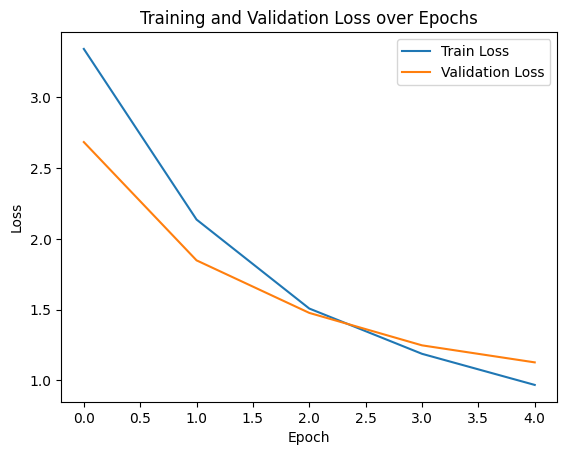

In [11]:
# Loss curve
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Training and Validation Loss over Epochs")
plt.show()


In [12]:
test_loss = validate_one_epoch(model, test_dl, criterion, device, epoch=epochs - 1, epochs=epochs)

Valid Epoch 5/5: 100%|██████████| 66/66 [00:05<00:00, 12.30batch/s, loss=0.8330]

Epoch 5/5 Validation Loss: 1.1263, Accuracy: 63.06%


In [13]:
for imgs, questions, answers, _ in test_dl:
    imgs, questions, answers = (
        imgs.to(device),
        questions.to(device),
        answers.to(device),
    )
    outputs = model(imgs, questions)
    _, predicted = torch.max(outputs.data, 1)
    for i in range(len(answers)):
        actual_answer = vocab.itos[answers[i].item()]
        predicted_answer = vocab.itos[predicted[i].item()]
        print(f"Actual: {actual_answer} | Predicted: {predicted_answer}")

Actual: mri | Predicted: mri
Actual: abdomen | Predicted: abdomen
Actual: t2 | Predicted: t2
Actual: no | Predicted: yes
Actual: liver | Predicted: liver
Actual: yes | Predicted: yes
Actual: yes | Predicted: yes
Actual: yes | Predicted: yes
Actual: none | Predicted: none
Actual: right | Predicted: left
Actual: mri | Predicted: mri
Actual: abdomen | Predicted: abdomen
Actual: t2 | Predicted: t2
Actual: 2 | Predicted: 2
Actual: yes | Predicted: yes
Actual: yes | Predicted: yes
Actual: yes | Predicted: yes
Actual: no | Predicted: yes
Actual: ct | Predicted: ct
Actual: chest | Predicted: chest
Actual: lung | Predicted: lung
Actual: lung | Predicted: lung
Actual: no | Predicted: no
Actual: yes | Predicted: no
Actual: no | Predicted: no
Actual: lung cancer | Predicted: lung cancer
Actual: no | Predicted: no
Actual: right lung, left | Predicted: right lung, left
Actual: ct | Predicted: ct
Actual: chest | Predicted: chest
Actual: lung | Predicted: lung
Actual: lung | Predicted: lung
Actual: no

In [14]:
def visualize_prediction(
    model, dataset, vocab, idx, device="cuda" if torch.cuda.is_available() else "cpu"
):
    model.eval()

    # --- get raw item ---
    item = dataset.items[idx]
    img_path = dataset.img_root / item["img_name"]
    question = item["question"]
    gt_answer = item["answer"]

    # --- load image ---
    img_pil = Image.open(img_path).convert("RGB")
    img_tensor = dataset.transform(img_pil).unsqueeze(0).to(device)

    # --- tokenize question ---
    q_tokens = tokenize(question).unsqueeze(0).to(device)

    # --- inference ---
    with torch.no_grad():
        logits = model(img_tensor, q_tokens)
        pred_idx = logits.argmax(dim=1).item()
        prob = torch.softmax(logits, dim=1).max().item()

    pred_answer = vocab.decode(pred_idx)

    # --- plot ---
    plt.figure(figsize=(5, 5))
    plt.imshow(img_pil)
    plt.axis("off")
    plt.title(
        f"Question: {question}\nGT: {gt_answer} | Pred: {pred_answer}\nConfidence: {prob * 100:.2f}%\nIndex: {idx}"
    )
    plt.show()


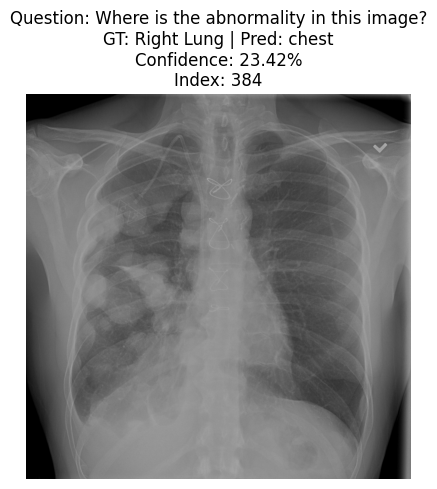

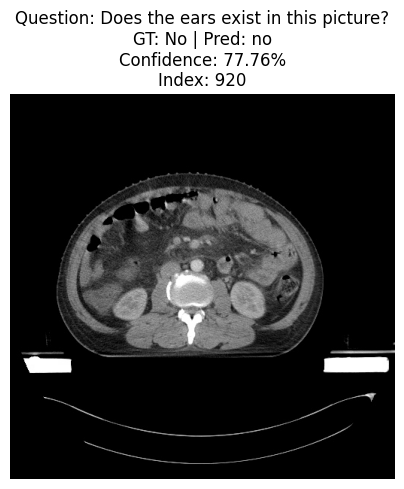

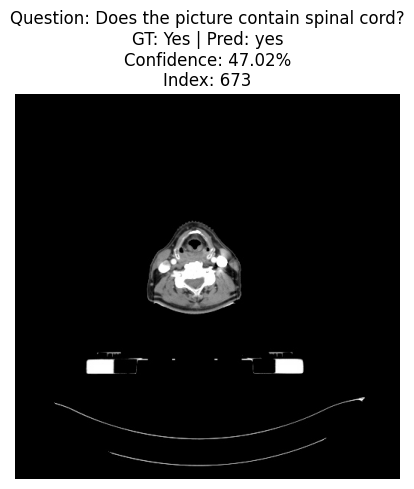

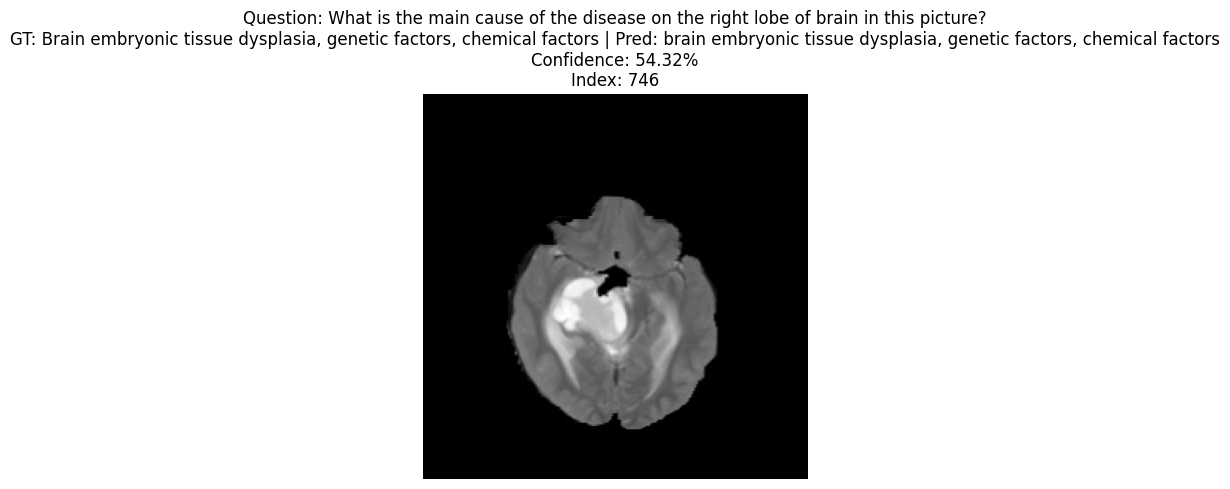

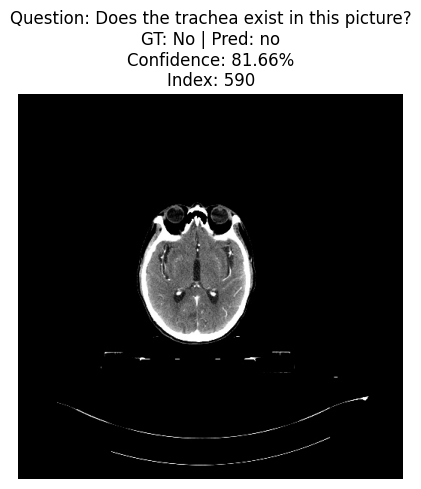

In [15]:
# Choose 5 random samples to visualize
total_samples = len(test_ds)
random_indices = random.sample(range(total_samples), 5)
for idx in random_indices:
    visualize_prediction(model, test_ds, vocab, idx=idx, device=device)


In [16]:
def evaluate_by_answer_type(model, dataloader, dataset, device):
    model.eval()

    stats = {
        "OPEN": {"correct": 0, "total": 0},
        "CLOSED": {"correct": 0, "total": 0},
    }

    with torch.no_grad():
        for imgs, questions, answers, indices in tqdm(dataloader, desc="Evaluating"):
            imgs = imgs.to(device)
            questions = questions.to(device)
            answers = answers.to(device)

            outputs = model(imgs, questions)
            preds = outputs.argmax(dim=1)

            for i in range(len(indices)):
                idx = indices[i].item()
                answer_type = dataset.items[idx]["answer_type"]

                stats[answer_type]["total"] += 1
                if preds[i] == answers[i]:
                    stats[answer_type]["correct"] += 1

    results = {}
    for k, v in stats.items():
        acc = 100.0 * v["correct"] / v["total"] if v["total"] > 0 else 0.0
        results[k] = acc

    # Overall accuracy
    results["OVERALL"] = (
        100.0
        * sum(v["correct"] for v in stats.values())
        / sum(v["total"] for v in stats.values())
    )

    return results


print("Accuracy by Answer Type:")
print("Test Set:")
answer_type_acc_test = evaluate_by_answer_type(model, test_dl, test_ds, device)
for atype, acc in answer_type_acc_test.items():
    print(f"{atype}: {acc:.2f}%")

print("Validation Set:")
answer_type_acc = evaluate_by_answer_type(model, val_dl, val_ds, device)
for atype, acc in answer_type_acc.items():
    print(f"{atype}: {acc:.2f}%")

print("Training Set:")
answer_type_acc = evaluate_by_answer_type(model, train_dl, train_ds, device)
for atype, acc in answer_type_acc.items():
    print(f"{atype}: {acc:.2f}%")

Accuracy by Answer Type:
Test Set:


Evaluating: 100%|██████████| 66/66 [00:05<00:00, 12.31it/s]


OPEN: 68.46%
CLOSED: 54.98%
OVERALL: 63.06%
Validation Set:


Evaluating: 100%|██████████| 66/66 [00:05<00:00, 12.34it/s]


OPEN: 68.46%
CLOSED: 54.98%
OVERALL: 63.06%
Training Set:


Evaluating: 100%|██████████| 308/308 [00:24<00:00, 12.82it/s]

OPEN: 81.49%
CLOSED: 66.75%
OVERALL: 75.67%


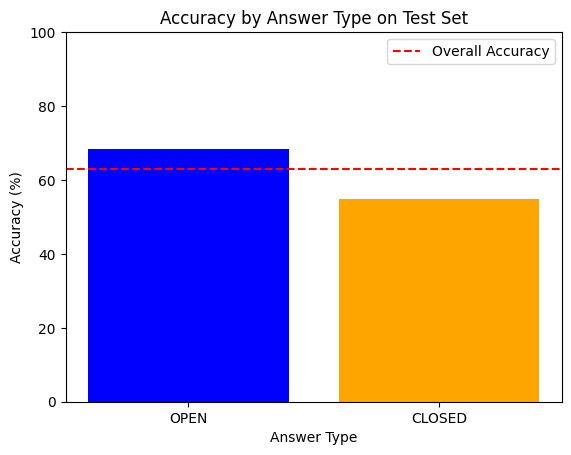

In [17]:
# Plot a bar chart (draw dotted line for overall accuracy)
labels = list(item for item in answer_type_acc_test.keys() if item != "OVERALL")
values = list(answer_type_acc_test[item] for item in labels)
plt.bar(labels, values, color=["blue", "orange"])
plt.axhline(
    y=answer_type_acc_test["OVERALL"],
    color="r",
    linestyle="--",
    label="Overall Accuracy",
)
plt.legend()
plt.xlabel("Answer Type")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy by Answer Type on Test Set")
plt.ylim(0, 100)
plt.show()

In [18]:
device = "cuda" if torch.cuda.is_available() else "cpu"

processor = BlipProcessor.from_pretrained("Salesforce/blip-vqa-base")
blip_model = BlipForQuestionAnswering.from_pretrained("Salesforce/blip-vqa-base").to(
    device
)

blip_model.eval()

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


BlipForQuestionAnswering(
  (vision_model): BlipVisionModel(
    (embeddings): BlipVisionEmbeddings(
      (patch_embedding): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (encoder): BlipEncoder(
      (layers): ModuleList(
        (0-11): 12 x BlipEncoderLayer(
          (self_attn): BlipAttention(
            (dropout): Dropout(p=0.0, inplace=False)
            (qkv): Linear(in_features=768, out_features=2304, bias=True)
            (projection): Linear(in_features=768, out_features=768, bias=True)
          )
          (layer_norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): BlipMLP(
            (activation_fn): GELUActivation()
            (fc1): Linear(in_features=768, out_features=3072, bias=True)
            (fc2): Linear(in_features=3072, out_features=768, bias=True)
          )
          (layer_norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        )
      )
    )
    (post_layernorm): LayerNorm((768,), eps=1e-05, e

In [19]:
print(
    f"Number of parameters: {sum(p.numel() for p in blip_model.parameters() if p.requires_grad)}"
)

Number of parameters: 361230140


In [20]:
def blip_predict(image_pil, question, max_length=10):
    """
    image_pil: PIL.Image
    question: str
    returns: str (generated answer)
    """
    inputs = processor(image_pil, question, return_tensors="pt").to(device)

    with torch.no_grad():
        output_ids = blip_model.generate(**inputs, max_length=max_length)

    answer = processor.decode(output_ids[0], skip_special_tokens=True)
    return answer.strip()


def normalize_answer(ans: str):
    ans = ans.lower().strip()
    return ans


normalized_vocab = {normalize_answer(a): a for a in vocab.itos}


def map_blip_to_vocab(blip_answer, vocab, normalized_vocab):
    key = normalize_answer(blip_answer)
    if key in normalized_vocab:
        return normalized_vocab[key]
    return "<unk>"


def evaluate_blip_zero_shot(dataset, vocab, normalized_vocab, max_samples=None):
    correct = 0
    total = 0

    for i in tqdm(range(len(dataset))):
        if max_samples and i >= max_samples:
            break

        item = dataset.items[i]

        img = Image.open(dataset.img_root / item["img_name"]).convert("RGB")
        question = item["question"]
        gt_answer = item["answer"]

        pred_text = blip_predict(img, question)
        pred_vocab = map_blip_to_vocab(pred_text, vocab, normalized_vocab)

        if normalize_answer(pred_vocab) == normalize_answer(gt_answer):
            correct += 1
        total += 1

    acc = correct / total
    print(f"BLIP Zero-shot Accuracy: {acc * 100:.2f}%")
    return acc

In [21]:
blip_acc = evaluate_blip_zero_shot(
    test_ds,
    vocab,
    normalized_vocab,
    # max_samples=200,  # keep it fast
)

100%|██████████| 1053/1053 [01:19<00:00, 13.26it/s]

BLIP Zero-shot Accuracy: 25.55%


In [22]:
normalized_vocab

{'<unk>': '<unk>',
 'mri': 'mri',
 'abdomen': 'abdomen',
 't2': 't2',
 'yes': 'yes',
 'no': 'no',
 'right': 'right',
 'ct': 'ct',
 'chest': 'chest',
 'liver, heart, spleen, lung': 'liver, heart, spleen, lung',
 'liver': 'liver',
 'spinal cord': 'spinal cord',
 'lung': 'lung',
 'lung cancer': 'lung cancer',
 'right lung, left': 'right lung, left',
 'lung, heart': 'lung, heart',
 'none': 'none',
 'left lung, right': 'left lung, right',
 'left lung, lower right': 'left lung, lower right',
 'lower right': 'lower right',
 'lung, liver': 'lung, liver',
 'right lung, lower left': 'right lung, lower left',
 'heart': 'heart',
 'not seen': 'not seen',
 'x-ray': 'x-ray',
 'effusion': 'effusion',
 'noudle': 'noudle',
 'left lung, upper right': 'left lung, upper right',
 'cardiomegaly, pneumothorax': 'cardiomegaly, pneumothorax',
 'center, left lung': 'center, left lung',
 'both': 'both',
 'nodule': 'nodule',
 'atelectasis': 'atelectasis',
 'cardiomegal': 'cardiomegal',
 'center': 'center',
 'pneum

In [23]:
def compare_models_sample(idx, dataset, model, vocab):
    item = dataset.items[idx]

    # Load image
    img_path = dataset.img_root / item["img_name"]
    img_pil = Image.open(img_path).convert("RGB")

    # Ground truth
    question = item["question"]
    gt_answer = item["answer"]

    # Baseline prediction
    img_tensor, q_tensor, _, _ = dataset[idx]
    with torch.no_grad():
        logits = model(
            img_tensor.unsqueeze(0).to(device),
            q_tensor.unsqueeze(0).to(device),
        )
        pred_idx = logits.argmax(1).item()
    baseline_answer = vocab.decode(pred_idx)

    # BLIP prediction
    blip_answer = blip_predict(img_pil, question)

    # Plot
    plt.figure(figsize=(5, 5))
    plt.imshow(img_pil)
    plt.axis("off")

    title = (
        f"Q: {question}\n"
        f"GT: {gt_answer}\n"
        f"Baseline: {baseline_answer}\n"
        f"BLIP: {blip_answer}"
    )
    plt.title(title, fontsize=10)
    plt.show()

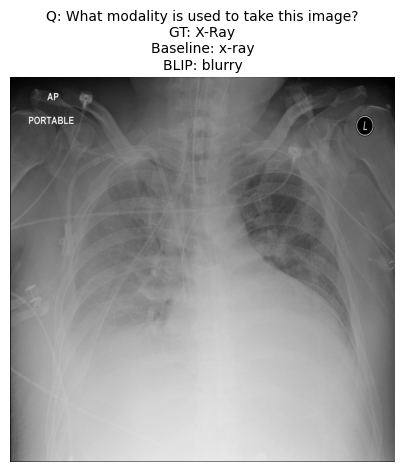

In [24]:
compare_models_sample(idx=100, dataset=val_ds, model=model, vocab=vocab)

In [25]:
def evaluate_blip_by_answer_type(dataloader, dataset):
    stats = {
        "OPEN": {"correct": 0, "total": 0},
        "CLOSED": {"correct": 0, "total": 0},
    }

    for imgs, questions, answers, indices in tqdm(dataloader, desc="Evaluating BLIP"):
        # We ignore imgs/questions tensors and use raw dataset entries
        for i in range(len(indices)):
            idx = indices[i].item()
            item = dataset.items[idx]

            image_path = DATASET_DIR / "SLAKE" / "imgs" / item["img_name"]
            img = Image.open(image_path).convert("RGB")
            question = item["question"]
            gt_answer = normalize_answer(item["answer"])
            answer_type = item["answer_type"]  # OPEN / CLOSED

            # BLIP prediction
            pred_text = blip_predict(img, question)
            pred_text = normalize_answer(pred_text)

            # Map BLIP output to vocab space
            pred_vocab = map_blip_to_vocab(pred_text, vocab, normalized_vocab)

            # Update stats (INSIDE inner loop!)
            if pred_vocab == gt_answer:
                stats[answer_type]["correct"] += 1
            stats[answer_type]["total"] += 1

    # Compute accuracies
    results = {}
    for k, v in stats.items():
        acc = v["correct"] / v["total"] if v["total"] > 0 else 0.0
        results[k] = acc

    results["OVERALL"] = sum(v["correct"] for v in stats.values()) / sum(
        v["total"] for v in stats.values()
    )

    return results

In [26]:
blip_results = evaluate_blip_by_answer_type(test_dl, test_ds)

print("BLIP-VQA Zero-shot Accuracy:")
for k, v in blip_results.items():
    print(f"{k}: {v * 100:.2f}%")

Evaluating BLIP: 100%|██████████| 66/66 [01:23<00:00,  1.27s/it]

BLIP-VQA Zero-shot Accuracy:
OPEN: 8.08%
CLOSED: 51.66%
OVERALL: 25.55%


In [27]:
# Everything times 100
blip_results = {k: v * 100 for k, v in blip_results.items()}

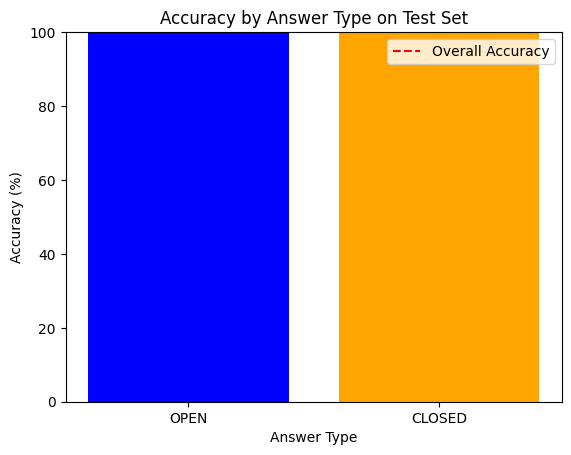

In [28]:
# Plot a bar chart (draw dotted line for overall accuracy)
labels = list(item for item in blip_results.keys() if item != "OVERALL")
values = list(blip_results[item] * 100 for item in labels)
plt.bar(labels, values, color=["blue", "orange"])
plt.axhline(
    y=blip_results["OVERALL"] * 100,
    color="r",
    linestyle="--",
    label="Overall Accuracy",
)
plt.legend()
plt.xlabel("Answer Type")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy by Answer Type on Test Set")
plt.ylim(0, 100)
plt.show()

In [29]:
answer_type_acc_test

{'OPEN': 68.46275752773376,
 'CLOSED': 54.976303317535546,
 'OVERALL': 63.05792972459639}

In [30]:
blip_results

{'OPEN': 8.082408874801903,
 'CLOSED': 51.65876777251185,
 'OVERALL': 25.546058879392213}

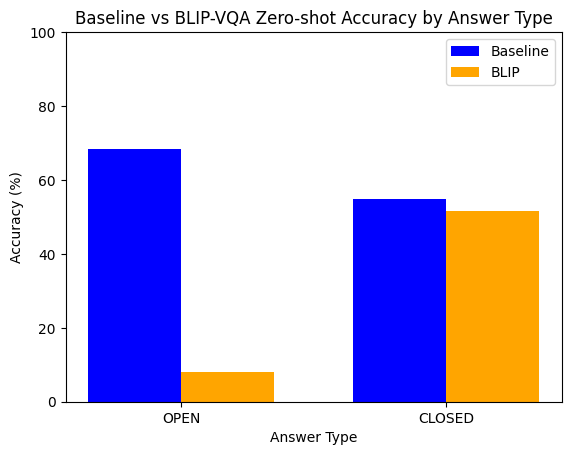

In [31]:
# Group bar chart comparing baseline and BLIP accuracies
labels = list(item for item in blip_results.keys() if item != "OVERALL")
values_blip = list(blip_results[item] for item in labels)
values_baseline = list(answer_type_acc_test[item] for item in labels)
x = np.arange(len(labels))
width = 0.35
plt.bar(x - width / 2, values_baseline, width, label="Baseline", color="blue")
plt.bar(x + width / 2, values_blip, width, label="BLIP", color="orange")
plt.xlabel("Answer Type")
plt.ylabel("Accuracy (%)")
plt.title("Baseline vs BLIP-VQA Zero-shot Accuracy by Answer Type")
plt.xticks(x, labels)
plt.ylim(0, 100)
plt.legend()
plt.show()